# 필수 실행


## 구글드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 필수 설치

In [2]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 946.2 kB/s eta 0:00:00


## 필수 임포트

In [3]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.font_manager as fm
import tqdm

pd.set_option('display.max_columns', None)

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

import warnings
warnings.filterwarnings('ignore')

## csv파일 불러오기


In [4]:
train_df = pd.read_csv('/content/drive/MyDrive/daegu/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/daegu/test.csv')
submission_df = pd.read_csv('/content/drive/MyDrive/daegu/sample_submission.csv')
extra_train_df = pd.read_csv('/content/drive/MyDrive/daegu/external_open/countrywide_accident.csv')
light_df = pd.read_csv('/content/drive/MyDrive/daegu/external_open/대구보안등정보.csv',encoding='cp949')
child_area_df = pd.read_csv('/content/drive/MyDrive/daegu/external_open/대구어린이보호구역정보.csv',encoding='cp949')
parking_df = pd.read_csv('/content/drive/MyDrive/daegu/external_open/대구주차장정보.csv',encoding='cp949')
cctv_df = pd.read_csv('/content/drive/MyDrive/daegu/external_open/대구CCTV정보.csv',encoding='cp949')

## train/test data 합치기 및 컬럼정리


- 필요없다고 생각한 컬럼 정리

In [5]:
light_df = light_df.drop(columns=['보안등위치명','소재지도로명주소','위도','경도'])
child_area_df = child_area_df.drop(columns=['소재지도로명주소','위도','경도','데이터기준일자'])
parking_df = parking_df.drop(columns=['주차장관리번호','소재지도로명주소','위도','경도','데이터기준일자'])
cctv_df = cctv_df.drop(columns=['소재지도로명주소','위도','경도'])

In [6]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

- 보안등 정보

In [7]:
light_df[['도시', '구', '동', '번지']] = light_df['소재지지번주소'].str.extract(location_pattern)
light_df = light_df.drop(columns=['소재지지번주소', '번지'])

In [8]:
light_df = pd.get_dummies(light_df, columns=['설치형태'])

In [9]:
light_df['설치개수평균'] = light_df['설치개수']

light_ = light_df[['설치형태_건축물', '설치형태_전용주', '설치형태_한전주',
                   '설치개수','도시', '구', '동']].groupby(['도시', '구', '동']).sum().reset_index()
light__ = light_df[['설치개수평균','도시', '구', '동']].groupby(['도시', '구', '동']).mean().round(2).reset_index()

In [10]:
light_.reset_index(inplace=True, drop=True)
light__.reset_index(inplace=True, drop=True)

- 어린이 보호구역

In [11]:
child_area_df['CCTV설치대수'].fillna(0, inplace=True)
child_area_df['CCTV설치한곳의수'] = 1
child_area_df['CCTV설치대수평균'] = child_area_df['CCTV설치대수']

In [12]:
child_area_df[['도시', '구', '동', '번지']] = child_area_df['소재지지번주소'].str.extract(location_pattern)
child_area_df = child_area_df.drop(columns=['소재지지번주소', '번지'])

In [13]:
child_area_df = pd.get_dummies(child_area_df, columns=['시설종류','관할경찰서명','CCTV설치여부'])

In [14]:
child_area_ = child_area_df[['시설종류_어린이집',
       '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교', '시설종류_학원', '관할경찰서명_강북경찰서',
       '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서', '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서',
       '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서', '관할경찰서명_수성경찰서', 'CCTV설치여부_N',
       'CCTV설치여부_Y','CCTV설치한곳의수','CCTV설치대수','도시', '구', '동']].groupby(['도시', '구', '동']).sum().reset_index()
child_area__ = child_area_df[['CCTV설치대수평균','도시', '구', '동']].groupby(['도시', '구', '동']).mean().round(2).reset_index()

In [15]:
child_area_.reset_index(inplace=True, drop=True)
child_area__.reset_index(inplace=True, drop=True)

- 주차장 정보

In [16]:
parking_df[['도시', '구', '동', '번지']] = parking_df['소재지지번주소'].str.extract(location_pattern)
parking_df = parking_df.drop(columns=['소재지지번주소', '번지'])

parking_df['주차구획수평균'] = parking_df['주차구획수']

parking_df = pd.get_dummies(parking_df, columns=['급지구분','결제방법','주차장구분','주차장유형'])


parking_df_ = parking_df[['급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료',
       '결제방법_신용카드', '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외','주차구획수','도시', '구', '동']].groupby(['도시', '구', '동']).sum().reset_index()
parking_df__ = parking_df[['주차구획수평균','주차기본요금','추가단위요금',
                           '1일주차권요금','월정기권요금','도시', '구', '동']].groupby(['도시', '구', '동']).mean().round(2).reset_index()

parking_df_.reset_index(inplace=True, drop=True)
parking_df__.reset_index(inplace=True, drop=True)

- cctv 정보

In [17]:
cctv_df['무인CCTV설치한곳의수'] = 1

In [18]:
cctv_df[['도시', '구', '동', '번지']] = cctv_df['소재지지번주소'].str.extract(location_pattern)
cctv_df = cctv_df.drop(columns=['소재지지번주소', '번지'])

In [19]:
cctv_df = pd.get_dummies(cctv_df, columns=['도로노선방향'])

In [20]:
cctv_ = cctv_df[['도로노선방향_1', '도로노선방향_2','도로노선방향_3',
                 '무인CCTV설치한곳의수','도시', '구', '동']].groupby(['도시', '구', '동']).sum().reset_index()
cctv__ = cctv_df[['설치연도','제한속도','도시', '구', '동']].groupby(['도시', '구', '동']).mean().round(2).reset_index()

In [21]:
cctv_.reset_index(inplace=True, drop=True)
cctv__.reset_index(inplace=True, drop=True)

- '사고일시' 분리

In [22]:
time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

train_df[['연', '월', '일', '시간']] = train_df['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
train_df = train_df.drop(columns=['사고일시'])

test_df[['연', '월', '일', '시간']] = test_df['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

- '시군구' 분리

In [23]:
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_df['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_df['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

- '도로형태'분리

In [24]:
road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_df['도로형태'].str.extract(road_pattern)

test_df[['도로형태1', '도로형태2']] = test_df['도로형태'].str.extract(road_pattern)

- 추가정보들 일단 모두 merge하기

In [25]:
print(f'{light_df.shape}/{child_area_df.shape}/{parking_df.shape}/{cctv_df.shape}')

(71913, 9)/(640, 24)/(871, 39)/(1065, 20)


In [26]:
parking_df.columns

Index(['주차장명', '주차구획수', '부제시행구분', '운영요일', '평일운영시작시각', '평일운영종료시각', '토요일운영시작시각',
       '토요일운영종료시각', '공휴일운영시작시각', '공휴일운영종료시각', '요금정보', '주차기본시간', '주차기본요금',
       '추가단위시간', '추가단위요금', '1일주차권요금적용시간', '1일주차권요금', '월정기권요금', '특기사항', '도시',
       '구', '동', '주차구획수평균', '급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드',
       '결제방법_무료', '결제방법_신용카드', '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금',
       '결제방법_현금+신용카드', '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영',
       '주차장유형_노상', '주차장유형_노외'],
      dtype='object')

In [27]:
train_df = train_df.drop(columns=['사고유형 - 세부분류', '법규위반',
                                  '가해운전자 차종', '가해운전자 성별','가해운전자 연령', '가해운전자 상해정도',
                                  '피해운전자 차종','피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도',
                                  '사망자수', '중상자수', '경상자수', '부상자수',])

In [28]:
train_df = pd.merge(train_df, light_, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, light__, how='left', on=['도시', '구', '동'])

test_df = pd.merge(test_df, light_, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, light__, how='left', on=['도시', '구', '동'])

In [29]:
train_df = pd.merge(train_df, child_area_, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, child_area__, how='left', on=['도시', '구', '동'])

test_df = pd.merge(test_df, child_area_, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, child_area__, how='left', on=['도시', '구', '동'])

In [30]:
train_df = pd.merge(train_df, parking_df_, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, parking_df__, how='left', on=['도시', '구', '동'])

test_df = pd.merge(test_df, parking_df_, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, parking_df__, how='left', on=['도시', '구', '동'])

In [31]:
train_df = pd.merge(train_df, cctv_, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, cctv__, how='left', on=['도시', '구', '동'])

test_df = pd.merge(test_df, cctv_, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, cctv__, how='left', on=['도시', '구', '동'])

# Model_1 [0.42862]


In [ ]:
test_x = test_df[['요일', '노면상태', '사고유형', '도로형태', '연','월','일','시간']].copy()
train_x = train_df[['요일', '노면상태', '사고유형', '도로형태', '연','월','일','시간']].copy()
train_y = train_df['ECLO'].copy()

In [ ]:
def one_hot(df):

    # one-hot encoding 실시
    df = pd.get_dummies(df)

    return df

In [ ]:
X_train_eng = one_hot(train_x)
X_test_eng = one_hot(test_x)

y_train = np.log(train_y)

In [ ]:
print(f'X_train 데이터 shape : {X_train_eng.shape}')
print(f'y_train 데이터 shape : {y_train.shape}')
print()
print(f'X_test 데이터 shape : {X_test_eng.shape}')

X_train 데이터 shape : (39609, 31)
y_train 데이터 shape : (39609,)

X_test 데이터 shape : (10963, 31)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_eng, y_train , test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
import numpy as np

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

from sklearn.metrics import make_scorer

# RMSLE를 평가 지표로 변환
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

## LGBMRegressor 모델

In [ ]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# LGBM Regressor 모델 생성
lgbm = LGBMRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [300, 400, 500, 800, 1200]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_lgbm.best_params_)
print("최적의 점수:", grid_search_lgbm.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
lgbm_best = LGBMRegressor(**grid_search_lgbm.best_params_,random_state=42)

# 모델 학습
lgbm_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = lgbm_best.predict(X_train)
y_val_pred = lgbm_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 27
[LightGBM] [Info] Start training from score 1.383856
최적의 하이퍼파라미터: {'learning_rate': 0.01, 'n_estimators': 400, 'num_leaves': 10}
최적의 점수: 0.029031155269384157
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 31687, number

## RandomForestRegressor 모델

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

# Random Forest Regressor 모델 생성
rf = RandomForestRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [8, 10, 12]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_rf.best_params_)
print("최적의 점수:", grid_search_rf.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
rf_best = RandomForestRegressor(**grid_search_rf.best_params_,random_state=42)

# 모델 학습
rf_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = rf_best.predict(X_train)
y_val_pred = rf_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'max_depth': 10, 'min_samples_split': 12, 'n_estimators': 300}
최적의 점수: 0.022340582021947553
0.4315169946839741
0.4481976925060826


## XGBRegressor 모델

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# XGB Regressor 모델 생성
xgb = XGBRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_xgb.best_params_)
print("최적의 점수:", grid_search_xgb.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
xgb_best = XGBRegressor(**grid_search_xgb.best_params_,random_state=42)

# 모델 학습
xgb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = xgb_best.predict(X_train)
y_val_pred = xgb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
최적의 점수: 0.028918976438860582
0.44493776835246157
0.4470742535218405


## GradientBoosting

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
model = GradientBoostingRegressor()

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],  # 트리 개수
    'learning_rate': [0.01, 0.1, 0.2],  # 학습률
    'max_depth': [3, 4, 5]  # 트리 최대 깊이
}

# GridSearchCV를 사용하여 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

gb_best = grid_search.best_estimator_

gb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = gb_best.predict(X_train)
y_val_pred = gb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

0.4448149797002048
0.4471686491821946


## Stack

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

In [ ]:
# 개별 모델 생성
rf = rf_best
lgbm = lgbm_best
xgb = xgb_best
gb = gb_best


# 스태킹 앙상블 모델 생성
estimators = [
    ('rf', rf),
    ('lgbm', lgbm),
    ('xgb', xgb),
    ('gb', gb)
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# 모델 학습
stacking_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = stacking_model.predict(X_train)
y_val_pred = stacking_model.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 27
[LightGBM] [Info] Start training from score 1.383856
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 25349, number of used features: 27
[LightGBM] [Info] Start training from score 1.386939
[LightGBM] [Warning] Found whi

In [ ]:
y_pred1 = stacking_model.predict(X_test_eng)
y_pred1

array([1.29953129, 1.1916106 , 1.5309443 , ..., 1.37940378, 1.38258827,
       1.43195649])

In [ ]:
y_pred = np.exp(y_pred1)
y_pred

array([3.66757724, 3.29237964, 4.62253983, ..., 3.97253243, 3.98520307,
       4.1868828 ])

In [ ]:
submission_df['ECLO'] = y_pred
submission_df.head()

,ID,ECLO
0,ACCIDENT_39609,3.667577
1,ACCIDENT_39610,3.292380
2,ACCIDENT_39611,4.622540
3,ACCIDENT_39612,4.389425
4,ACCIDENT_39613,4.336327


<Axes: ylabel='Count'>

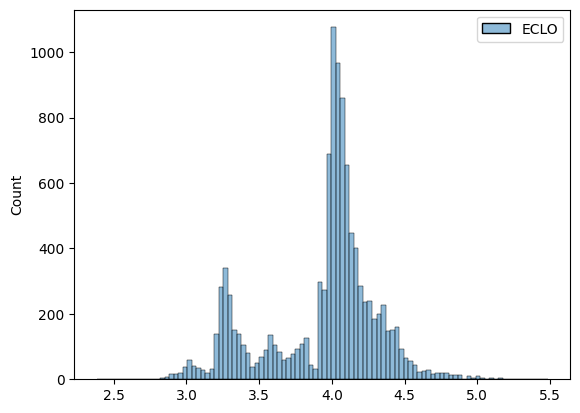

In [ ]:
sns.histplot(submission_df)

# Model_2 [0.42774]

In [ ]:
train_df.columns

Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간',
       '도시', '구', '동', '도로형태1', '도로형태2', '설치형태_건축물', '설치형태_전용주', '설치형태_한전주',
       '설치개수', '설치개수평균', '시설종류_어린이집', '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교',
       '시설종류_학원', '관할경찰서명_강북경찰서', '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서',
       '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서', '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서',
       '관할경찰서명_수성경찰서', 'CCTV설치여부_N', 'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수',
       'CCTV설치대수평균', '급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료',
       '결제방법_신용카드', '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도'],
      dtype='object')

In [ ]:
test_x = test_df[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'설치형태_한전주','시간','설치개수','설치개수평균','주차구획수',
                  '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도', '제한속도']].copy()
train_x = train_df[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'설치형태_한전주','시간','설치개수','설치개수평균','주차구획수',
                  '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도', '제한속도']].copy()
train_y = train_df['ECLO'].copy()

In [ ]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   요일            39609 non-null  object 
 1   노면상태          39609 non-null  object 
 2   사고유형          39609 non-null  object 
 3   도로형태2         39609 non-null  object 
 4   설치형태_건축물      30096 non-null  float64
 5   설치형태_전용주      30096 non-null  float64
 6   설치형태_한전주      30096 non-null  float64
 7   시간            39609 non-null  int64  
 8   설치개수          30096 non-null  float64
 9   설치개수평균        30096 non-null  float64
 10  주차구획수         33066 non-null  float64
 11  관할경찰서명_달성경찰서  21183 non-null  float64
 12  CCTV설치여부_N    21183 non-null  float64
 13  주차기본요금        33066 non-null  float64
 14  설치연도          38033 non-null  float64
 15  제한속도          38033 non-null  float64
dtypes: float64(11), int64(1), object(4)
memory usage: 5.1+ MB


In [ ]:
def one_hot(df):

    # one-hot encoding 실시
    df = pd.get_dummies(df)

    return df

In [ ]:
X_train_eng = one_hot(train_x)
X_test_eng = one_hot(test_x)

y_train = np.log(train_y)

In [ ]:
X_train_eng.fillna(0, inplace=True)
X_test_eng.fillna(0, inplace=True)

In [ ]:
print(f'X_train 데이터 shape : {X_train_eng.shape}')
print(f'y_train 데이터 shape : {y_train.shape}')
print()
print(f'X_test 데이터 shape : {X_test_eng.shape}')

X_train 데이터 shape : (39609, 38)
y_train 데이터 shape : (39609,)

X_test 데이터 shape : (10963, 38)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_eng, y_train , test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
import numpy as np

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

from sklearn.metrics import make_scorer

# RMSLE를 평가 지표로 변환
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

## LGBMRegressor 모델

In [ ]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# LGBM Regressor 모델 생성
lgbm = LGBMRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [300, 400, 500, 800, 1200]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_lgbm.best_params_)
print("최적의 점수:", grid_search_lgbm.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
lgbm_best = LGBMRegressor(**grid_search_lgbm.best_params_,random_state=42)

# 모델 학습
lgbm_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = lgbm_best.predict(X_train)
y_val_pred = lgbm_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 680
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 34
[LightGBM] [Info] Start training from score 1.383856
최적의 하이퍼파라미터: {'learning_rate': 0.01, 'n_estimators': 400, 'num_leaves': 10}
최적의 점수: 0.030134187311990062
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 680
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 34
[LightGBM] [Info] Start training from score 1.383856
0.44354856243360824
0.4458868215481421


## RandomForestRegressor 모델

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

# Random Forest Regressor 모델 생성
rf = RandomForestRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [8, 10, 12]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_rf.best_params_)
print("최적의 점수:", grid_search_rf.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
rf_best = RandomForestRegressor(**grid_search_rf.best_params_,random_state=42)

# 모델 학습
rf_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = rf_best.predict(X_train)
y_val_pred = rf_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'max_depth': 10, 'min_samples_split': 12, 'n_estimators': 300}
최적의 점수: 0.02552832236627271
0.4285542701988254
0.4475290763618613


## XGBRegressor 모델

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# XGB Regressor 모델 생성
xgb = XGBRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_xgb.best_params_)
print("최적의 점수:", grid_search_xgb.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
xgb_best = XGBRegressor(**grid_search_xgb.best_params_,random_state=42)

# 모델 학습
xgb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = xgb_best.predict(X_train)
y_val_pred = xgb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
최적의 점수: 0.030611694593673595
0.44422557746914654
0.4461078434718159


## GradientBoosting

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
model = GradientBoostingRegressor()

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],  # 트리 개수
    'learning_rate': [0.01, 0.1, 0.2],  # 학습률
    'max_depth': [3, 4, 5]  # 트리 최대 깊이
}

# GridSearchCV를 사용하여 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

gb_best = grid_search.best_estimator_

gb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = gb_best.predict(X_train)
y_val_pred = gb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

0.4440261620919907
0.44597897188984953


## Stack

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

In [ ]:
# 개별 모델 생성
rf = rf_best
lgbm = lgbm_best
xgb = xgb_best
gb = gb_best


# 스태킹 앙상블 모델 생성
estimators = [
    ('rf', rf),
    ('lgbm', lgbm),
    ('xgb', xgb),
    ('gb', gb)
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# 모델 학습
stacking_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = stacking_model.predict(X_train)
y_val_pred = stacking_model.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 680
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 34
[LightGBM] [Info] Start training from score 1.383856
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 678
[LightGBM] [Info] Number of data points in the train set: 25349, number of used features: 34
[LightGBM] [Info] Start training from score 1.386939
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 673
[LightGBM] [Info] Number of data points in the train set: 25349, number of used features: 34
[LightGBM] [Info] Start traini

In [ ]:
y_pred1 = stacking_model.predict(X_test_eng)
y_pred1

array([1.30035199, 1.25161234, 1.52578359, ..., 1.44260326, 1.4623649 ,
       1.4945105 ])

In [ ]:
y_pred = np.exp(y_pred1)
y_pred

array([3.67058845, 3.4959751 , 4.59874569, ..., 4.23169772, 4.31615476,
       4.45715423])

In [ ]:
submission_df['ECLO'] = y_pred
submission_df.head()

,ID,ECLO
0,ACCIDENT_39609,3.670588
1,ACCIDENT_39610,3.495975
2,ACCIDENT_39611,4.598746
3,ACCIDENT_39612,4.127514
4,ACCIDENT_39613,4.360410


<Axes: ylabel='Count'>

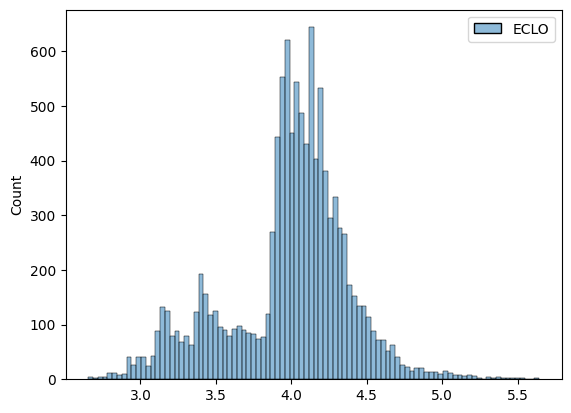

In [ ]:
sns.histplot(submission_df)

In [ ]:
submission_df.to_csv('/content/drive/MyDrive/[Stacking]컬럼수정.csv', index=False)

# Model_3 []

In [ ]:
train_df.columns

Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간',
       '도시', '구', '동', '도로형태1', '도로형태2', '설치형태_건축물', '설치형태_전용주', '설치형태_한전주',
       '설치개수', '설치개수평균', '시설종류_어린이집', '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교',
       '시설종류_학원', '관할경찰서명_강북경찰서', '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서',
       '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서', '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서',
       '관할경찰서명_수성경찰서', 'CCTV설치여부_N', 'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수',
       'CCTV설치대수평균', '급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료',
       '결제방법_신용카드', '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도'],
      dtype='object')

In [ ]:
test_x = test_df[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'설치형태_한전주','시간','설치개수','설치개수평균','주차구획수',
                  '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도', '제한속도']].copy()
train_x = train_df[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'설치형태_한전주','시간','설치개수','설치개수평균','주차구획수',
                  '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도', '제한속도']].copy()
train_y = train_df['ECLO'].copy()

In [ ]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   요일            39609 non-null  object 
 1   노면상태          39609 non-null  object 
 2   사고유형          39609 non-null  object 
 3   도로형태2         39609 non-null  object 
 4   설치형태_건축물      30096 non-null  float64
 5   설치형태_전용주      30096 non-null  float64
 6   설치형태_한전주      30096 non-null  float64
 7   시간            39609 non-null  int64  
 8   설치개수          30096 non-null  float64
 9   설치개수평균        30096 non-null  float64
 10  주차구획수         33066 non-null  float64
 11  관할경찰서명_달성경찰서  21183 non-null  float64
 12  CCTV설치여부_N    21183 non-null  float64
 13  주차기본요금        33066 non-null  float64
 14  설치연도          38033 non-null  float64
 15  제한속도          38033 non-null  float64
dtypes: float64(11), int64(1), object(4)
memory usage: 5.1+ MB


In [ ]:
def one_hot(df):

    # one-hot encoding 실시
    df = pd.get_dummies(df)

    return df

In [ ]:
X_train_eng = one_hot(train_x)
X_test_eng = one_hot(test_x)

y_train = np.log(train_y)

In [ ]:
X_train_eng.fillna(0, inplace=True)
X_test_eng.fillna(0, inplace=True)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1, random_state=42)

pca_temp = pca.fit_transform(X_train_eng[['설치형태_건축물', '설치형태_한전주','설치개수']])
X_train_eng = X_train_eng.drop(['설치형태_건축물', '설치형태_한전주','설치개수'], axis=1)
X_train_eng['건축_한전_개수'] = pca_temp

pca_temp = pca.fit_transform(X_test_eng[['설치형태_건축물', '설치형태_한전주','설치개수']])
X_test_eng = X_test_eng.drop(['설치형태_건축물', '설치형태_한전주','설치개수'], axis=1)
X_test_eng['건축_한전_개수'] = pca_temp

In [ ]:
print(f'X_train 데이터 shape : {X_train_eng.shape}')
print(f'y_train 데이터 shape : {y_train.shape}')
print()
print(f'X_test 데이터 shape : {X_test_eng.shape}')

X_train 데이터 shape : (39609, 36)
y_train 데이터 shape : (39609,)

X_test 데이터 shape : (10963, 36)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_eng, y_train , test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
import numpy as np

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

from sklearn.metrics import make_scorer

# RMSLE를 평가 지표로 변환
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

## LGBMRegressor 모델

In [ ]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# LGBM Regressor 모델 생성
lgbm = LGBMRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [300, 400, 500, 800, 1200]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_lgbm.best_params_)
print("최적의 점수:", grid_search_lgbm.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
lgbm_best = LGBMRegressor(**grid_search_lgbm.best_params_,random_state=42)

# 모델 학습
lgbm_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = lgbm_best.predict(X_train)
y_val_pred = lgbm_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 572
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 32
[LightGBM] [Info] Start training from score 1.383856
최적의 하이퍼파라미터: {'learning_rate': 0.01, 'n_estimators': 400, 'num_leaves': 10}
최적의 점수: 0.029995506067861537
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 572
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 32
[LightGBM] [Info] Start training from score 1.383856
0.44366179152427254
0.44585431627497163


## RandomForestRegressor 모델

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

# Random Forest Regressor 모델 생성
rf = RandomForestRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [8, 10, 12]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_rf.best_params_)
print("최적의 점수:", grid_search_rf.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
rf_best = RandomForestRegressor(**grid_search_rf.best_params_,random_state=42)

# 모델 학습
rf_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = rf_best.predict(X_train)
y_val_pred = rf_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'max_depth': 10, 'min_samples_split': 12, 'n_estimators': 200}
최적의 점수: 0.02548776165728291
0.42872935912426346
0.4475837106562283


## XGBRegressor 모델

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# XGB Regressor 모델 생성
xgb = XGBRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_xgb.best_params_)
print("최적의 점수:", grid_search_xgb.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
xgb_best = XGBRegressor(**grid_search_xgb.best_params_,random_state=42)

# 모델 학습
xgb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = xgb_best.predict(X_train)
y_val_pred = xgb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
최적의 점수: 0.030570789534263804
0.44430054142723097
0.4461068799102715


## GradientBoosting

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
model = GradientBoostingRegressor()

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],  # 트리 개수
    'learning_rate': [0.01, 0.1, 0.2],  # 학습률
    'max_depth': [3, 4, 5]  # 트리 최대 깊이
}

# GridSearchCV를 사용하여 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

gb_best = grid_search.best_estimator_

gb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = gb_best.predict(X_train)
y_val_pred = gb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

0.44411031590640276
0.4460220358506558


## Stack

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

In [ ]:
# 개별 모델 생성
rf = rf_best
lgbm = lgbm_best
xgb = xgb_best
gb = gb_best


# 스태킹 앙상블 모델 생성
estimators = [
    ('rf', rf),
    ('lgbm', lgbm),
    ('xgb', xgb),
    ('gb', gb)
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# 모델 학습
stacking_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = stacking_model.predict(X_train)
y_val_pred = stacking_model.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 572
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 32
[LightGBM] [Info] Start training from score 1.383856
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 571
[LightGBM] [Info] Number of data points in the train set: 25349, number of used features: 32
[LightGBM] [Info] Start training from score 1.386939
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 2

In [ ]:
y_pred1 = stacking_model.predict(X_test_eng)
y_pred1

array([1.31043717, 1.24067448, 1.53663226, ..., 1.43780751, 1.45499741,
       1.49247226])

In [ ]:
y_pred = np.exp(y_pred1)
y_pred

array([3.70779428, 3.45794498, 4.64890756, ..., 4.21145213, 4.28447235,
       4.44807874])

In [ ]:
submission_df['ECLO'] = y_pred
submission_df.head()

,ID,ECLO
0,ACCIDENT_39609,3.707794
1,ACCIDENT_39610,3.457945
2,ACCIDENT_39611,4.648908
3,ACCIDENT_39612,4.146307
4,ACCIDENT_39613,4.348866


<Axes: ylabel='Count'>

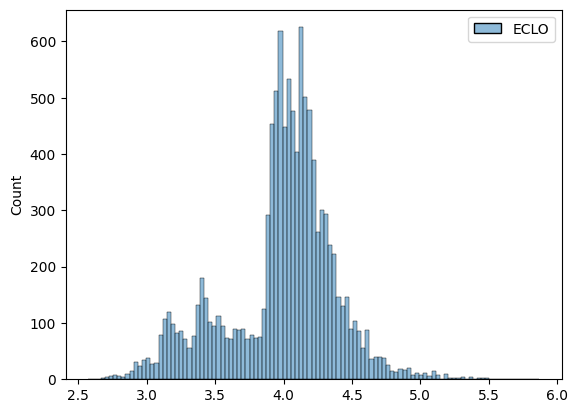

In [ ]:
sns.histplot(submission_df)

# Model_4[]

In [ ]:
test_x = test_df[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'설치형태_한전주','시간','설치개수','설치개수평균','주차구획수',
                  '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도', '제한속도']].copy()
train_x = train_df[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'설치형태_한전주','시간','설치개수','설치개수평균','주차구획수',
                  '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도', '제한속도']].copy()
train_y = train_df['ECLO'].copy()

In [ ]:
def one_hot(df):

    # one-hot encoding 실시
    df = pd.get_dummies(df)

    return df

In [ ]:
X_train_eng = one_hot(train_x)
X_test_eng = one_hot(test_x)

y_train = np.log(train_y)

In [ ]:
X_train_eng.fillna(0, inplace=True)
X_test_eng.fillna(0, inplace=True)

In [ ]:
print(f'X_train 데이터 shape : {X_train_eng.shape}')
print(f'y_train 데이터 shape : {y_train.shape}')
print()
print(f'X_test 데이터 shape : {X_test_eng.shape}')

X_train 데이터 shape : (39609, 38)
y_train 데이터 shape : (39609,)

X_test 데이터 shape : (10963, 38)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_eng, y_train , test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

## 다중공산성정리

In [ ]:
# from sklearn.decomposition import PCA

# reset_seeds()

# pca = PCA(n_components=1, random_state=args.SEED)

# pca_temp = pca.fit_transform(pre_train[['temp', 'atemp']])
# # pre_train = pre_train.drop(['temp', 'atemp'], axis=1)
# pre_train['pca_temp'] = pca_temp

# pca_temp = pca.transform(pre_test[['temp', 'atemp']])
# # pre_test = pre_test.drop(['temp', 'atemp'], axis=1)
# pre_test['pca_temp'] = pca_temp

# pre_train.shape, pre_test.shape

## rmsle

In [ ]:
import numpy as np

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

from sklearn.metrics import make_scorer

# RMSLE를 평가 지표로 변환
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [ ]:
def rmsle(y_real, y_pre):
    log1 = np.log1p(y_real)
    log2 = np.log1p(y_pre)
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

## LGBMRegressor

In [ ]:
from sklearn import metrics
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor()
def LGB_model():
    lgb_parameters = {'random_state': [42],
                  'n_estimators': [300, 370, 400],
                  'max_depth': [4, 5],
                  'learning_rate': [0.01]}
    rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better = False)

    gs = GridSearchCV(estimator = lgb_model, param_grid = lgb_parameters, scoring = rmsle_scorer, cv = 5)
    gs.fit(X_train, y_train)
    print('Best params for LGBoost model are: ', gs.best_params_)
    # predict
    test_pred = gs.predict(X_val)

    # train


    # test
    test_pred1 = np.exp(test_pred)
    yd_test = np.exp(y_val)

    # calculate RMSLE
    score = rmsle(yd_test,test_pred1)
    return score

## XGBRegressor

In [ ]:
import xgboost as xgb


xgb_model = xgb.XGBRegressor()
def XGB_model():
    xgb_parameters = {'random_state': [42],
                  'n_estimators': [300, 370, 400],
                  'max_depth': [4, 5],
                  'learning_rate': [0.01]}
    rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better = False)

    gs = GridSearchCV(estimator = xgb_model, param_grid = xgb_parameters, scoring = rmsle_scorer, cv = 5)
    gs.fit(X_train, y_train)
    print('Best params for XGBoost model are: ', gs.best_params_)
    #
    test_pred = gs.predict(X_val)

    # test
    test_pred1 = np.exp(test_pred)
    yd_test = np.exp(y_val)

    # calculate RMSLE
    score = rmsle(yd_test,test_pred1)
    return score

## RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
def RandomForest_model():
    params = {'n_estimators': 1000,
              'max_depth': 15,
              'random_state': 0,
              'min_samples_split' : 2,
              'n_jobs': -1}

    rfr = RandomForestRegressor(**params)
    rfr.fit(X_train, y_train)
    test_pred = rfr.predict(X_val)

    # test
    test_pred1 = np.exp(test_pred)
    yd_test = np.exp(y_val)

    # calculate RMSLE
    score = rmsle(yd_test,test_pred1)
    return score

## GradientBoostingRegressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
def GradientBoosting_model():
    gbr = GradientBoostingRegressor(n_estimators = 1000,
                                    max_depth = 5,
                                    random_state = 0)
    gbr.fit(X_train, y_train)
    test_pred = gbr.predict(X_val)

    # test
    test_pred1 = np.exp(test_pred)
    yd_test = np.exp(y_val)

    # calculate RMSLE
    score = rmsle(yd_test,test_pred1)
    return score

In [ ]:
print("RMSLE Score for different models")
print("LGBoost:      ",LGB_model())
print("XGBoost:      ",XGB_model())
print("RandomForest: ",RandomForest_model())
print("GradientBoost: ",GradientBoosting_model())

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 678
[LightGBM] [Info] Number of data points in the train set: 25349, number of used features: 34
[LightGBM] [Info] Start training from score 1.386939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

## prediction

In [ ]:
def prediction(x_test, models):
    prediction = []
    for model in models:
        pre = model.predict(x_test)
        pre = np.expm1(pre)
        prediction.append(pre)
    return sum(prediction)

In [ ]:
pred_xgb = prediction(gb_x_test, models=[XGB1, XGB2])
pred_gbr = prediction(gb_x_test, models=[GBR1, GBR2])

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(10,5)

sns.histplot(pred_xgb, bins=1, ax=ax1)
sns.histplot(pred_gbr, bins=1, ax=ax2)

In [ ]:
prediction = (0.6 * pred_xgb) + (0.4 * pred_gbr)

# Model_5 [0.42799]

In [ ]:
train_df.columns

Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간',
       '도시', '구', '동', '도로형태1', '도로형태2', '설치형태_건축물', '설치형태_전용주', '설치형태_한전주',
       '설치개수', '설치개수평균', '시설종류_어린이집', '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교',
       '시설종류_학원', '관할경찰서명_강북경찰서', '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서',
       '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서', '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서',
       '관할경찰서명_수성경찰서', 'CCTV설치여부_N', 'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수',
       'CCTV설치대수평균', '급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료',
       '결제방법_신용카드', '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도'],
      dtype='object')

In [ ]:
test_x = test_df[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'설치형태_한전주','시간','설치개수','설치개수평균','주차구획수','급지구분_1', '급지구분_2', '급지구분_3'
                  ,'주차기본요금','설치연도', '제한속도','동']].copy()
train_x = train_df[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'설치형태_한전주','시간','설치개수','설치개수평균','주차구획수','급지구분_1', '급지구분_2', '급지구분_3'
                  ,'주차기본요금','설치연도', '제한속도','동']].copy()
train_y = train_df['ECLO'].copy()

In [ ]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   요일        39609 non-null  object 
 1   노면상태      39609 non-null  object 
 2   사고유형      39609 non-null  object 
 3   도로형태2     39609 non-null  object 
 4   설치형태_건축물  30096 non-null  float64
 5   설치형태_전용주  30096 non-null  float64
 6   설치형태_한전주  30096 non-null  float64
 7   시간        39609 non-null  int64  
 8   설치개수      30096 non-null  float64
 9   설치개수평균    30096 non-null  float64
 10  주차구획수     33066 non-null  float64
 11  급지구분_1    33066 non-null  float64
 12  급지구분_2    33066 non-null  float64
 13  급지구분_3    33066 non-null  float64
 14  주차기본요금    33066 non-null  float64
 15  설치연도      38033 non-null  float64
 16  제한속도      38033 non-null  float64
 17  동         39609 non-null  object 
dtypes: float64(12), int64(1), object(5)
memory usage: 5.7+ MB


In [ ]:
le = TargetEncoder(cols=['동'])
train_x['동'] = le.fit_transform(train_x['동'], train_y)
test_x['동'] = le.transform(test_x['동'])

In [ ]:
def one_hot(df):

    # one-hot encoding 실시
    df = pd.get_dummies(df)

    return df

In [ ]:
X_train_eng = one_hot(train_x)
X_test_eng = one_hot(test_x)

y_train = np.log(train_y)

In [ ]:
X_train_eng.fillna(0, inplace=True)
X_test_eng.fillna(0, inplace=True)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1, random_state=42)

pca_temp = pca.fit_transform(X_train_eng[['설치형태_건축물', '설치형태_한전주','설치개수']])
X_train_eng = X_train_eng.drop(['설치형태_건축물', '설치형태_한전주','설치개수'], axis=1)
X_train_eng['건축_한전_개수'] = pca_temp

pca_temp = pca.fit_transform(X_test_eng[['설치형태_건축물', '설치형태_한전주','설치개수']])
X_test_eng = X_test_eng.drop(['설치형태_건축물', '설치형태_한전주','설치개수'], axis=1)
X_test_eng['건축_한전_개수'] = pca_temp

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1, random_state=42)

pca_temp = pca.fit_transform(X_train_eng[['급지구분_1', '급지구분_2', '급지구분_3']])
X_train_eng = X_train_eng.drop(['급지구분_1', '급지구분_2', '급지구분_3'], axis=1)
X_train_eng['급지구분'] = pca_temp

pca_temp = pca.fit_transform(X_test_eng[['급지구분_1', '급지구분_2', '급지구분_3']])
X_test_eng = X_test_eng.drop(['급지구분_1', '급지구분_2', '급지구분_3'], axis=1)
X_test_eng['급지구분'] = pca_temp

In [ ]:
print(f'X_train 데이터 shape : {X_train_eng.shape}')
print(f'y_train 데이터 shape : {y_train.shape}')
print()
print(f'X_test 데이터 shape : {X_test_eng.shape}')

X_train 데이터 shape : (39609, 36)
y_train 데이터 shape : (39609,)

X_test 데이터 shape : (10963, 36)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_eng, y_train , test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
import numpy as np

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

from sklearn.metrics import make_scorer

# RMSLE를 평가 지표로 변환
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

## LGBMRegressor 모델

In [ ]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# LGBM Regressor 모델 생성
lgbm = LGBMRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [300, 400, 500, 800, 1200]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_lgbm.best_params_)
print("최적의 점수:", grid_search_lgbm.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
lgbm_best = LGBMRegressor(**grid_search_lgbm.best_params_,random_state=42)

# 모델 학습
lgbm_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = lgbm_best.predict(X_train)
y_val_pred = lgbm_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 789
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 32
[LightGBM] [Info] Start training from score 1.383856
최적의 하이퍼파라미터: {'learning_rate': 0.01, 'n_estimators': 400, 'num_leaves': 10}
최적의 점수: 0.03487796378500104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 789
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 32
[LightGBM] [Info] Start training from score 1.383856
0.44224167766896033
0.4446425362074012


## RandomForestRegressor 모델

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

# Random Forest Regressor 모델 생성
rf = RandomForestRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [8, 10, 12]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_rf.best_params_)
print("최적의 점수:", grid_search_rf.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
rf_best = RandomForestRegressor(**grid_search_rf.best_params_,random_state=42)

# 모델 학습
rf_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = rf_best.predict(X_train)
y_val_pred = rf_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'max_depth': 10, 'min_samples_split': 12, 'n_estimators': 300}
최적의 점수: 0.02905730008062653
0.4263241699520474
0.44625352016959674


## XGBRegressor 모델

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# XGB Regressor 모델 생성
xgb = XGBRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_xgb.best_params_)
print("최적의 점수:", grid_search_xgb.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
xgb_best = XGBRegressor(**grid_search_xgb.best_params_,random_state=42)

# 모델 학습
xgb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = xgb_best.predict(X_train)
y_val_pred = xgb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
최적의 점수: 0.03495276617492423
0.4428901901779094
0.44498612817242994


## GradientBoosting

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
model = GradientBoostingRegressor()

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],  # 트리 개수
    'learning_rate': [0.01, 0.1, 0.2],  # 학습률
    'max_depth': [3, 4, 5]  # 트리 최대 깊이
}

# GridSearchCV를 사용하여 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

gb_best = grid_search.best_estimator_

gb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = gb_best.predict(X_train)
y_val_pred = gb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

0.44275006029965325
0.4449663995910588


## Stack

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

In [ ]:
# 개별 모델 생성
rf = rf_best
lgbm = lgbm_best
xgb = xgb_best
gb = gb_best


# 스태킹 앙상블 모델 생성
estimators = [
    ('rf', rf),
    ('lgbm', lgbm),
    ('xgb', xgb),
    ('gb', gb)
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# 모델 학습
stacking_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = stacking_model.predict(X_train)
y_val_pred = stacking_model.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 789
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 32
[LightGBM] [Info] Start training from score 1.383856
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 25349, number of used features: 32
[LightGBM] [Info] Start training from score 1.386939
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

In [ ]:
y_pred1 = stacking_model.predict(X_test_eng)
y_pred1

array([1.33100508, 1.24639403, 1.55069418, ..., 1.53551399, 1.49527669,
       1.50777673])

In [ ]:
y_pred = np.exp(y_pred1)
y_pred

array([3.78484554, 3.47777955, 4.71474195, ..., 4.64371172, 4.46057057,
       4.51667784])

In [ ]:
submission_df['ECLO'] = y_pred
submission_df.head()

,ID,ECLO
0,ACCIDENT_39609,3.784846
1,ACCIDENT_39610,3.477780
2,ACCIDENT_39611,4.714742
3,ACCIDENT_39612,4.032681
4,ACCIDENT_39613,4.478879


<Axes: ylabel='Count'>

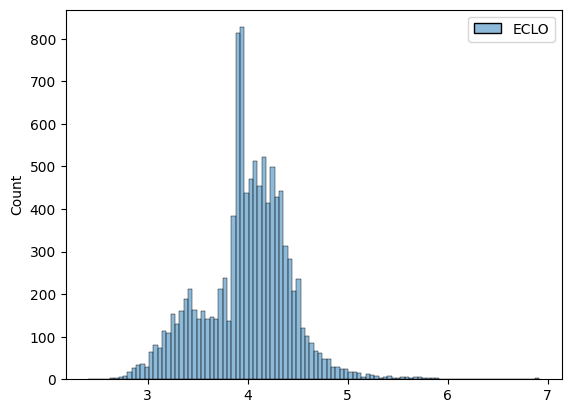

In [ ]:
sns.histplot(submission_df)

In [ ]:
submission_df.to_csv('/content/drive/MyDrive/[Stacking]컬럼수정및추가.csv', index=False)

# Model_6 []

In [ ]:
train_df.columns

Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간',
       '도시', '구', '동', '도로형태1', '도로형태2', '설치형태_건축물', '설치형태_전용주', '설치형태_한전주',
       '설치개수', '설치개수평균', '시설종류_어린이집', '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교',
       '시설종류_학원', '관할경찰서명_강북경찰서', '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서',
       '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서', '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서',
       '관할경찰서명_수성경찰서', 'CCTV설치여부_N', 'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수',
       'CCTV설치대수평균', '급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료',
       '결제방법_신용카드', '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도'],
      dtype='object')

In [ ]:
test_x = test_df[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'설치형태_한전주','시간','설치개수','설치개수평균','주차구획수'
                  ,'주차기본요금','설치연도', '제한속도','동']].copy()
train_x = train_df[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'설치형태_한전주','시간','설치개수','설치개수평균','주차구획수'
                  ,'주차기본요금','설치연도', '제한속도','동']].copy()
train_y = train_df['ECLO'].copy()

In [ ]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   요일        39609 non-null  object 
 1   노면상태      39609 non-null  object 
 2   사고유형      39609 non-null  object 
 3   도로형태2     39609 non-null  object 
 4   설치형태_건축물  30096 non-null  float64
 5   설치형태_전용주  30096 non-null  float64
 6   설치형태_한전주  30096 non-null  float64
 7   시간        39609 non-null  int64  
 8   설치개수      30096 non-null  float64
 9   설치개수평균    30096 non-null  float64
 10  주차구획수     33066 non-null  float64
 11  주차기본요금    33066 non-null  float64
 12  설치연도      38033 non-null  float64
 13  제한속도      38033 non-null  float64
 14  동         39609 non-null  object 
dtypes: float64(9), int64(1), object(5)
memory usage: 4.8+ MB


In [ ]:
le = TargetEncoder(cols=['동'])
train_x['동'] = le.fit_transform(train_x['동'], train_y)
test_x['동'] = le.transform(test_x['동'])

In [ ]:
def one_hot(df):

    # one-hot encoding 실시
    df = pd.get_dummies(df)

    return df

In [ ]:
X_train_eng = one_hot(train_x)
X_test_eng = one_hot(test_x)

y_train = np.log(train_y)

In [ ]:
X_train_eng.fillna(0, inplace=True)
X_test_eng.fillna(0, inplace=True)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1, random_state=42)

pca_temp = pca.fit_transform(X_train_eng[['설치형태_건축물', '설치형태_한전주','설치개수']])
X_train_eng = X_train_eng.drop(['설치형태_건축물', '설치형태_한전주','설치개수'], axis=1)
X_train_eng['건축_한전_개수'] = pca_temp

pca_temp = pca.fit_transform(X_test_eng[['설치형태_건축물', '설치형태_한전주','설치개수']])
X_test_eng = X_test_eng.drop(['설치형태_건축물', '설치형태_한전주','설치개수'], axis=1)
X_test_eng['건축_한전_개수'] = pca_temp

In [ ]:
print(f'X_train 데이터 shape : {X_train_eng.shape}')
print(f'y_train 데이터 shape : {y_train.shape}')
print()
print(f'X_test 데이터 shape : {X_test_eng.shape}')

X_train 데이터 shape : (39609, 35)
y_train 데이터 shape : (39609,)

X_test 데이터 shape : (10963, 35)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_eng, y_train , test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
import numpy as np

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

from sklearn.metrics import make_scorer

# RMSLE를 평가 지표로 변환
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

## LGBMRegressor 모델

In [ ]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# LGBM Regressor 모델 생성
lgbm = LGBMRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [300, 400, 500, 800, 1200]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_lgbm.best_params_)
print("최적의 점수:", grid_search_lgbm.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
lgbm_best = LGBMRegressor(**grid_search_lgbm.best_params_,random_state=42)

# 모델 학습
lgbm_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = lgbm_best.predict(X_train)
y_val_pred = lgbm_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 741
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 31
[LightGBM] [Info] Start training from score 1.383856
최적의 하이퍼파라미터: {'learning_rate': 0.01, 'n_estimators': 400, 'num_leaves': 10}
최적의 점수: 0.034578382643835094
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 741
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 31
[LightGBM] [Info] Start training from score 1.383856
0.44233193581222635
0.44469390070854686


## RandomForestRegressor 모델

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

# Random Forest Regressor 모델 생성
rf = RandomForestRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [8, 10, 12]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_rf.best_params_)
print("최적의 점수:", grid_search_rf.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
rf_best = RandomForestRegressor(**grid_search_rf.best_params_,random_state=42)

# 모델 학습
rf_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = rf_best.predict(X_train)
y_val_pred = rf_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'max_depth': 10, 'min_samples_split': 12, 'n_estimators': 300}
최적의 점수: 0.029063544121510316
0.42640125084269165
0.44634489337103667


## XGBRegressor 모델

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# XGB Regressor 모델 생성
xgb = XGBRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_xgb.best_params_)
print("최적의 점수:", grid_search_xgb.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
xgb_best = XGBRegressor(**grid_search_xgb.best_params_,random_state=42)

# 모델 학습
xgb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = xgb_best.predict(X_train)
y_val_pred = xgb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
최적의 점수: 0.034888558358278275
0.44294271394685786
0.44498975422509474


## GradientBoosting

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
model = GradientBoostingRegressor()

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],  # 트리 개수
    'learning_rate': [0.01, 0.1, 0.2],  # 학습률
    'max_depth': [3, 4, 5]  # 트리 최대 깊이
}

# GridSearchCV를 사용하여 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

gb_best = grid_search.best_estimator_

gb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = gb_best.predict(X_train)
y_val_pred = gb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

0.44274339560961773
0.44498914623347635


## Stack

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

In [ ]:
# 개별 모델 생성
rf = rf_best
lgbm = lgbm_best
xgb = xgb_best
gb = gb_best


# 스태킹 앙상블 모델 생성
estimators = [
    ('rf', rf),
    ('lgbm', lgbm),
    ('xgb', xgb),
    ('gb', gb)
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# 모델 학습
stacking_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = stacking_model.predict(X_train)
y_val_pred = stacking_model.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 741
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 31
[LightGBM] [Info] Start training from score 1.383856
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 25349, number of used features: 31
[LightGBM] [Info] Start training from score 1.386939
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 730
[LightGBM] [Info] Number of data points in the train set: 2

In [ ]:
y_pred1 = stacking_model.predict(X_test_eng)
y_pred1

array([1.34133567, 1.24726667, 1.54091113, ..., 1.52350004, 1.49312764,
       1.5063429 ])

In [ ]:
y_pred = np.exp(y_pred1)
y_pred

array([3.8241479 , 3.48081572, 4.66884224, ..., 4.58825621, 4.45099489,
       4.51020631])

In [ ]:
submission_df['ECLO'] = y_pred
submission_df.head()

,ID,ECLO
0,ACCIDENT_39609,3.824148
1,ACCIDENT_39610,3.480816
2,ACCIDENT_39611,4.668842
3,ACCIDENT_39612,4.030503
4,ACCIDENT_39613,4.472119


<Axes: ylabel='Count'>

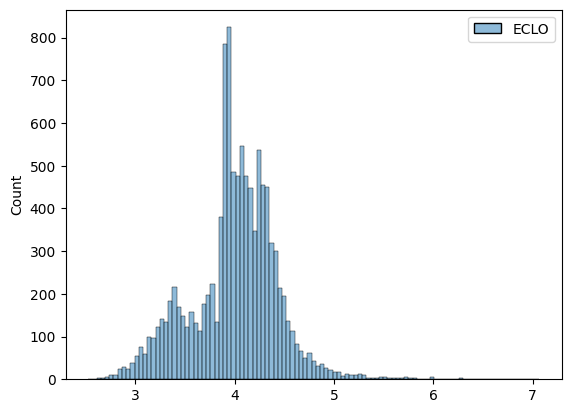

In [ ]:
sns.histplot(submission_df)

# Model_7 [0.42785]

In [ ]:
train_df.columns

Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간',
       '도시', '구', '동', '도로형태1', '도로형태2', '설치형태_건축물', '설치형태_전용주', '설치형태_한전주',
       '설치개수', '설치개수평균', '시설종류_어린이집', '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교',
       '시설종류_학원', '관할경찰서명_강북경찰서', '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서',
       '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서', '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서',
       '관할경찰서명_수성경찰서', 'CCTV설치여부_N', 'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수',
       'CCTV설치대수평균', '급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료',
       '결제방법_신용카드', '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도'],
      dtype='object')

In [ ]:
test_x = test_df[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'설치형태_한전주','시간','설치개수','설치개수평균','주차구획수'
                  ,'주차기본요금','설치연도', '제한속도']].copy()
train_x = train_df[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'설치형태_한전주','시간','설치개수','설치개수평균','주차구획수'
                  ,'주차기본요금','설치연도', '제한속도']].copy()
train_y = train_df['ECLO'].copy()

In [ ]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   요일        39609 non-null  object 
 1   노면상태      39609 non-null  object 
 2   사고유형      39609 non-null  object 
 3   도로형태2     39609 non-null  object 
 4   설치형태_건축물  30096 non-null  float64
 5   설치형태_전용주  30096 non-null  float64
 6   설치형태_한전주  30096 non-null  float64
 7   시간        39609 non-null  int64  
 8   설치개수      30096 non-null  float64
 9   설치개수평균    30096 non-null  float64
 10  주차구획수     33066 non-null  float64
 11  주차기본요금    33066 non-null  float64
 12  설치연도      38033 non-null  float64
 13  제한속도      38033 non-null  float64
dtypes: float64(9), int64(1), object(4)
memory usage: 4.5+ MB


In [ ]:
def one_hot(df):

    # one-hot encoding 실시
    df = pd.get_dummies(df)

    return df

In [ ]:
X_train_eng = one_hot(train_x)
X_test_eng = one_hot(test_x)

y_train = np.log(train_y)

In [ ]:
X_train_eng.fillna(0, inplace=True)
X_test_eng.fillna(0, inplace=True)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1, random_state=42)

pca_temp = pca.fit_transform(X_train_eng[['설치형태_건축물', '설치형태_한전주','설치개수']])
X_train_eng = X_train_eng.drop(['설치형태_건축물', '설치형태_한전주','설치개수'], axis=1)
X_train_eng['건축_한전_개수'] = pca_temp

pca_temp = pca.fit_transform(X_test_eng[['설치형태_건축물', '설치형태_한전주','설치개수']])
X_test_eng = X_test_eng.drop(['설치형태_건축물', '설치형태_한전주','설치개수'], axis=1)
X_test_eng['건축_한전_개수'] = pca_temp

In [ ]:
print(f'X_train 데이터 shape : {X_train_eng.shape}')
print(f'y_train 데이터 shape : {y_train.shape}')
print()
print(f'X_test 데이터 shape : {X_test_eng.shape}')

X_train 데이터 shape : (39609, 34)
y_train 데이터 shape : (39609,)

X_test 데이터 shape : (10963, 34)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_eng, y_train , test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
import numpy as np

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

from sklearn.metrics import make_scorer

# RMSLE를 평가 지표로 변환
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

## LGBMRegressor 모델

In [ ]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# LGBM Regressor 모델 생성
lgbm = LGBMRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [300, 400, 500, 800, 1200]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_lgbm.best_params_)
print("최적의 점수:", grid_search_lgbm.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
lgbm_best = LGBMRegressor(**grid_search_lgbm.best_params_,random_state=42)

# 모델 학습
lgbm_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = lgbm_best.predict(X_train)
y_val_pred = lgbm_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 30
[LightGBM] [Info] Start training from score 1.383856
최적의 하이퍼파라미터: {'learning_rate': 0.01, 'n_estimators': 400, 'num_leaves': 10}
최적의 점수: 0.0298600226486051
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 30
[LightGBM] [Info] Start training from score 1.383856
0.44365780489927015
0.4458139145901633


## RandomForestRegressor 모델

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

# Random Forest Regressor 모델 생성
rf = RandomForestRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [8, 10, 12]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_rf.best_params_)
print("최적의 점수:", grid_search_rf.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
rf_best = RandomForestRegressor(**grid_search_rf.best_params_,random_state=42)

# 모델 학습
rf_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = rf_best.predict(X_train)
y_val_pred = rf_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'max_depth': 10, 'min_samples_split': 12, 'n_estimators': 300}
최적의 점수: 0.025518486468029605
0.42853476155178766
0.4475883996921828


## XGBRegressor 모델

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# XGB Regressor 모델 생성
xgb = XGBRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_xgb.best_params_)
print("최적의 점수:", grid_search_xgb.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
xgb_best = XGBRegressor(**grid_search_xgb.best_params_,random_state=42)

# 모델 학습
xgb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = xgb_best.predict(X_train)
y_val_pred = xgb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
최적의 점수: 0.030604947524018027
0.44428286703830455
0.44613951514831796


## GradientBoosting

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
model = GradientBoostingRegressor()

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],  # 트리 개수
    'learning_rate': [0.01, 0.1, 0.2],  # 학습률
    'max_depth': [3, 4, 5]  # 트리 최대 깊이
}

# GridSearchCV를 사용하여 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

gb_best = grid_search.best_estimator_

gb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = gb_best.predict(X_train)
y_val_pred = gb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

0.4441534191645763
0.44613165231816754


## Stack

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

In [ ]:
# 개별 모델 생성
rf = rf_best
lgbm = lgbm_best
xgb = xgb_best
gb = gb_best


# 스태킹 앙상블 모델 생성
estimators = [
    ('rf', rf),
    ('lgbm', lgbm),
    ('xgb', xgb),
    ('gb', gb)
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# 모델 학습
stacking_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = stacking_model.predict(X_train)
y_val_pred = stacking_model.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 30
[LightGBM] [Info] Start training from score 1.383856
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 25349, number of used features: 30
[LightGBM] [Info] Start training from score 1.386939
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 548
[LightGBM] [Info] Number of data points in the train set: 25349, number of used features: 30
[LightGBM] [Info] Start traini

In [ ]:
y_pred1 = stacking_model.predict(X_test_eng)
y_pred1

array([1.31409727, 1.24287221, 1.53571388, ..., 1.43835562, 1.45723918,
       1.49348813])

In [ ]:
y_pred = np.exp(y_pred1)
y_pred

array([3.72139005, 3.46555298, 4.64464007, ..., 4.21376111, 4.29408793,
       4.45259969])

In [ ]:
submission_df['ECLO'] = y_pred
submission_df.head()

,ID,ECLO
0,ACCIDENT_39609,3.721390
1,ACCIDENT_39610,3.465553
2,ACCIDENT_39611,4.644640
3,ACCIDENT_39612,4.147608
4,ACCIDENT_39613,4.373789


<Axes: ylabel='Count'>

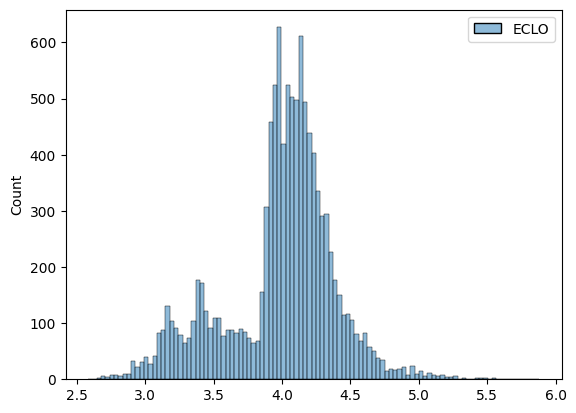

In [ ]:
sns.histplot(submission_df)

In [ ]:
submission_df.to_csv('/content/drive/MyDrive/[Stacking]전에모델PCA.csv', index=False)

# Model_8 []

In [ ]:
train_df.columns

Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간',
       '도시', '구', '동', '도로형태1', '도로형태2', '설치형태_건축물', '설치형태_전용주', '설치형태_한전주',
       '설치개수', '설치개수평균', '시설종류_어린이집', '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교',
       '시설종류_학원', '관할경찰서명_강북경찰서', '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서',
       '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서', '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서',
       '관할경찰서명_수성경찰서', 'CCTV설치여부_N', 'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수',
       'CCTV설치대수평균', '급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료',
       '결제방법_신용카드', '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도'],
      dtype='object')

In [ ]:
test_x = test_df[[ '도로형태','노면상태','사고유형','동','설치형태_건축물','설치형태_전용주','설치형태_한전주',
          '설치개수','주차장구분_민영','주차장유형_노외','주차구획수','주차구획수평균','주차기본요금','추가단위요금','1일주차권요금',
          '월정기권요금','설치연도','제한속도']].copy()
train_x = train_df[[ '도로형태','노면상태','사고유형','동','설치형태_건축물','설치형태_전용주','설치형태_한전주',
          '설치개수','주차장구분_민영','주차장유형_노외','주차구획수','주차구획수평균','주차기본요금','추가단위요금','1일주차권요금',
          '월정기권요금','설치연도','제한속도']].copy()
train_y = train_df['ECLO'].copy()

In [ ]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   도로형태      39609 non-null  object 
 1   노면상태      39609 non-null  object 
 2   사고유형      39609 non-null  object 
 3   동         39609 non-null  object 
 4   설치형태_건축물  30096 non-null  float64
 5   설치형태_전용주  30096 non-null  float64
 6   설치형태_한전주  30096 non-null  float64
 7   설치개수      30096 non-null  float64
 8   주차장구분_민영  33066 non-null  float64
 9   주차장유형_노외  33066 non-null  float64
 10  주차구획수     33066 non-null  float64
 11  주차구획수평균   33066 non-null  float64
 12  주차기본요금    33066 non-null  float64
 13  추가단위요금    24540 non-null  float64
 14  1일주차권요금   23141 non-null  float64
 15  월정기권요금    22398 non-null  float64
 16  설치연도      38033 non-null  float64
 17  제한속도      38033 non-null  float64
dtypes: float64(14), object(4)
memory usage: 5.7+ MB


In [ ]:
le = TargetEncoder(cols=['동'])
train_x['동'] = le.fit_transform(train_x['동'], train_y)
test_x['동'] = le.transform(test_x['동'])

In [ ]:
def one_hot(df):

    # one-hot encoding 실시
    df = pd.get_dummies(df)

    return df

In [ ]:
X_train_eng = one_hot(train_x)
X_test_eng = one_hot(test_x)

y_train = np.log(train_y)

In [ ]:
X_train_eng.fillna(0, inplace=True)
X_test_eng.fillna(0, inplace=True)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1, random_state=42)

pca_temp = pca.fit_transform(X_train_eng[['설치형태_건축물', '설치형태_한전주','설치개수']])
X_train_eng = X_train_eng.drop(['설치형태_건축물', '설치형태_한전주','설치개수'], axis=1)
X_train_eng['건축_한전_개수'] = pca_temp

pca_temp = pca.fit_transform(X_test_eng[['설치형태_건축물', '설치형태_한전주','설치개수']])
X_test_eng = X_test_eng.drop(['설치형태_건축물', '설치형태_한전주','설치개수'], axis=1)
X_test_eng['건축_한전_개수'] = pca_temp

In [ ]:
print(f'X_train 데이터 shape : {X_train_eng.shape}')
print(f'y_train 데이터 shape : {y_train.shape}')
print()
print(f'X_test 데이터 shape : {X_test_eng.shape}')

X_train 데이터 shape : (39609, 33)
y_train 데이터 shape : (39609,)

X_test 데이터 shape : (10963, 33)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_eng, y_train , test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
import numpy as np

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

from sklearn.metrics import make_scorer

# RMSLE를 평가 지표로 변환
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

## LGBMRegressor 모델

In [ ]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# LGBM Regressor 모델 생성
lgbm = LGBMRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [300, 400, 500, 800, 1200]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_lgbm.best_params_)
print("최적의 점수:", grid_search_lgbm.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
lgbm_best = LGBMRegressor(**grid_search_lgbm.best_params_,random_state=42)

# 모델 학습
lgbm_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = lgbm_best.predict(X_train)
y_val_pred = lgbm_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 910
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 29
[LightGBM] [Info] Start training from score 1.383856
최적의 하이퍼파라미터: {'learning_rate': 0.01, 'n_estimators': 400, 'num_leaves': 10}
최적의 점수: 0.030907540830550768
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 910
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 29
[LightGBM] [Info] Start training from score 1.383856
0.44395246822624584
0.4464353616224868


## RandomForestRegressor 모델

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

# Random Forest Regressor 모델 생성
rf = RandomForestRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [8, 10, 12]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_rf.best_params_)
print("최적의 점수:", grid_search_rf.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
rf_best = RandomForestRegressor(**grid_search_rf.best_params_,random_state=42)

# 모델 학습
rf_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = rf_best.predict(X_train)
y_val_pred = rf_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'max_depth': 10, 'min_samples_split': 12, 'n_estimators': 200}
최적의 점수: 0.022493973831000085
0.43703930886928755
0.4483062778268646


## XGBRegressor 모델

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# XGB Regressor 모델 생성
xgb = XGBRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_xgb.best_params_)
print("최적의 점수:", grid_search_xgb.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
xgb_best = XGBRegressor(**grid_search_xgb.best_params_,random_state=42)

# 모델 학습
xgb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = xgb_best.predict(X_train)
y_val_pred = xgb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 400}
최적의 점수: 0.031027714654640604
0.4434202462580213
0.44658840861536986


## GradientBoosting

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
model = GradientBoostingRegressor()

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],  # 트리 개수
    'learning_rate': [0.01, 0.1, 0.2],  # 학습률
    'max_depth': [3, 4, 5]  # 트리 최대 깊이
}

# GridSearchCV를 사용하여 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

gb_best = grid_search.best_estimator_

gb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = gb_best.predict(X_train)
y_val_pred = gb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

0.44426784093198574
0.4463063311168419


## Stack

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

In [ ]:
# 개별 모델 생성
rf = rf_best
lgbm = lgbm_best
xgb = xgb_best
gb = gb_best


# 스태킹 앙상블 모델 생성
estimators = [
    ('rf', rf),
    ('lgbm', lgbm),
    ('xgb', xgb),
    ('gb', gb)
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# 모델 학습
stacking_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = stacking_model.predict(X_train)
y_val_pred = stacking_model.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 910
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 29
[LightGBM] [Info] Start training from score 1.383856
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 907
[LightGBM] [Info] Number of data points in the train set: 25349, number of used features: 29
[LightGBM] [Info] Start training from score 1.386939
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [In

In [ ]:
y_pred1 = stacking_model.predict(X_test_eng)
y_pred1

array([1.32114286, 1.23702803, 1.48976135, ..., 1.52563821, 1.47992605,
       1.4560962 ])

In [ ]:
y_pred = np.exp(y_pred1)
y_pred

array([3.74770203, 3.44535872, 4.43603672, ..., 4.59807718, 4.39262082,
       4.2891827 ])

In [ ]:
submission_df['ECLO'] = y_pred
submission_df.head()

,ID,ECLO
0,ACCIDENT_39609,3.747702
1,ACCIDENT_39610,3.445359
2,ACCIDENT_39611,4.436037
3,ACCIDENT_39612,3.981047
4,ACCIDENT_39613,4.367745


<Axes: ylabel='Count'>

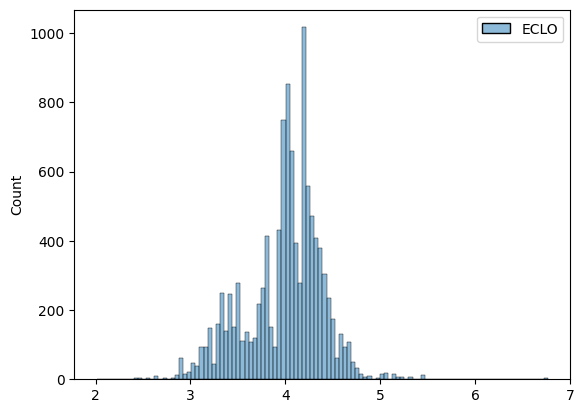

In [ ]:
sns.histplot(submission_df)

# Model_9 []

In [ ]:
train_df.columns

Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간',
       '도시', '구', '동', '도로형태1', '도로형태2', '설치형태_건축물', '설치형태_전용주', '설치형태_한전주',
       '설치개수', '설치개수평균', '시설종류_어린이집', '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교',
       '시설종류_학원', '관할경찰서명_강북경찰서', '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서',
       '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서', '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서',
       '관할경찰서명_수성경찰서', 'CCTV설치여부_N', 'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수',
       'CCTV설치대수평균', '급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료',
       '결제방법_신용카드', '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도'],
      dtype='object')

In [ ]:
test_x = test_df[[ '요일','시간','도로형태','노면상태','사고유형','동','설치형태_건축물','설치형태_전용주','설치형태_한전주',
          '설치개수','주차장구분_민영','주차장유형_노외','주차구획수','주차구획수평균','주차기본요금','추가단위요금','1일주차권요금',
          '월정기권요금','설치연도','제한속도']].copy()
train_x = train_df[[ '요일','시간','도로형태','노면상태','사고유형','동','설치형태_건축물','설치형태_전용주','설치형태_한전주',
          '설치개수','주차장구분_민영','주차장유형_노외','주차구획수','주차구획수평균','주차기본요금','추가단위요금','1일주차권요금',
          '월정기권요금','설치연도','제한속도']].copy()
train_y = train_df['ECLO'].copy()

In [ ]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   요일        39609 non-null  object 
 1   시간        39609 non-null  int64  
 2   도로형태      39609 non-null  object 
 3   노면상태      39609 non-null  object 
 4   사고유형      39609 non-null  object 
 5   동         39609 non-null  object 
 6   설치형태_건축물  30096 non-null  float64
 7   설치형태_전용주  30096 non-null  float64
 8   설치형태_한전주  30096 non-null  float64
 9   설치개수      30096 non-null  float64
 10  주차장구분_민영  33066 non-null  float64
 11  주차장유형_노외  33066 non-null  float64
 12  주차구획수     33066 non-null  float64
 13  주차구획수평균   33066 non-null  float64
 14  주차기본요금    33066 non-null  float64
 15  추가단위요금    24540 non-null  float64
 16  1일주차권요금   23141 non-null  float64
 17  월정기권요금    22398 non-null  float64
 18  설치연도      38033 non-null  float64
 19  제한속도      38033 non-null  float64
dtypes: float64(14), int64(1), ob

In [ ]:
le = TargetEncoder(cols=['동'])
train_x['동'] = le.fit_transform(train_x['동'], train_y)
test_x['동'] = le.transform(test_x['동'])

In [ ]:
def one_hot(df):

    # one-hot encoding 실시
    df = pd.get_dummies(df)

    return df

In [ ]:
X_train_eng = one_hot(train_x)
X_test_eng = one_hot(test_x)

y_train = np.log(train_y)

In [ ]:
X_train_eng.fillna(0, inplace=True)
X_test_eng.fillna(0, inplace=True)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1, random_state=42)

pca_temp = pca.fit_transform(X_train_eng[['설치형태_건축물', '설치형태_한전주','설치개수']])
X_train_eng = X_train_eng.drop(['설치형태_건축물', '설치형태_한전주','설치개수'], axis=1)
X_train_eng['건축_한전_개수'] = pca_temp

pca_temp = pca.fit_transform(X_test_eng[['설치형태_건축물', '설치형태_한전주','설치개수']])
X_test_eng = X_test_eng.drop(['설치형태_건축물', '설치형태_한전주','설치개수'], axis=1)
X_test_eng['건축_한전_개수'] = pca_temp

In [ ]:
print(f'X_train 데이터 shape : {X_train_eng.shape}')
print(f'y_train 데이터 shape : {y_train.shape}')
print()
print(f'X_test 데이터 shape : {X_test_eng.shape}')

X_train 데이터 shape : (39609, 41)
y_train 데이터 shape : (39609,)

X_test 데이터 shape : (10963, 41)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_eng, y_train , test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
import numpy as np

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

from sklearn.metrics import make_scorer

# RMSLE를 평가 지표로 변환
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

## LGBMRegressor 모델

In [ ]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# LGBM Regressor 모델 생성
lgbm = LGBMRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [300, 400, 500, 800, 1200]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_lgbm.best_params_)
print("최적의 점수:", grid_search_lgbm.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
lgbm_best = LGBMRegressor(**grid_search_lgbm.best_params_,random_state=42)

# 모델 학습
lgbm_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = lgbm_best.predict(X_train)
y_val_pred = lgbm_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 948
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 37
[LightGBM] [Info] Start training from score 1.383856
최적의 하이퍼파라미터: {'learning_rate': 0.01, 'n_estimators': 400, 'num_leaves': 10}
최적의 점수: 0.03497936096231036
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 948
[LightGBM] [Info] Number of data points in the train set: 31687, number 

## RandomForestRegressor 모델

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

# Random Forest Regressor 모델 생성
rf = RandomForestRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [8, 10, 12]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_rf.best_params_)
print("최적의 점수:", grid_search_rf.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
rf_best = RandomForestRegressor(**grid_search_rf.best_params_,random_state=42)

# 모델 학습
rf_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = rf_best.predict(X_train)
y_val_pred = rf_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'max_depth': 10, 'min_samples_split': 12, 'n_estimators': 300}
최적의 점수: 0.02905947937107156
0.42690823674752526
0.4461625428053253


## XGBRegressor 모델

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# XGB Regressor 모델 생성
xgb = XGBRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_xgb.best_params_)
print("최적의 점수:", grid_search_xgb.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
xgb_best = XGBRegressor(**grid_search_xgb.best_params_,random_state=42)

# 모델 학습
xgb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = xgb_best.predict(X_train)
y_val_pred = xgb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 400}
최적의 점수: 0.03561021588741039
0.44129675514270544
0.4449485681868603


## GradientBoosting

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
model = GradientBoostingRegressor()

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],  # 트리 개수
    'learning_rate': [0.01, 0.1, 0.2],  # 학습률
    'max_depth': [3, 4, 5]  # 트리 최대 깊이
}

# GridSearchCV를 사용하여 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

gb_best = grid_search.best_estimator_

gb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = gb_best.predict(X_train)
y_val_pred = gb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

0.44264273850454916
0.44488360473098615


## Stack

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

In [ ]:
# 개별 모델 생성
rf = rf_best
lgbm = lgbm_best
xgb = xgb_best
gb = gb_best


# 스태킹 앙상블 모델 생성
estimators = [
    ('rf', rf),
    ('lgbm', lgbm),
    ('xgb', xgb),
    ('gb', gb)
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# 모델 학습
stacking_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = stacking_model.predict(X_train)
y_val_pred = stacking_model.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 948
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 37
[LightGBM] [Info] Start training from score 1.383856
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 25349, number of used features: 37
[LightGBM] [Info] Start training from score 1.386939
[LightGBM] [Warning] Found whi

In [ ]:
y_pred1 = stacking_model.predict(X_test_eng)
y_pred1

array([1.3243753 , 1.25197337, 1.54479668, ..., 1.52675656, 1.48837919,
       1.50043511])

In [ ]:
y_pred = np.exp(y_pred1)
y_pred

array([3.75983585, 3.49723748, 4.68701856, ..., 4.60322232, 4.42990965,
       4.48363952])

In [ ]:
submission_df['ECLO'] = y_pred
submission_df.head()

,ID,ECLO
0,ACCIDENT_39609,3.759836
1,ACCIDENT_39610,3.497237
2,ACCIDENT_39611,4.687019
3,ACCIDENT_39612,4.090657
4,ACCIDENT_39613,4.427783


<Axes: ylabel='Count'>

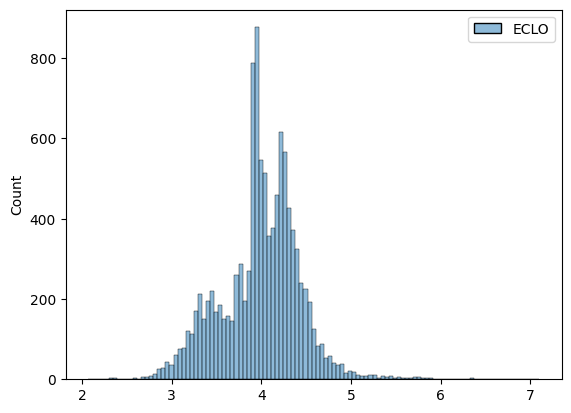

In [ ]:
sns.histplot(submission_df)

# Model_10 [0.42799]

In [ ]:
train_df.columns

Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간',
       '도시', '구', '동', '도로형태1', '도로형태2', '설치형태_건축물', '설치형태_전용주', '설치형태_한전주',
       '설치개수', '설치개수평균', '시설종류_어린이집', '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교',
       '시설종류_학원', '관할경찰서명_강북경찰서', '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서',
       '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서', '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서',
       '관할경찰서명_수성경찰서', 'CCTV설치여부_N', 'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수',
       'CCTV설치대수평균', '급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료',
       '결제방법_신용카드', '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도'],
      dtype='object')

In [ ]:
train = train_df.copy()
test = test_df.copy()

In [ ]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [ ]:
for i in  ['동','설치형태_한전주', '설치개수','주차구획수','주차구획수평균','제한속도']:
  _ant =  (train.groupby([i])['ECLO'].mean() < 4).astype(int)
  train = pd.merge(train, _ant, how='left', on=[i])
  test = pd.merge(test, _ant, how='left', on=[i])

  train.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)
  test.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)

  train = train.drop(columns=[i])
  test = test.drop(columns=[i])

In [ ]:
test.rename(columns={'ECLO':'new동'}, inplace=True)

In [ ]:
test_x = test[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'시간','설치개수평균', '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도',
                  'new동', 'new설치형태_한전주','new설치개수', 'new주차구획수', 'new주차구획수평균', 'new제한속도']].copy()
train_x = train[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'시간','설치개수평균', '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도',
                  'new동', 'new설치형태_한전주','new설치개수', 'new주차구획수', 'new주차구획수평균', 'new제한속도']].copy()
train_y = train['ECLO'].copy()

In [ ]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   요일            39609 non-null  object 
 1   노면상태          39609 non-null  object 
 2   사고유형          39609 non-null  object 
 3   도로형태2         39609 non-null  object 
 4   설치형태_건축물      39609 non-null  float64
 5   설치형태_전용주      39609 non-null  float64
 6   시간            39609 non-null  int64  
 7   설치개수평균        39609 non-null  float64
 8   관할경찰서명_달성경찰서  39609 non-null  float64
 9   CCTV설치여부_N    39609 non-null  float64
 10  주차기본요금        39609 non-null  float64
 11  설치연도          39609 non-null  float64
 12  new동          39609 non-null  int64  
 13  new설치형태_한전주   39609 non-null  int64  
 14  new설치개수       39609 non-null  int64  
 15  new주차구획수      39609 non-null  int64  
 16  new주차구획수평균    39609 non-null  int64  
 17  new제한속도       39609 non-null  int64  
dtypes: float64(7), int64(7), o

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1, random_state=42)

pca_temp = pca.fit_transform(train_x[['new동'	,'new설치형태_한전주'	,'new설치개수',	'new주차구획수']])
train_x = train_x.drop(['new동'	,'new설치형태_한전주'	,'new설치개수',	'new주차구획수'], axis=1)
train_x['new'] = pca_temp

pca_temp = pca.fit_transform(test_x[['new동'	,'new설치형태_한전주'	,'new설치개수',	'new주차구획수']])
test_x = test_x.drop(['new동'	,'new설치형태_한전주'	,'new설치개수',	'new주차구획수'], axis=1)
test_x['new'] = pca_temp

print(f'{train_x.shape} / {test_x.shape}')

(39609, 15) / (10963, 15)


In [ ]:
def one_hot(df):

    # one-hot encoding 실시
    df = pd.get_dummies(df)

    return df

In [ ]:
X_train_eng = one_hot(train_x)
X_test_eng = one_hot(test_x)

y_train = np.log(train_y)

In [ ]:
X_train_eng.fillna(0, inplace=True)
X_test_eng.fillna(0, inplace=True)

In [ ]:
print(f'X_train 데이터 shape : {X_train_eng.shape}')
print(f'y_train 데이터 shape : {y_train.shape}')
print()
print(f'X_test 데이터 shape : {X_test_eng.shape}')

X_train 데이터 shape : (39609, 37)
y_train 데이터 shape : (39609,)

X_test 데이터 shape : (10963, 37)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_eng, y_train , test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
import numpy as np

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

from sklearn.metrics import make_scorer

# RMSLE를 평가 지표로 변환
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

## LGBMRegressor 모델

In [ ]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# LGBM Regressor 모델 생성
lgbm = LGBMRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [300, 400, 500, 800, 1200]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_lgbm.best_params_)
print("최적의 점수:", grid_search_lgbm.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
lgbm_best = LGBMRegressor(**grid_search_lgbm.best_params_,random_state=42)

# 모델 학습
lgbm_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = lgbm_best.predict(X_train)
y_val_pred = lgbm_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 306
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 33
[LightGBM] [Info] Start training from score 1.383856
최적의 하이퍼파라미터: {'learning_rate': 0.01, 'n_estimators': 400, 'num_leaves': 10}
최적의 점수: 0.03146767646576235
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 306
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 33
[LightGBM] [Info] Start training from score 1.383856
0.443749765552667
0.44538963578128515


## RandomForestRegressor 모델

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

# Random Forest Regressor 모델 생성
rf = RandomForestRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [8, 10, 12]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_rf.best_params_)
print("최적의 점수:", grid_search_rf.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
rf_best = RandomForestRegressor(**grid_search_rf.best_params_,random_state=42)

# 모델 학습
rf_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = rf_best.predict(X_train)
y_val_pred = rf_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'max_depth': 10, 'min_samples_split': 12, 'n_estimators': 300}
최적의 점수: 0.028104480777315016
0.4312070037858519
0.44725792640901824


## XGBRegressor 모델

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# XGB Regressor 모델 생성
xgb = XGBRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_xgb.best_params_)
print("최적의 점수:", grid_search_xgb.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
xgb_best = XGBRegressor(**grid_search_xgb.best_params_,random_state=42)

# 모델 학습
xgb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = xgb_best.predict(X_train)
y_val_pred = xgb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
최적의 점수: 0.031251409427924336
0.44440266788955596
0.44571708539754984


## GradientBoosting

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
model = GradientBoostingRegressor()

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],  # 트리 개수
    'learning_rate': [0.01, 0.1, 0.2],  # 학습률
    'max_depth': [3, 4, 5]  # 트리 최대 깊이
}

# GridSearchCV를 사용하여 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

gb_best = grid_search.best_estimator_

gb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = gb_best.predict(X_train)
y_val_pred = gb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

0.44430001523701057
0.4456714948076577


## Stack

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

In [ ]:
# 개별 모델 생성
rf = rf_best
lgbm = lgbm_best
xgb = xgb_best
gb = gb_best


# 스태킹 앙상블 모델 생성
estimators = [
    ('rf', rf),
    ('lgbm', lgbm),
    ('xgb', xgb),
    ('gb', gb)
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# 모델 학습
stacking_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = stacking_model.predict(X_train)
y_val_pred = stacking_model.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 306
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 33
[LightGBM] [Info] Start training from score 1.383856
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 303
[LightGBM] [Info] Number of data points in the train set: 25349, number of used features: 32
[LightGBM] [Info] Start training from score 1.386939
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 302
[LightGBM] [Info] Number of data points in the train set: 25349, number of used features: 32
[LightGBM] [Info] Start traini

In [ ]:
y_pred1 = stacking_model.predict(X_test_eng)
y_pred1

array([1.30143014, 1.2221617 , 1.52022677, ..., 1.46495735, 1.47177041,
       1.52846689])

In [ ]:
y_pred = np.exp(y_pred1)
y_pred

array([3.67454804, 3.39451773, 4.57326215, ..., 4.32735869, 4.35694187,
       4.61110208])

In [ ]:
submission_df['ECLO'] = y_pred
submission_df.head()

,ID,ECLO
0,ACCIDENT_39609,3.674548
1,ACCIDENT_39610,3.394518
2,ACCIDENT_39611,4.573262
3,ACCIDENT_39612,4.087420
4,ACCIDENT_39613,4.446816


<Axes: ylabel='Count'>

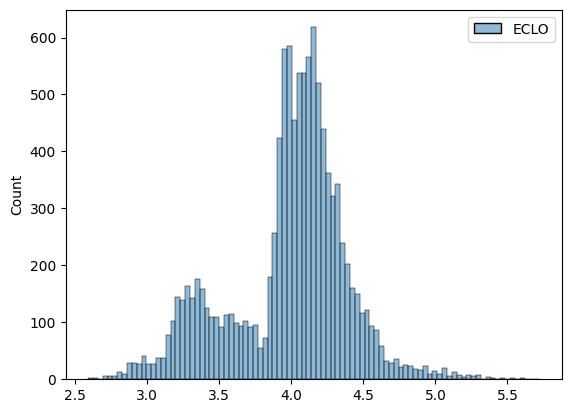

In [ ]:
sns.histplot(submission_df)

In [ ]:
submission_df.to_csv('/content/drive/MyDrive/[Stacking]컬럼손질및추가.csv', index=False)

# Model_11 []

In [ ]:
train_df.columns

Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간',
       '도시', '구', '동', '도로형태1', '도로형태2', '설치형태_건축물', '설치형태_전용주', '설치형태_한전주',
       '설치개수', '설치개수평균', '시설종류_어린이집', '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교',
       '시설종류_학원', '관할경찰서명_강북경찰서', '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서',
       '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서', '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서',
       '관할경찰서명_수성경찰서', 'CCTV설치여부_N', 'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수',
       'CCTV설치대수평균', '급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료',
       '결제방법_신용카드', '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도'],
      dtype='object')

In [ ]:
train = train_df.copy()
test = test_df.copy()

In [ ]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [ ]:
for i in  ['동','설치형태_한전주', '설치개수','주차구획수','주차구획수평균','제한속도']:
  _ant =  (train.groupby([i])['ECLO'].mean() < 4).astype(int)
  train = pd.merge(train, _ant, how='left', on=[i])
  test = pd.merge(test, _ant, how='left', on=[i])

  train.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)
  test.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)

  train = train.drop(columns=[i])
  test = test.drop(columns=[i])

In [ ]:
test.rename(columns={'ECLO':'new동'}, inplace=True)

In [ ]:
test_x = test[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'시간','설치개수평균', '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도',
                   'new설치형태_한전주','new설치개수', 'new주차구획수', 'new주차구획수평균', 'new제한속도']].copy()
train_x = train[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'시간','설치개수평균', '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도',
                   'new설치형태_한전주','new설치개수', 'new주차구획수', 'new주차구획수평균', 'new제한속도']].copy()
train_y = train['ECLO'].copy()

In [ ]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   요일            39609 non-null  object 
 1   노면상태          39609 non-null  object 
 2   사고유형          39609 non-null  object 
 3   도로형태2         39609 non-null  object 
 4   설치형태_건축물      39609 non-null  float64
 5   설치형태_전용주      39609 non-null  float64
 6   시간            39609 non-null  int64  
 7   설치개수평균        39609 non-null  float64
 8   관할경찰서명_달성경찰서  39609 non-null  float64
 9   CCTV설치여부_N    39609 non-null  float64
 10  주차기본요금        39609 non-null  float64
 11  설치연도          39609 non-null  float64
 12  new설치형태_한전주   39609 non-null  int64  
 13  new설치개수       39609 non-null  int64  
 14  new주차구획수      39609 non-null  int64  
 15  new주차구획수평균    39609 non-null  int64  
 16  new제한속도       39609 non-null  int64  
dtypes: float64(7), int64(6), object(4)
memory usage: 5.4+ MB


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1, random_state=42)

pca_temp = pca.fit_transform(train_x[['new설치형태_한전주'	,'new설치개수',	'new주차구획수']])
train_x = train_x.drop(['new설치형태_한전주'	,'new설치개수',	'new주차구획수'], axis=1)
train_x['new'] = pca_temp

pca_temp = pca.fit_transform(test_x[['new설치형태_한전주'	,'new설치개수',	'new주차구획수']])
test_x = test_x.drop(['new설치형태_한전주','new설치개수',	'new주차구획수'], axis=1)
test_x['new'] = pca_temp

print(f'{train_x.shape} / {test_x.shape}')

(39609, 15) / (10963, 15)


In [ ]:
def one_hot(df):

    # one-hot encoding 실시
    df = pd.get_dummies(df)

    return df

In [ ]:
X_train_eng = one_hot(train_x)
X_test_eng = one_hot(test_x)

y_train = np.log(train_y)

In [ ]:
X_train_eng.fillna(0, inplace=True)
X_test_eng.fillna(0, inplace=True)

In [ ]:
print(f'X_train 데이터 shape : {X_train_eng.shape}')
print(f'y_train 데이터 shape : {y_train.shape}')
print()
print(f'X_test 데이터 shape : {X_test_eng.shape}')

X_train 데이터 shape : (39609, 37)
y_train 데이터 shape : (39609,)

X_test 데이터 shape : (10963, 37)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_eng, y_train , test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
import numpy as np

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

from sklearn.metrics import make_scorer

# RMSLE를 평가 지표로 변환
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

## LGBMRegressor 모델

In [ ]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# LGBM Regressor 모델 생성
lgbm = LGBMRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [300, 400, 500, 800, 1200]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_lgbm.best_params_)
print("최적의 점수:", grid_search_lgbm.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
lgbm_best = LGBMRegressor(**grid_search_lgbm.best_params_,random_state=42)

# 모델 학습
lgbm_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = lgbm_best.predict(X_train)
y_val_pred = lgbm_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 303
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 33
[LightGBM] [Info] Start training from score 1.383856
최적의 하이퍼파라미터: {'learning_rate': 0.01, 'n_estimators': 300, 'num_leaves': 20}
최적의 점수: 0.03132558969101584
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 303
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 33
[LightGBM] [Info] Start training from score 1.383856
0.4421626992558609
0.4456912631234216


## RandomForestRegressor 모델

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

# Random Forest Regressor 모델 생성
rf = RandomForestRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [8, 10, 12]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_rf.best_params_)
print("최적의 점수:", grid_search_rf.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
rf_best = RandomForestRegressor(**grid_search_rf.best_params_,random_state=42)

# 모델 학습
rf_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = rf_best.predict(X_train)
y_val_pred = rf_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'max_depth': 10, 'min_samples_split': 12, 'n_estimators': 300}
최적의 점수: 0.02799732768288532
0.431101702644061
0.4472426635003769


## XGBRegressor 모델

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# XGB Regressor 모델 생성
xgb = XGBRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_xgb.best_params_)
print("최적의 점수:", grid_search_xgb.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
xgb_best = XGBRegressor(**grid_search_xgb.best_params_,random_state=42)

# 모델 학습
xgb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = xgb_best.predict(X_train)
y_val_pred = xgb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
최적의 점수: 0.03119516692114732
0.4444424833179359
0.4456226957604337


## GradientBoosting

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
model = GradientBoostingRegressor()

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],  # 트리 개수
    'learning_rate': [0.01, 0.1, 0.2],  # 학습률
    'max_depth': [3, 4, 5]  # 트리 최대 깊이
}

# GridSearchCV를 사용하여 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

gb_best = grid_search.best_estimator_

gb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = gb_best.predict(X_train)
y_val_pred = gb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

0.44433320556039013
0.44558634454969254


## Stack

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

In [ ]:
# 개별 모델 생성
rf = rf_best
lgbm = lgbm_best
xgb = xgb_best
gb = gb_best


# 스태킹 앙상블 모델 생성
estimators = [
    ('rf', rf),
    ('lgbm', lgbm),
    ('xgb', xgb),
    ('gb', gb)
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# 모델 학습
stacking_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = stacking_model.predict(X_train)
y_val_pred = stacking_model.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 303
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 33
[LightGBM] [Info] Start training from score 1.383856
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 300
[LightGBM] [Info] Number of data points in the train set: 25349, number of used features: 32
[LightGBM] [Info] Start training from score 1.386939
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

In [ ]:
y_pred1 = stacking_model.predict(X_test_eng)
y_pred1

array([1.30200915, 1.21544707, 1.52573931, ..., 1.45983164, 1.4755759 ,
       1.5248555 ])

In [ ]:
y_pred = np.exp(y_pred1)
y_pred

array([3.67667624, 3.37180117, 4.59854205, ..., 4.30523462, 4.37355379,
       4.59447962])

In [ ]:
submission_df['ECLO'] = y_pred
submission_df.head()

,ID,ECLO
0,ACCIDENT_39609,3.676676
1,ACCIDENT_39610,3.371801
2,ACCIDENT_39611,4.598542
3,ACCIDENT_39612,4.064915
4,ACCIDENT_39613,4.391544


<Axes: ylabel='Count'>

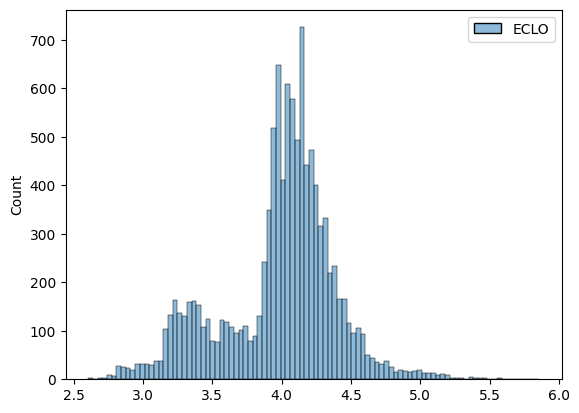

In [ ]:
sns.histplot(submission_df)

# Model_12 []

In [ ]:
train_df.columns

Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간',
       '도시', '구', '동', '도로형태1', '도로형태2', '설치형태_건축물', '설치형태_전용주', '설치형태_한전주',
       '설치개수', '설치개수평균', '시설종류_어린이집', '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교',
       '시설종류_학원', '관할경찰서명_강북경찰서', '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서',
       '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서', '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서',
       '관할경찰서명_수성경찰서', 'CCTV설치여부_N', 'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수',
       'CCTV설치대수평균', '급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료',
       '결제방법_신용카드', '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도'],
      dtype='object')

In [ ]:
train = train_df.copy()
test = test_df.copy()

In [ ]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [ ]:
for i in  ['동','설치형태_한전주', '설치개수','주차구획수','주차구획수평균','제한속도']:
  _ant =  (train.groupby([i])['ECLO'].mean() < 4).astype(int)
  train = pd.merge(train, _ant, how='left', on=[i])
  test = pd.merge(test, _ant, how='left', on=[i])

  train.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)
  test.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)

  train = train.drop(columns=[i])
  test = test.drop(columns=[i])

In [ ]:
test.rename(columns={'ECLO':'new동'}, inplace=True)

In [ ]:
test_x = test[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'시간','설치개수평균', '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도','new동',
                   'new설치형태_한전주','new설치개수', 'new주차구획수', 'new주차구획수평균', 'new제한속도']].copy()
train_x = train[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'시간','설치개수평균', '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도','new동',
                   'new설치형태_한전주','new설치개수', 'new주차구획수', 'new주차구획수평균', 'new제한속도']].copy()
train_y = train['ECLO'].copy()

In [ ]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   요일            39609 non-null  object 
 1   노면상태          39609 non-null  object 
 2   사고유형          39609 non-null  object 
 3   도로형태2         39609 non-null  object 
 4   설치형태_건축물      39609 non-null  float64
 5   설치형태_전용주      39609 non-null  float64
 6   시간            39609 non-null  int64  
 7   설치개수평균        39609 non-null  float64
 8   관할경찰서명_달성경찰서  39609 non-null  float64
 9   CCTV설치여부_N    39609 non-null  float64
 10  주차기본요금        39609 non-null  float64
 11  설치연도          39609 non-null  float64
 12  new동          39609 non-null  int64  
 13  new설치형태_한전주   39609 non-null  int64  
 14  new설치개수       39609 non-null  int64  
 15  new주차구획수      39609 non-null  int64  
 16  new주차구획수평균    39609 non-null  int64  
 17  new제한속도       39609 non-null  int64  
dtypes: float64(7), int64(7), o

In [ ]:
def one_hot(df):

    # one-hot encoding 실시
    df = pd.get_dummies(df)

    return df

In [ ]:
X_train_eng = one_hot(train_x)
X_test_eng = one_hot(test_x)

y_train = np.log(train_y)

In [ ]:
X_train_eng.fillna(0, inplace=True)
X_test_eng.fillna(0, inplace=True)

In [ ]:
print(f'X_train 데이터 shape : {X_train_eng.shape}')
print(f'y_train 데이터 shape : {y_train.shape}')
print()
print(f'X_test 데이터 shape : {X_test_eng.shape}')

X_train 데이터 shape : (39609, 40)
y_train 데이터 shape : (39609,)

X_test 데이터 shape : (10963, 40)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_eng, y_train , test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
import numpy as np

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

from sklearn.metrics import make_scorer

# RMSLE를 평가 지표로 변환
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

## LGBMRegressor 모델

In [ ]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# LGBM Regressor 모델 생성
lgbm = LGBMRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [300, 400, 500, 800, 1200]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_lgbm.best_params_)
print("최적의 점수:", grid_search_lgbm.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
lgbm_best = LGBMRegressor(**grid_search_lgbm.best_params_,random_state=42)

# 모델 학습
lgbm_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = lgbm_best.predict(X_train)
y_val_pred = lgbm_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 302
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 36
[LightGBM] [Info] Start training from score 1.383856
최적의 하이퍼파라미터: {'learning_rate': 0.01, 'n_estimators': 400, 'num_leaves': 10}
최적의 점수: 0.03148121382252589
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 302
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 36
[LightGBM] [Info] Start training from score 1.383856
0.44376384762271015
0.44536963673220586


## RandomForestRegressor 모델

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

# Random Forest Regressor 모델 생성
rf = RandomForestRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [8, 10, 12]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_rf.best_params_)
print("최적의 점수:", grid_search_rf.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
rf_best = RandomForestRegressor(**grid_search_rf.best_params_,random_state=42)

# 모델 학습
rf_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = rf_best.predict(X_train)
y_val_pred = rf_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'max_depth': 10, 'min_samples_split': 12, 'n_estimators': 300}
최적의 점수: 0.028080433772696867
0.4311200268232483
0.44729550436258725


## XGBRegressor 모델

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# XGB Regressor 모델 생성
xgb = XGBRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_xgb.best_params_)
print("최적의 점수:", grid_search_xgb.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
xgb_best = XGBRegressor(**grid_search_xgb.best_params_,random_state=42)

# 모델 학습
xgb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = xgb_best.predict(X_train)
y_val_pred = xgb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
최적의 점수: 0.03131767772656472
0.4444001950748951
0.4456977780159986


## GradientBoosting

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
model = GradientBoostingRegressor()

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],  # 트리 개수
    'learning_rate': [0.01, 0.1, 0.2],  # 학습률
    'max_depth': [3, 4, 5]  # 트리 최대 깊이
}

# GridSearchCV를 사용하여 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

gb_best = grid_search.best_estimator_

gb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = gb_best.predict(X_train)
y_val_pred = gb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

0.44431405256823736
0.4456829095739179


## Stack

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

In [ ]:
# 개별 모델 생성
rf = rf_best
lgbm = lgbm_best
xgb = xgb_best
gb = gb_best


# 스태킹 앙상블 모델 생성
estimators = [
    ('rf', rf),
    ('lgbm', lgbm),
    ('xgb', xgb),
    ('gb', gb)
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# 모델 학습
stacking_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = stacking_model.predict(X_train)
y_val_pred = stacking_model.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 302
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 36
[LightGBM] [Info] Start training from score 1.383856
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 300
[LightGBM] [Info] Number of data points in the train set: 25349, number of used features: 35
[LightGBM] [Info] Start training from score 1.386939
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 298
[LightGBM] [Info] Number of data points in the train set: 25349, number of used features: 35
[LightGBM] [Info] Start traini

In [ ]:
y_pred1 = stacking_model.predict(X_test_eng)
y_pred1

array([1.30908952, 1.22015869, 1.5212186 , ..., 1.46590966, 1.46633709,
       1.52550328])

In [ ]:
y_pred = np.exp(y_pred1)
y_pred

array([3.70280087, 3.38772529, 4.57780031, ..., 4.33148164, 4.33333341,
       4.59745678])

In [ ]:
submission_df['ECLO'] = y_pred
submission_df.head()

,ID,ECLO
0,ACCIDENT_39609,3.702801
1,ACCIDENT_39610,3.387725
2,ACCIDENT_39611,4.577800
3,ACCIDENT_39612,4.083413
4,ACCIDENT_39613,4.422044


<Axes: ylabel='Count'>

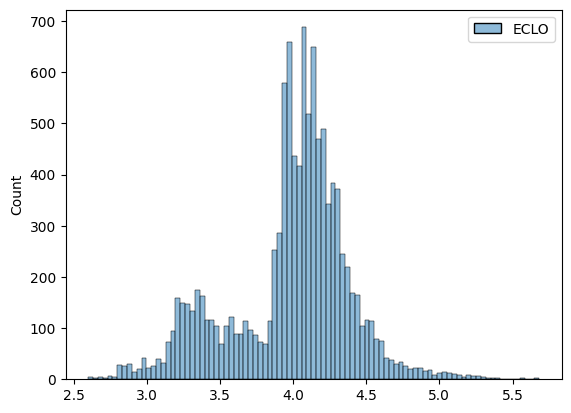

In [ ]:
sns.histplot(submission_df)

# Model_13 [0.42765]

In [ ]:
train_df.columns

Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간',
       '도시', '구', '동', '도로형태1', '도로형태2', '설치형태_건축물', '설치형태_전용주', '설치형태_한전주',
       '설치개수', '설치개수평균', '시설종류_어린이집', '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교',
       '시설종류_학원', '관할경찰서명_강북경찰서', '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서',
       '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서', '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서',
       '관할경찰서명_수성경찰서', 'CCTV설치여부_N', 'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수',
       'CCTV설치대수평균', '급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료',
       '결제방법_신용카드', '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도'],
      dtype='object')

In [ ]:
train = train_df.copy()
test = test_df.copy()

In [ ]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [ ]:
for i in  ['동']:
  _ant =  (train.groupby([i])['ECLO'].mean() < 4).astype(int)
  train = pd.merge(train, _ant, how='left', on=[i])
  test = pd.merge(test, _ant, how='left', on=[i])

  train.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)
  test.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)

  train = train.drop(columns=[i])
  test = test.drop(columns=[i])

In [ ]:
test.rename(columns={'ECLO':'new동'}, inplace=True)

In [ ]:
test_x = test[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'시간','설치개수평균', '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도','new동',
                   '설치형태_한전주','설치개수', '주차구획수', '주차구획수평균', '제한속도']].copy()
train_x = train[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'시간','설치개수평균', '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도','new동',
                   '설치형태_한전주','설치개수', '주차구획수', '주차구획수평균', '제한속도']].copy()
train_y = train['ECLO'].copy()

In [ ]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   요일            39609 non-null  object 
 1   노면상태          39609 non-null  object 
 2   사고유형          39609 non-null  object 
 3   도로형태2         39609 non-null  object 
 4   설치형태_건축물      39609 non-null  float64
 5   설치형태_전용주      39609 non-null  float64
 6   시간            39609 non-null  int64  
 7   설치개수평균        39609 non-null  float64
 8   관할경찰서명_달성경찰서  39609 non-null  float64
 9   CCTV설치여부_N    39609 non-null  float64
 10  주차기본요금        39609 non-null  float64
 11  설치연도          39609 non-null  float64
 12  new동          39609 non-null  int64  
 13  설치형태_한전주      39609 non-null  float64
 14  설치개수          39609 non-null  float64
 15  주차구획수         39609 non-null  float64
 16  주차구획수평균       39609 non-null  float64
 17  제한속도          39609 non-null  float64
dtypes: float64(12), int64(2), 

In [ ]:
def one_hot(df):

    # one-hot encoding 실시
    df = pd.get_dummies(df)

    return df

In [ ]:
X_train_eng = one_hot(train_x)
X_test_eng = one_hot(test_x)

y_train = np.log(train_y)

In [ ]:
X_train_eng.fillna(0, inplace=True)
X_test_eng.fillna(0, inplace=True)

In [ ]:
print(f'X_train 데이터 shape : {X_train_eng.shape}')
print(f'y_train 데이터 shape : {y_train.shape}')
print()
print(f'X_test 데이터 shape : {X_test_eng.shape}')

X_train 데이터 shape : (39609, 40)
y_train 데이터 shape : (39609,)

X_test 데이터 shape : (10963, 40)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_eng, y_train , test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
import numpy as np

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

from sklearn.metrics import make_scorer

# RMSLE를 평가 지표로 변환
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

## LGBMRegressor 모델

In [ ]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# LGBM Regressor 모델 생성
lgbm = LGBMRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [300, 400, 500, 800, 1200]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_lgbm.best_params_)
print("최적의 점수:", grid_search_lgbm.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
lgbm_best = LGBMRegressor(**grid_search_lgbm.best_params_,random_state=42)

# 모델 학습
lgbm_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = lgbm_best.predict(X_train)
y_val_pred = lgbm_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 793
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 36
[LightGBM] [Info] Start training from score 1.383856
최적의 하이퍼파라미터: {'learning_rate': 0.01, 'n_estimators': 400, 'num_leaves': 10}
최적의 점수: 0.03141831695591176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 793
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 36
[LightGBM] [Info] Start training from score 1.383856
0.4433086490814608
0.44563023615540637


## RandomForestRegressor 모델

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

# Random Forest Regressor 모델 생성
rf = RandomForestRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [8, 10, 12]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_rf.best_params_)
print("최적의 점수:", grid_search_rf.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
rf_best = RandomForestRegressor(**grid_search_rf.best_params_,random_state=42)

# 모델 학습
rf_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = rf_best.predict(X_train)
y_val_pred = rf_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'max_depth': 10, 'min_samples_split': 12, 'n_estimators': 300}
최적의 점수: 0.026423921278939815
0.4291459491502229
0.44700969797275725


## XGBRegressor 모델

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# XGB Regressor 모델 생성
xgb = XGBRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_xgb.best_params_)
print("최적의 점수:", grid_search_xgb.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
xgb_best = XGBRegressor(**grid_search_xgb.best_params_,random_state=42)

# 모델 학습
xgb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = xgb_best.predict(X_train)
y_val_pred = xgb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
최적의 점수: 0.03168821924130549
0.4440286589335611
0.44574875833904176


## GradientBoosting

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
model = GradientBoostingRegressor()

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],  # 트리 개수
    'learning_rate': [0.01, 0.1, 0.2],  # 학습률
    'max_depth': [3, 4, 5]  # 트리 최대 깊이
}

# GridSearchCV를 사용하여 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

gb_best = grid_search.best_estimator_

gb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = gb_best.predict(X_train)
y_val_pred = gb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

0.4439466425331577
0.44559704016420876


## Stack

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

In [ ]:
# 개별 모델 생성
rf = rf_best
lgbm = lgbm_best
xgb = xgb_best
gb = gb_best


# 스태킹 앙상블 모델 생성
estimators = [
    ('rf', rf),
    ('lgbm', lgbm),
    ('xgb', xgb),
    ('gb', gb)
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# 모델 학습
stacking_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = stacking_model.predict(X_train)
y_val_pred = stacking_model.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 793
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 36
[LightGBM] [Info] Start training from score 1.383856
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 791
[LightGBM] [Info] Number of data points in the train set: 25349, number of used features: 36
[LightGBM] [Info] Start training from score 1.386939
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 784
[LightGBM] [Info] Number of data points in the train set: 2

In [ ]:
y_pred1 = stacking_model.predict(X_test_eng)
y_pred1

array([1.30989261, 1.24800604, 1.52505491, ..., 1.45160525, 1.45645607,
       1.4966856 ])

In [ ]:
y_pred = np.exp(y_pred1)
y_pred

array([3.70577571, 3.48339028, 4.59539588, ..., 4.26996336, 4.29072652,
       4.46685956])

In [ ]:
submission_df['ECLO'] = y_pred
submission_df.head()

,ID,ECLO
0,ACCIDENT_39609,3.705776
1,ACCIDENT_39610,3.483390
2,ACCIDENT_39611,4.595396
3,ACCIDENT_39612,4.181808
4,ACCIDENT_39613,4.311937


<Axes: ylabel='Count'>

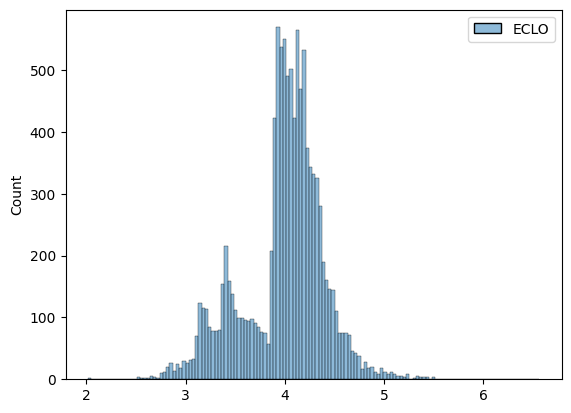

In [ ]:
sns.histplot(submission_df)

In [ ]:
submission_df.to_csv('/content/drive/MyDrive/[Stacking]그래프좋음.csv', index=False)

# Model_14 []

In [ ]:
train_df.columns

Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간',
       '도시', '구', '동', '도로형태1', '도로형태2', '설치형태_건축물', '설치형태_전용주', '설치형태_한전주',
       '설치개수', '설치개수평균', '시설종류_어린이집', '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교',
       '시설종류_학원', '관할경찰서명_강북경찰서', '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서',
       '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서', '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서',
       '관할경찰서명_수성경찰서', 'CCTV설치여부_N', 'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수',
       'CCTV설치대수평균', '급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료',
       '결제방법_신용카드', '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도'],
      dtype='object')

In [ ]:
train = train_df.copy()
test = test_df.copy()

In [ ]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [ ]:
for i in  ['동']:
  _ant =  (train.groupby([i])['ECLO'].mean() < 4).astype(int)
  train = pd.merge(train, _ant, how='left', on=[i])
  test = pd.merge(test, _ant, how='left', on=[i])

  train.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)
  test.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)

  train = train.drop(columns=[i])
  test = test.drop(columns=[i])

In [ ]:
test.rename(columns={'ECLO':'new동'}, inplace=True)

In [ ]:
test_x = test[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'시간','설치개수평균', '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도','new동',
                   '설치형태_한전주','설치개수', '주차구획수', '주차구획수평균', '제한속도',
               '급지구분_1', '급지구분_2', '급지구분_3']].copy()
train_x = train[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'시간','설치개수평균', '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도','new동',
                   '설치형태_한전주','설치개수', '주차구획수', '주차구획수평균', '제한속도',
                 '급지구분_1', '급지구분_2', '급지구분_3']].copy()
train_y = train['ECLO'].copy()

In [ ]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   요일            39609 non-null  object 
 1   노면상태          39609 non-null  object 
 2   사고유형          39609 non-null  object 
 3   도로형태2         39609 non-null  object 
 4   설치형태_건축물      39609 non-null  float64
 5   설치형태_전용주      39609 non-null  float64
 6   시간            39609 non-null  int64  
 7   설치개수평균        39609 non-null  float64
 8   관할경찰서명_달성경찰서  39609 non-null  float64
 9   CCTV설치여부_N    39609 non-null  float64
 10  주차기본요금        39609 non-null  float64
 11  설치연도          39609 non-null  float64
 12  new동          39609 non-null  int64  
 13  설치형태_한전주      39609 non-null  float64
 14  설치개수          39609 non-null  float64
 15  주차구획수         39609 non-null  float64
 16  주차구획수평균       39609 non-null  float64
 17  제한속도          39609 non-null  float64
 18  급지구분_1        39609 non-nu

In [ ]:
def one_hot(df):

    # one-hot encoding 실시
    df = pd.get_dummies(df)

    return df

In [ ]:
X_train_eng = one_hot(train_x)
X_test_eng = one_hot(test_x)

y_train = np.log(train_y)

In [ ]:
X_train_eng.fillna(0, inplace=True)
X_test_eng.fillna(0, inplace=True)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1, random_state=42)

pca_temp = pca.fit_transform(X_train_eng[['급지구분_1', '급지구분_2', '급지구분_3']])
X_train_eng = X_train_eng.drop(['급지구분_1', '급지구분_2', '급지구분_3'], axis=1)
X_train_eng['급지구분'] = pca_temp

pca_temp = pca.fit_transform(X_test_eng[['급지구분_1', '급지구분_2', '급지구분_3']])
X_test_eng = X_test_eng.drop(['급지구분_1', '급지구분_2', '급지구분_3'], axis=1)
X_test_eng['급지구분'] = pca_temp

In [ ]:
print(f'X_train 데이터 shape : {X_train_eng.shape}')
print(f'y_train 데이터 shape : {y_train.shape}')
print()
print(f'X_test 데이터 shape : {X_test_eng.shape}')

X_train 데이터 shape : (39609, 41)
y_train 데이터 shape : (39609,)

X_test 데이터 shape : (10963, 41)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_eng, y_train , test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
import numpy as np

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

from sklearn.metrics import make_scorer

# RMSLE를 평가 지표로 변환
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

## LGBMRegressor 모델

In [ ]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# LGBM Regressor 모델 생성
lgbm = LGBMRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [300, 400, 500, 800, 1200]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_lgbm.best_params_)
print("최적의 점수:", grid_search_lgbm.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
lgbm_best = LGBMRegressor(**grid_search_lgbm.best_params_,random_state=42)

# 모델 학습
lgbm_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = lgbm_best.predict(X_train)
y_val_pred = lgbm_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 37
[LightGBM] [Info] Start training from score 1.383856
최적의 하이퍼파라미터: {'learning_rate': 0.01, 'n_estimators': 400, 'num_leaves': 10}
최적의 점수: 0.03148357712700852
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 37
[LightGBM] [Info] Start training from score 1.383856
0.443271177012352
0.44560966338265245


## RandomForestRegressor 모델

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

# Random Forest Regressor 모델 생성
rf = RandomForestRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [8, 10, 12]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_rf.best_params_)
print("최적의 점수:", grid_search_rf.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
rf_best = RandomForestRegressor(**grid_search_rf.best_params_,random_state=42)

# 모델 학습
rf_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = rf_best.predict(X_train)
y_val_pred = rf_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'max_depth': 10, 'min_samples_split': 12, 'n_estimators': 300}
최적의 점수: 0.02656876599664526
0.42914336355578864
0.4468561930667272


## XGBRegressor 모델

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# XGB Regressor 모델 생성
xgb = XGBRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_xgb.best_params_)
print("최적의 점수:", grid_search_xgb.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
xgb_best = XGBRegressor(**grid_search_xgb.best_params_,random_state=42)

# 모델 학습
xgb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = xgb_best.predict(X_train)
y_val_pred = xgb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
최적의 점수: 0.03169743008605282
0.44400603505977365
0.445734669729668


## GradientBoosting

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
model = GradientBoostingRegressor()

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],  # 트리 개수
    'learning_rate': [0.01, 0.1, 0.2],  # 학습률
    'max_depth': [3, 4, 5]  # 트리 최대 깊이
}

# GridSearchCV를 사용하여 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

gb_best = grid_search.best_estimator_

gb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = gb_best.predict(X_train)
y_val_pred = gb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

0.4438824435174224
0.445702014839981


## Stack

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

In [ ]:
# 개별 모델 생성
rf = rf_best
lgbm = lgbm_best
xgb = xgb_best
gb = gb_best


# 스태킹 앙상블 모델 생성
estimators = [
    ('rf', rf),
    ('lgbm', lgbm),
    ('xgb', xgb),
    ('gb', gb)
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# 모델 학습
stacking_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = stacking_model.predict(X_train)
y_val_pred = stacking_model.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 37
[LightGBM] [Info] Start training from score 1.383856
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 839
[LightGBM] [Info] Number of data points in the train set: 25349, number of used features: 37
[LightGBM] [Info] Start training from score 1.386939
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

In [ ]:
y_pred1 = stacking_model.predict(X_test_eng)
y_pred1

array([1.32340597, 1.24891678, 1.52705794, ..., 1.45443802, 1.45514074,
       1.49452932])

In [ ]:
y_pred = np.exp(y_pred1)
y_pred

array([3.75619311, 3.4865642 , 4.60460983, ..., 4.28207635, 4.2850865 ,
       4.45723813])

In [ ]:
submission_df['ECLO'] = y_pred
submission_df.head()

,ID,ECLO
0,ACCIDENT_39609,3.756193
1,ACCIDENT_39610,3.486564
2,ACCIDENT_39611,4.604610
3,ACCIDENT_39612,4.185216
4,ACCIDENT_39613,4.322494


<Axes: ylabel='Count'>

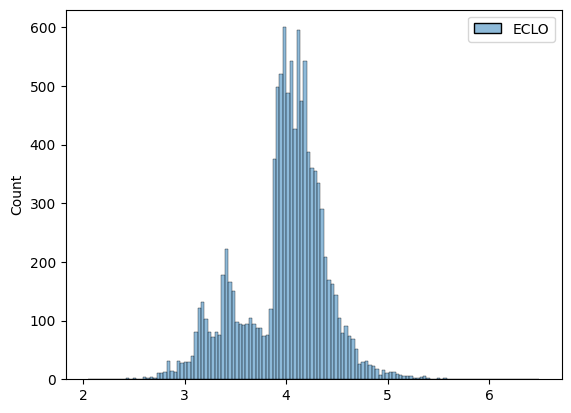

In [ ]:
sns.histplot(submission_df)

# Model_15 []

In [ ]:
train_df.columns

Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간',
       '도시', '구', '동', '도로형태1', '도로형태2', '설치형태_건축물', '설치형태_전용주', '설치형태_한전주',
       '설치개수', '설치개수평균', '시설종류_어린이집', '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교',
       '시설종류_학원', '관할경찰서명_강북경찰서', '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서',
       '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서', '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서',
       '관할경찰서명_수성경찰서', 'CCTV설치여부_N', 'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수',
       'CCTV설치대수평균', '급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료',
       '결제방법_신용카드', '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도'],
      dtype='object')

In [ ]:
train = train_df.copy()
test = test_df.copy()

In [ ]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [ ]:
for i in  ['동']:
  _ant =  (train.groupby([i])['ECLO'].mean() < 4).astype(int)
  train = pd.merge(train, _ant, how='left', on=[i])
  test = pd.merge(test, _ant, how='left', on=[i])

  train.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)
  test.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)

  train = train.drop(columns=[i])
  test = test.drop(columns=[i])

In [ ]:
test.rename(columns={'ECLO':'new동'}, inplace=True)

In [ ]:
test_x = test[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'시간','설치개수평균', '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도','new동',
                   '설치형태_한전주','설치개수', '주차구획수', '주차구획수평균', '제한속도',
                  '급지구분_1', '급지구분_2', '급지구분_3']].copy()
train_x = train[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'시간','설치개수평균', '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도','new동',
                   '설치형태_한전주','설치개수', '주차구획수', '주차구획수평균', '제한속도',
                 '급지구분_1', '급지구분_2', '급지구분_3']].copy()
train_y = train['ECLO'].copy()

In [ ]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   요일            39609 non-null  object 
 1   노면상태          39609 non-null  object 
 2   사고유형          39609 non-null  object 
 3   도로형태2         39609 non-null  object 
 4   설치형태_건축물      39609 non-null  float64
 5   설치형태_전용주      39609 non-null  float64
 6   시간            39609 non-null  int64  
 7   설치개수평균        39609 non-null  float64
 8   관할경찰서명_달성경찰서  39609 non-null  float64
 9   CCTV설치여부_N    39609 non-null  float64
 10  주차기본요금        39609 non-null  float64
 11  설치연도          39609 non-null  float64
 12  new동          39609 non-null  int64  
 13  설치형태_한전주      39609 non-null  float64
 14  설치개수          39609 non-null  float64
 15  주차구획수         39609 non-null  float64
 16  주차구획수평균       39609 non-null  float64
 17  제한속도          39609 non-null  float64
 18  급지구분_1        39609 non-nu

In [ ]:
def one_hot(df):

    # one-hot encoding 실시
    df = pd.get_dummies(df)

    return df

In [ ]:
X_train_eng = one_hot(train_x)
X_test_eng = one_hot(test_x)

y_train = np.log(train_y)

In [ ]:
X_train_eng.fillna(0, inplace=True)
X_test_eng.fillna(0, inplace=True)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1, random_state=42)

pca_temp = pca.fit_transform(X_train_eng[['설치형태_건축물', '설치형태_한전주','설치개수']])
X_train_eng = X_train_eng.drop(['설치형태_건축물', '설치형태_한전주','설치개수'], axis=1)
X_train_eng['건축_한전_개수'] = pca_temp

pca_temp = pca.fit_transform(X_test_eng[['설치형태_건축물', '설치형태_한전주','설치개수']])
X_test_eng = X_test_eng.drop(['설치형태_건축물', '설치형태_한전주','설치개수'], axis=1)
X_test_eng['건축_한전_개수'] = pca_temp

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1, random_state=42)

pca_temp = pca.fit_transform(X_train_eng[['급지구분_1', '급지구분_2', '급지구분_3']])
X_train_eng = X_train_eng.drop(['급지구분_1', '급지구분_2', '급지구분_3'], axis=1)
X_train_eng['급지구분'] = pca_temp

pca_temp = pca.fit_transform(X_test_eng[['급지구분_1', '급지구분_2', '급지구분_3']])
X_test_eng = X_test_eng.drop(['급지구분_1', '급지구분_2', '급지구분_3'], axis=1)
X_test_eng['급지구분'] = pca_temp

In [ ]:
print(f'X_train 데이터 shape : {X_train_eng.shape}')
print(f'y_train 데이터 shape : {y_train.shape}')
print()
print(f'X_test 데이터 shape : {X_test_eng.shape}')

X_train 데이터 shape : (39609, 39)
y_train 데이터 shape : (39609,)

X_test 데이터 shape : (10963, 39)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_eng, y_train , test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
import numpy as np

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

from sklearn.metrics import make_scorer

# RMSLE를 평가 지표로 변환
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

## LGBMRegressor 모델

In [ ]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# LGBM Regressor 모델 생성
lgbm = LGBMRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [300, 400, 500, 800, 1200]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_lgbm.best_params_)
print("최적의 점수:", grid_search_lgbm.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
lgbm_best = LGBMRegressor(**grid_search_lgbm.best_params_,random_state=42)

# 모델 학습
lgbm_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = lgbm_best.predict(X_train)
y_val_pred = lgbm_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 733
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 35
[LightGBM] [Info] Start training from score 1.383856
최적의 하이퍼파라미터: {'learning_rate': 0.01, 'n_estimators': 400, 'num_leaves': 10}
최적의 점수: 0.03148753231626089
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 733
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 35
[LightGBM] [Info] Start training from score 1.383856
0.4433224069625563
0.4456206030892718


## RandomForestRegressor 모델

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

# Random Forest Regressor 모델 생성
rf = RandomForestRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [8, 10, 12]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_rf.best_params_)
print("최적의 점수:", grid_search_rf.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
rf_best = RandomForestRegressor(**grid_search_rf.best_params_,random_state=42)

# 모델 학습
rf_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = rf_best.predict(X_train)
y_val_pred = rf_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'max_depth': 10, 'min_samples_split': 12, 'n_estimators': 300}
최적의 점수: 0.02666032867351446
0.42927392113730234
0.4468284803161318


## XGBRegressor 모델

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# XGB Regressor 모델 생성
xgb = XGBRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_xgb.best_params_)
print("최적의 점수:", grid_search_xgb.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
xgb_best = XGBRegressor(**grid_search_xgb.best_params_,random_state=42)

# 모델 학습
xgb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = xgb_best.predict(X_train)
y_val_pred = xgb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
최적의 점수: 0.03153723148234696
0.4440233943142572
0.44576455704375356


## GradientBoosting

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
model = GradientBoostingRegressor()

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],  # 트리 개수
    'learning_rate': [0.01, 0.1, 0.2],  # 학습률
    'max_depth': [3, 4, 5]  # 트리 최대 깊이
}

# GridSearchCV를 사용하여 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

gb_best = grid_search.best_estimator_

gb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = gb_best.predict(X_train)
y_val_pred = gb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

0.44386361700925836
0.4456582475829959


## Stack

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

In [ ]:
# 개별 모델 생성
rf = rf_best
lgbm = lgbm_best
xgb = xgb_best
gb = gb_best


# 스태킹 앙상블 모델 생성
estimators = [
    ('rf', rf),
    ('lgbm', lgbm),
    ('xgb', xgb),
    ('gb', gb)
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# 모델 학습
stacking_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = stacking_model.predict(X_train)
y_val_pred = stacking_model.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 733
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 35
[LightGBM] [Info] Start training from score 1.383856
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 732
[LightGBM] [Info] Number of data points in the train set: 25349, number of used features: 35
[LightGBM] [Info] Start training from score 1.386939
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 723
[LightGBM] [Info] Number of data points in the train set: 2

In [ ]:
y_pred1 = stacking_model.predict(X_test_eng)
y_pred1

array([1.31352868, 1.25334698, 1.52662369, ..., 1.45117479, 1.45264737,
       1.47998562])

In [ ]:
y_pred = np.exp(y_pred1)
y_pred

array([3.71927471, 3.50204464, 4.6026107 , ..., 4.26812572, 4.27441553,
       4.39288249])

In [ ]:
submission_df['ECLO'] = y_pred
submission_df.head()

,ID,ECLO
0,ACCIDENT_39609,3.719275
1,ACCIDENT_39610,3.502045
2,ACCIDENT_39611,4.602611
3,ACCIDENT_39612,4.242901
4,ACCIDENT_39613,4.335845


<Axes: ylabel='Count'>

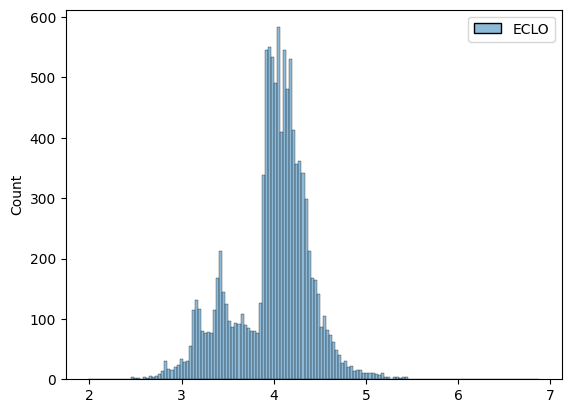

In [ ]:
sns.histplot(submission_df)

# Model_16 []

In [ ]:
train_df.columns

Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간',
       '도시', '구', '동', '도로형태1', '도로형태2', '설치형태_건축물', '설치형태_전용주', '설치형태_한전주',
       '설치개수', '설치개수평균', '시설종류_어린이집', '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교',
       '시설종류_학원', '관할경찰서명_강북경찰서', '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서',
       '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서', '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서',
       '관할경찰서명_수성경찰서', 'CCTV설치여부_N', 'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수',
       'CCTV설치대수평균', '급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료',
       '결제방법_신용카드', '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도'],
      dtype='object')

In [ ]:
train = train_df.copy()
test = test_df.copy()

In [ ]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [ ]:
for i in  ['동']:
  _ant =  (train.groupby([i])['ECLO'].mean() < 4).astype(int)
  train = pd.merge(train, _ant, how='left', on=[i])
  test = pd.merge(test, _ant, how='left', on=[i])

  train.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)
  test.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)

  train = train.drop(columns=[i])
  test = test.drop(columns=[i])

In [ ]:
test.rename(columns={'ECLO':'new동'}, inplace=True)

In [ ]:
test_x = test[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'시간','설치개수평균', '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도','new동',
                   '설치형태_한전주','설치개수', '주차구획수', '주차구획수평균', '제한속도']].copy()
train_x = train[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'시간','설치개수평균', '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도','new동',
                   '설치형태_한전주','설치개수', '주차구획수', '주차구획수평균', '제한속도']].copy()
train_y = train['ECLO'].copy()

In [ ]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   요일            39609 non-null  object 
 1   노면상태          39609 non-null  object 
 2   사고유형          39609 non-null  object 
 3   도로형태2         39609 non-null  object 
 4   설치형태_건축물      39609 non-null  float64
 5   설치형태_전용주      39609 non-null  float64
 6   시간            39609 non-null  int64  
 7   설치개수평균        39609 non-null  float64
 8   관할경찰서명_달성경찰서  39609 non-null  float64
 9   CCTV설치여부_N    39609 non-null  float64
 10  주차기본요금        39609 non-null  float64
 11  설치연도          39609 non-null  float64
 12  new동          39609 non-null  int64  
 13  설치형태_한전주      39609 non-null  float64
 14  설치개수          39609 non-null  float64
 15  주차구획수         39609 non-null  float64
 16  주차구획수평균       39609 non-null  float64
 17  제한속도          39609 non-null  float64
dtypes: float64(12), int64(2), 

In [ ]:
def one_hot(df):

    # one-hot encoding 실시
    df = pd.get_dummies(df)

    return df

In [ ]:
X_train_eng = one_hot(train_x)
X_test_eng = one_hot(test_x)

y_train = np.log(train_y)

In [ ]:
X_train_eng.fillna(0, inplace=True)
X_test_eng.fillna(0, inplace=True)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1, random_state=42)

pca_temp = pca.fit_transform(X_train_eng[['설치형태_건축물', '설치형태_한전주','설치개수']])
X_train_eng = X_train_eng.drop(['설치형태_건축물', '설치형태_한전주','설치개수'], axis=1)
X_train_eng['건축_한전_개수'] = pca_temp

pca_temp = pca.fit_transform(X_test_eng[['설치형태_건축물', '설치형태_한전주','설치개수']])
X_test_eng = X_test_eng.drop(['설치형태_건축물', '설치형태_한전주','설치개수'], axis=1)
X_test_eng['건축_한전_개수'] = pca_temp

In [ ]:
print(f'X_train 데이터 shape : {X_train_eng.shape}')
print(f'y_train 데이터 shape : {y_train.shape}')
print()
print(f'X_test 데이터 shape : {X_test_eng.shape}')

X_train 데이터 shape : (39609, 38)
y_train 데이터 shape : (39609,)

X_test 데이터 shape : (10963, 38)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_eng, y_train , test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
import numpy as np

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

from sklearn.metrics import make_scorer

# RMSLE를 평가 지표로 변환
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

## LGBMRegressor 모델

In [ ]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# LGBM Regressor 모델 생성
lgbm = LGBMRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [300, 400, 500, 800, 1200]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_lgbm.best_params_)
print("최적의 점수:", grid_search_lgbm.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
lgbm_best = LGBMRegressor(**grid_search_lgbm.best_params_,random_state=42)

# 모델 학습
lgbm_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = lgbm_best.predict(X_train)
y_val_pred = lgbm_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 685
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 34
[LightGBM] [Info] Start training from score 1.383856
최적의 하이퍼파라미터: {'learning_rate': 0.01, 'n_estimators': 400, 'num_leaves': 10}
최적의 점수: 0.031258237454541704
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 685
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 34
[LightGBM] [Info] Start training from score 1.383856
0.44336903658092724
0.44564591921100954


## RandomForestRegressor 모델

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

# Random Forest Regressor 모델 생성
rf = RandomForestRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [8, 10, 12]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_rf.best_params_)
print("최적의 점수:", grid_search_rf.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
rf_best = RandomForestRegressor(**grid_search_rf.best_params_,random_state=42)

# 모델 학습
rf_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = rf_best.predict(X_train)
y_val_pred = rf_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'max_depth': 10, 'min_samples_split': 12, 'n_estimators': 300}
최적의 점수: 0.02657491800003653
0.429314894286391
0.447023078213494


## XGBRegressor 모델

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# XGB Regressor 모델 생성
xgb = XGBRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_xgb.best_params_)
print("최적의 점수:", grid_search_xgb.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
xgb_best = XGBRegressor(**grid_search_xgb.best_params_,random_state=42)

# 모델 학습
xgb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = xgb_best.predict(X_train)
y_val_pred = xgb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
최적의 점수: 0.03155859240327582
0.4440828005095673
0.4457168992337494


## GradientBoosting

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
model = GradientBoostingRegressor()

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],  # 트리 개수
    'learning_rate': [0.01, 0.1, 0.2],  # 학습률
    'max_depth': [3, 4, 5]  # 트리 최대 깊이
}

# GridSearchCV를 사용하여 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

gb_best = grid_search.best_estimator_

gb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = gb_best.predict(X_train)
y_val_pred = gb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

0.44389583975225855
0.4457416251885561


## Stack

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

In [ ]:
# 개별 모델 생성
rf = rf_best
lgbm = lgbm_best
xgb = xgb_best
gb = gb_best


# 스태킹 앙상블 모델 생성
estimators = [
    ('rf', rf),
    ('lgbm', lgbm),
    ('xgb', xgb),
    ('gb', gb)
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# 모델 학습
stacking_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = stacking_model.predict(X_train)
y_val_pred = stacking_model.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 685
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 34
[LightGBM] [Info] Start training from score 1.383856
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 684
[LightGBM] [Info] Number of data points in the train set: 25349, number of used features: 34
[LightGBM] [Info] Start training from score 1.386939
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 675
[LightGBM] [Info] Number of data points in the train set: 25349, number of used features: 34
[LightGBM] [Info] Start traini

In [ ]:
y_pred1 = stacking_model.predict(X_test_eng)
y_pred1

array([1.29224656, 1.24627694, 1.52333683, ..., 1.44968214, 1.45548908,
       1.48391161])

In [ ]:
y_pred = np.exp(y_pred1)
y_pred

array([3.640957  , 3.47737238, 4.58750743, ..., 4.26175965, 4.28657944,
       4.41016281])

In [ ]:
submission_df['ECLO'] = y_pred
submission_df.head()

,ID,ECLO
0,ACCIDENT_39609,3.640957
1,ACCIDENT_39610,3.477372
2,ACCIDENT_39611,4.587507
3,ACCIDENT_39612,4.187505
4,ACCIDENT_39613,4.316569


<Axes: ylabel='Count'>

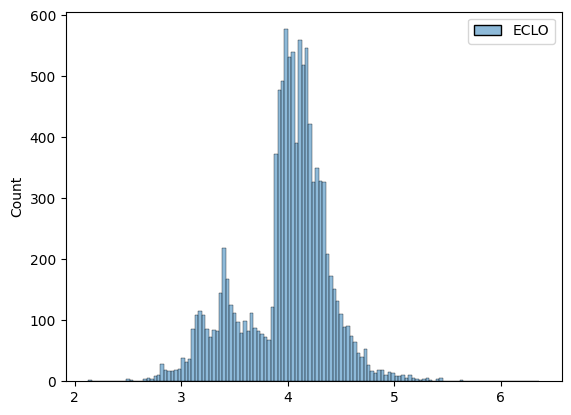

In [ ]:
sns.histplot(submission_df)

# Model_17 []

In [ ]:
train_df.columns

Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간',
       '도시', '구', '동', '도로형태1', '도로형태2', '설치형태_건축물', '설치형태_전용주', '설치형태_한전주',
       '설치개수', '설치개수평균', '시설종류_어린이집', '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교',
       '시설종류_학원', '관할경찰서명_강북경찰서', '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서',
       '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서', '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서',
       '관할경찰서명_수성경찰서', 'CCTV설치여부_N', 'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수',
       'CCTV설치대수평균', '급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료',
       '결제방법_신용카드', '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도'],
      dtype='object')

In [ ]:
train = train_df.copy()
test = test_df.copy()

In [ ]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [ ]:
for i in  ['동']:
  _ant =  (train.groupby([i])['ECLO'].mean() < 4).astype(int)
  train = pd.merge(train, _ant, how='left', on=[i])
  test = pd.merge(test, _ant, how='left', on=[i])

  train.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)
  test.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)

  train = train.drop(columns=[i])
  test = test.drop(columns=[i])

In [ ]:
test.rename(columns={'ECLO':'new동'}, inplace=True)

In [ ]:
test_x = test[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주','연'
                  ,'시간','설치개수평균', '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도','new동',
                   '설치형태_한전주','설치개수', '주차구획수', '주차구획수평균', '제한속도']].copy()
train_x = train[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주','연'
                  ,'시간','설치개수평균', '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도','new동',
                   '설치형태_한전주','설치개수', '주차구획수', '주차구획수평균', '제한속도']].copy()
train_y = train['ECLO'].copy()

In [ ]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   요일            39609 non-null  object 
 1   노면상태          39609 non-null  object 
 2   사고유형          39609 non-null  object 
 3   도로형태2         39609 non-null  object 
 4   설치형태_건축물      39609 non-null  float64
 5   설치형태_전용주      39609 non-null  float64
 6   연             39609 non-null  int64  
 7   시간            39609 non-null  int64  
 8   설치개수평균        39609 non-null  float64
 9   관할경찰서명_달성경찰서  39609 non-null  float64
 10  CCTV설치여부_N    39609 non-null  float64
 11  주차기본요금        39609 non-null  float64
 12  설치연도          39609 non-null  float64
 13  new동          39609 non-null  int64  
 14  설치형태_한전주      39609 non-null  float64
 15  설치개수          39609 non-null  float64
 16  주차구획수         39609 non-null  float64
 17  주차구획수평균       39609 non-null  float64
 18  제한속도          39609 non-nu

In [ ]:
def one_hot(df):

    # one-hot encoding 실시
    df = pd.get_dummies(df)

    return df

In [ ]:
X_train_eng = one_hot(train_x)
X_test_eng = one_hot(test_x)

y_train = np.log(train_y)

In [ ]:
X_train_eng.fillna(0, inplace=True)
X_test_eng.fillna(0, inplace=True)

In [ ]:
print(f'X_train 데이터 shape : {X_train_eng.shape}')
print(f'y_train 데이터 shape : {y_train.shape}')
print()
print(f'X_test 데이터 shape : {X_test_eng.shape}')

X_train 데이터 shape : (39609, 41)
y_train 데이터 shape : (39609,)

X_test 데이터 shape : (10963, 41)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_eng, y_train , test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
import numpy as np

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

from sklearn.metrics import make_scorer

# RMSLE를 평가 지표로 변환
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

## LGBMRegressor 모델

In [ ]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# LGBM Regressor 모델 생성
lgbm = LGBMRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [300, 400, 500, 800, 1200]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_lgbm.best_params_)
print("최적의 점수:", grid_search_lgbm.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
lgbm_best = LGBMRegressor(**grid_search_lgbm.best_params_,random_state=42)

# 모델 학습
lgbm_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = lgbm_best.predict(X_train)
y_val_pred = lgbm_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 37
[LightGBM] [Info] Start training from score 1.383856
최적의 하이퍼파라미터: {'learning_rate': 0.01, 'n_estimators': 400, 'num_leaves': 10}
최적의 점수: 0.031877333536048345
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 37
[LightGBM] [Info] Start training from score 1.383856
0.4432174568710151
0.445401655788395


## RandomForestRegressor 모델

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

# Random Forest Regressor 모델 생성
rf = RandomForestRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [8, 10, 12]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_rf.best_params_)
print("최적의 점수:", grid_search_rf.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
rf_best = RandomForestRegressor(**grid_search_rf.best_params_,random_state=42)

# 모델 학습
rf_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = rf_best.predict(X_train)
y_val_pred = rf_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'max_depth': 10, 'min_samples_split': 12, 'n_estimators': 300}
최적의 점수: 0.027381039353064057
0.4282544920821379
0.446903287717757


## XGBRegressor 모델

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# XGB Regressor 모델 생성
xgb = XGBRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_xgb.best_params_)
print("최적의 점수:", grid_search_xgb.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
xgb_best = XGBRegressor(**grid_search_xgb.best_params_,random_state=42)

# 모델 학습
xgb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = xgb_best.predict(X_train)
y_val_pred = xgb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
최적의 점수: 0.03194686342484351
0.44395387679523796
0.4456722401709855


## GradientBoosting

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
model = GradientBoostingRegressor()

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],  # 트리 개수
    'learning_rate': [0.01, 0.1, 0.2],  # 학습률
    'max_depth': [3, 4, 5]  # 트리 최대 깊이
}

# GridSearchCV를 사용하여 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

gb_best = grid_search.best_estimator_

gb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = gb_best.predict(X_train)
y_val_pred = gb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

0.4438622018998145
0.4456160194376998


## Stack

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

In [ ]:
# 개별 모델 생성
rf = rf_best
lgbm = lgbm_best
xgb = xgb_best
gb = gb_best


# 스태킹 앙상블 모델 생성
estimators = [
    ('rf', rf),
    ('lgbm', lgbm),
    ('xgb', xgb),
    ('gb', gb)
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# 모델 학습
stacking_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = stacking_model.predict(X_train)
y_val_pred = stacking_model.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 37
[LightGBM] [Info] Start training from score 1.383856
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 795
[LightGBM] [Info] Number of data points in the train set: 25349, number of used features: 37
[LightGBM] [Info] Start training from score 1.386939
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

In [ ]:
y_pred1 = stacking_model.predict(X_test_eng)
y_pred1

array([1.32249835, 1.24206123, 1.51389566, ..., 1.44832118, 1.44970956,
       1.48476342])

In [ ]:
y_pred = np.exp(y_pred1)
y_pred

array([3.75278546, 3.46274364, 4.54439979, ..., 4.25596352, 4.26187651,
       4.41392104])

In [ ]:
submission_df['ECLO'] = y_pred
submission_df.head()

,ID,ECLO
0,ACCIDENT_39609,3.752785
1,ACCIDENT_39610,3.462744
2,ACCIDENT_39611,4.544400
3,ACCIDENT_39612,4.157556
4,ACCIDENT_39613,4.280695


<Axes: ylabel='Count'>

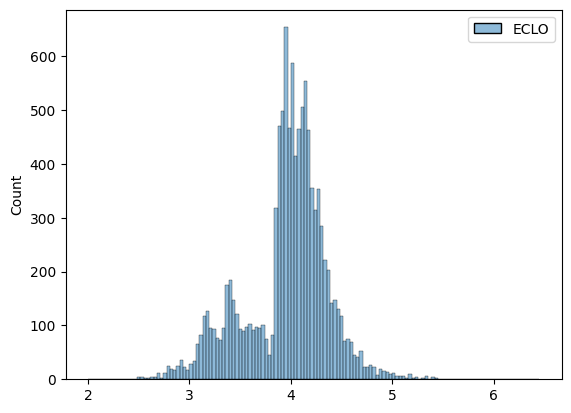

In [ ]:
sns.histplot(submission_df)

# Model_18 []

In [ ]:
train_df.columns

Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간',
       '도시', '구', '동', '도로형태1', '도로형태2', '설치형태_건축물', '설치형태_전용주', '설치형태_한전주',
       '설치개수', '설치개수평균', '시설종류_어린이집', '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교',
       '시설종류_학원', '관할경찰서명_강북경찰서', '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서',
       '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서', '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서',
       '관할경찰서명_수성경찰서', 'CCTV설치여부_N', 'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수',
       'CCTV설치대수평균', '급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료',
       '결제방법_신용카드', '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도'],
      dtype='object')

In [ ]:
train = train_df.copy()
test = test_df.copy()

In [ ]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [ ]:
for i in  ['동']:
  _ant =  (train.groupby([i])['ECLO'].mean() < 4).astype(int)
  train = pd.merge(train, _ant, how='left', on=[i])
  test = pd.merge(test, _ant, how='left', on=[i])

  train.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)
  test.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)

  train = train.drop(columns=[i])
  test = test.drop(columns=[i])

In [ ]:
test.rename(columns={'ECLO':'new동'}, inplace=True)

In [ ]:
test_x = test[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주','월'
                  ,'시간','설치개수평균', '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도','new동',
                   '설치형태_한전주','설치개수', '주차구획수', '주차구획수평균', '제한속도']].copy()
train_x = train[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주','월'
                  ,'시간','설치개수평균', '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도','new동',
                   '설치형태_한전주','설치개수', '주차구획수', '주차구획수평균', '제한속도']].copy()
train_y = train['ECLO'].copy()

In [ ]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   요일            39609 non-null  object 
 1   노면상태          39609 non-null  object 
 2   사고유형          39609 non-null  object 
 3   도로형태2         39609 non-null  object 
 4   설치형태_건축물      39609 non-null  float64
 5   설치형태_전용주      39609 non-null  float64
 6   월             39609 non-null  int64  
 7   시간            39609 non-null  int64  
 8   설치개수평균        39609 non-null  float64
 9   관할경찰서명_달성경찰서  39609 non-null  float64
 10  CCTV설치여부_N    39609 non-null  float64
 11  주차기본요금        39609 non-null  float64
 12  설치연도          39609 non-null  float64
 13  new동          39609 non-null  int64  
 14  설치형태_한전주      39609 non-null  float64
 15  설치개수          39609 non-null  float64
 16  주차구획수         39609 non-null  float64
 17  주차구획수평균       39609 non-null  float64
 18  제한속도          39609 non-nu

In [ ]:
def one_hot(df):

    # one-hot encoding 실시
    df = pd.get_dummies(df)

    return df

In [ ]:
X_train_eng = one_hot(train_x)
X_test_eng = one_hot(test_x)

y_train = np.log(train_y)

In [ ]:
X_train_eng.fillna(0, inplace=True)
X_test_eng.fillna(0, inplace=True)

In [ ]:
print(f'X_train 데이터 shape : {X_train_eng.shape}')
print(f'y_train 데이터 shape : {y_train.shape}')
print()
print(f'X_test 데이터 shape : {X_test_eng.shape}')

X_train 데이터 shape : (39609, 41)
y_train 데이터 shape : (39609,)

X_test 데이터 shape : (10963, 41)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_eng, y_train , test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
import numpy as np

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

from sklearn.metrics import make_scorer

# RMSLE를 평가 지표로 변환
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

## LGBMRegressor 모델

In [ ]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# LGBM Regressor 모델 생성
lgbm = LGBMRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [300, 400, 500, 800, 1200]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_lgbm.best_params_)
print("최적의 점수:", grid_search_lgbm.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
lgbm_best = LGBMRegressor(**grid_search_lgbm.best_params_,random_state=42)

# 모델 학습
lgbm_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = lgbm_best.predict(X_train)
y_val_pred = lgbm_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 806
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 37
[LightGBM] [Info] Start training from score 1.383856
최적의 하이퍼파라미터: {'learning_rate': 0.01, 'n_estimators': 400, 'num_leaves': 10}
최적의 점수: 0.0317610295471518
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 806
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 37
[LightGBM] [Info] Start training from score 1.383856
0.44317835606916245
0.4456115920630418


## RandomForestRegressor 모델

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

# Random Forest Regressor 모델 생성
rf = RandomForestRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [8, 10, 12]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_rf.best_params_)
print("최적의 점수:", grid_search_rf.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
rf_best = RandomForestRegressor(**grid_search_rf.best_params_,random_state=42)

# 모델 학습
rf_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = rf_best.predict(X_train)
y_val_pred = rf_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'max_depth': 10, 'min_samples_split': 12, 'n_estimators': 300}
최적의 점수: 0.027642217021221605
0.42728171046726143
0.44671104446599136


## XGBRegressor 모델

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# XGB Regressor 모델 생성
xgb = XGBRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_xgb.best_params_)
print("최적의 점수:", grid_search_xgb.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
xgb_best = XGBRegressor(**grid_search_xgb.best_params_,random_state=42)

# 모델 학습
xgb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = xgb_best.predict(X_train)
y_val_pred = xgb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

## GradientBoosting

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
model = GradientBoostingRegressor()

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],  # 트리 개수
    'learning_rate': [0.01, 0.1, 0.2],  # 학습률
    'max_depth': [3, 4, 5]  # 트리 최대 깊이
}

# GridSearchCV를 사용하여 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

gb_best = grid_search.best_estimator_

gb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = gb_best.predict(X_train)
y_val_pred = gb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

## Stack

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

In [ ]:
# 개별 모델 생성
rf = rf_best
lgbm = lgbm_best
xgb = xgb_best
gb = gb_best


# 스태킹 앙상블 모델 생성
estimators = [
    ('rf', rf),
    ('lgbm', lgbm),
    ('xgb', xgb),
    ('gb', gb)
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# 모델 학습
stacking_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = stacking_model.predict(X_train)
y_val_pred = stacking_model.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 806
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 37
[LightGBM] [Info] Start training from score 1.383856
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 804
[LightGBM] [Info] Number of data points in the train set: 25349, number of used features: 37
[LightGBM] [Info] Start training from score 1.386939
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

In [ ]:
y_pred1 = stacking_model.predict(X_test_eng)
y_pred1

In [ ]:
y_pred = np.exp(y_pred1)
y_pred

In [ ]:
submission_df['ECLO'] = y_pred
submission_df.head()

In [ ]:
sns.histplot(submission_df)

# Model_19 []

In [ ]:
train_df.columns

Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간',
       '도시', '구', '동', '도로형태1', '도로형태2', '설치형태_건축물', '설치형태_전용주', '설치형태_한전주',
       '설치개수', '설치개수평균', '시설종류_어린이집', '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교',
       '시설종류_학원', '관할경찰서명_강북경찰서', '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서',
       '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서', '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서',
       '관할경찰서명_수성경찰서', 'CCTV설치여부_N', 'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수',
       'CCTV설치대수평균', '급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료',
       '결제방법_신용카드', '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도'],
      dtype='object')

In [ ]:
train = train_df.copy()
test = test_df.copy()

In [ ]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [ ]:
for i in  ['동']:
  _ant =  (train.groupby([i])['ECLO'].mean() < 4).astype(int)
  train = pd.merge(train, _ant, how='left', on=[i])
  test = pd.merge(test, _ant, how='left', on=[i])

  train.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)
  test.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)

  train = train.drop(columns=[i])
  test = test.drop(columns=[i])

In [ ]:
test.rename(columns={'ECLO':'new동'}, inplace=True)

In [ ]:
test_x = test[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주','일'
                  ,'시간','설치개수평균', '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도','new동',
                   '설치형태_한전주','설치개수', '주차구획수', '주차구획수평균', '제한속도']].copy()
train_x = train[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주','일'
                  ,'시간','설치개수평균', '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도','new동',
                   '설치형태_한전주','설치개수', '주차구획수', '주차구획수평균', '제한속도']].copy()
train_y = train['ECLO'].copy()

In [ ]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   요일            39609 non-null  object 
 1   노면상태          39609 non-null  object 
 2   사고유형          39609 non-null  object 
 3   도로형태2         39609 non-null  object 
 4   설치형태_건축물      39609 non-null  float64
 5   설치형태_전용주      39609 non-null  float64
 6   일             39609 non-null  int64  
 7   시간            39609 non-null  int64  
 8   설치개수평균        39609 non-null  float64
 9   관할경찰서명_달성경찰서  39609 non-null  float64
 10  CCTV설치여부_N    39609 non-null  float64
 11  주차기본요금        39609 non-null  float64
 12  설치연도          39609 non-null  float64
 13  new동          39609 non-null  int64  
 14  설치형태_한전주      39609 non-null  float64
 15  설치개수          39609 non-null  float64
 16  주차구획수         39609 non-null  float64
 17  주차구획수평균       39609 non-null  float64
 18  제한속도          39609 non-nu

In [ ]:
def one_hot(df):

    # one-hot encoding 실시
    df = pd.get_dummies(df)

    return df

In [ ]:
X_train_eng = one_hot(train_x)
X_test_eng = one_hot(test_x)

y_train = np.log(train_y)

In [ ]:
X_train_eng.fillna(0, inplace=True)
X_test_eng.fillna(0, inplace=True)

In [ ]:
print(f'X_train 데이터 shape : {X_train_eng.shape}')
print(f'y_train 데이터 shape : {y_train.shape}')
print()
print(f'X_test 데이터 shape : {X_test_eng.shape}')

X_train 데이터 shape : (39609, 41)
y_train 데이터 shape : (39609,)

X_test 데이터 shape : (10963, 41)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_eng, y_train , test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
import numpy as np

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

from sklearn.metrics import make_scorer

# RMSLE를 평가 지표로 변환
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

## LGBMRegressor 모델

In [ ]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# LGBM Regressor 모델 생성
lgbm = LGBMRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [300, 400, 500, 800, 1200]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_lgbm.best_params_)
print("최적의 점수:", grid_search_lgbm.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
lgbm_best = LGBMRegressor(**grid_search_lgbm.best_params_,random_state=42)

# 모델 학습
lgbm_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = lgbm_best.predict(X_train)
y_val_pred = lgbm_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 825
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 37
[LightGBM] [Info] Start training from score 1.383856
최적의 하이퍼파라미터: {'learning_rate': 0.01, 'n_estimators': 400, 'num_leaves': 10}
최적의 점수: 0.03156804644598173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 825
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 37
[LightGBM] [Info] Start training from score 1.383856
0.4432171987778867
0.44567752821163853


## RandomForestRegressor 모델

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

# Random Forest Regressor 모델 생성
rf = RandomForestRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [8, 10, 12]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_rf.best_params_)
print("최적의 점수:", grid_search_rf.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
rf_best = RandomForestRegressor(**grid_search_rf.best_params_,random_state=42)

# 모델 학습
rf_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = rf_best.predict(X_train)
y_val_pred = rf_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

## XGBRegressor 모델

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# XGB Regressor 모델 생성
xgb = XGBRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_xgb.best_params_)
print("최적의 점수:", grid_search_xgb.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
xgb_best = XGBRegressor(**grid_search_xgb.best_params_,random_state=42)

# 모델 학습
xgb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = xgb_best.predict(X_train)
y_val_pred = xgb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

## GradientBoosting

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
model = GradientBoostingRegressor()

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],  # 트리 개수
    'learning_rate': [0.01, 0.1, 0.2],  # 학습률
    'max_depth': [3, 4, 5]  # 트리 최대 깊이
}

# GridSearchCV를 사용하여 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

gb_best = grid_search.best_estimator_

gb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = gb_best.predict(X_train)
y_val_pred = gb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

## Stack

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

In [ ]:
# 개별 모델 생성
rf = rf_best
lgbm = lgbm_best
xgb = xgb_best
gb = gb_best


# 스태킹 앙상블 모델 생성
estimators = [
    ('rf', rf),
    ('lgbm', lgbm),
    ('xgb', xgb),
    ('gb', gb)
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# 모델 학습
stacking_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = stacking_model.predict(X_train)
y_val_pred = stacking_model.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

In [ ]:
y_pred1 = stacking_model.predict(X_test_eng)
y_pred1

In [ ]:
y_pred = np.exp(y_pred1)
y_pred

In [ ]:
submission_df['ECLO'] = y_pred
submission_df.head()

<Axes: ylabel='Count'>

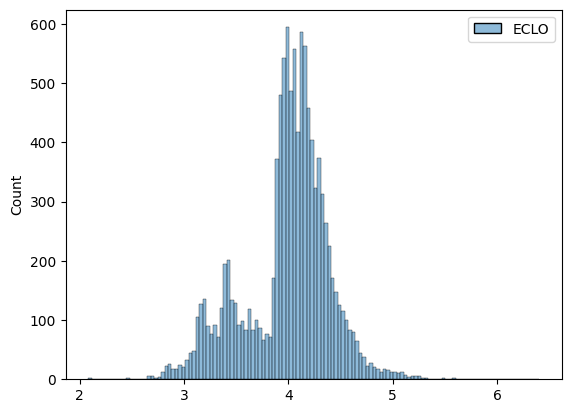

In [ ]:
sns.histplot(submission_df)

# Model_20 [0.42761]

In [ ]:
train = train_df.copy()
test = test_df.copy()

In [ ]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [ ]:
for i in  ['동']:
  _ant =  (train.groupby([i])['ECLO'].mean() < 4).astype(int)
  train = pd.merge(train, _ant, how='left', on=[i])
  test = pd.merge(test, _ant, how='left', on=[i])

  train.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)
  test.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)

  train = train.drop(columns=[i])
  test = test.drop(columns=[i])

In [ ]:
test.rename(columns={'ECLO':'new동'}, inplace=True)

In [ ]:
test_x = test[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'설치형태_한전주','시간','설치개수','설치개수평균','주차구획수','new동',
                  '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도', '제한속도']].copy()
train_x = train[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'설치형태_한전주','시간','설치개수','설치개수평균','주차구획수','new동',
                  '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도', '제한속도']].copy()
train_y = train['ECLO'].copy()

## 시간 별 칼럼별 ECLO 평균

In [ ]:
def time_range(time):
  if time >= 0 and time <= 7 :
    return 1
  elif time <= 12 :
    return 2
  elif time <= 18 :
    return 3
  else :
    return 4

train_x['time_range'] = train_x['시간'].apply(time_range)
test_x['time_range'] = test_x['시간'].apply(time_range)

In [ ]:
def time_carBycar(data):
  if data['사고유형'] == '차대차':
    if data['time_range'] == 1:
      return 1
    elif data['time_range'] == 4:
      return 1
    else:
      return 2
  elif data['사고유형'] == '차대사람' and data['time_range'] == 3:
    return 0
  else:
    return 2


train_x['time_carBycar_data'] = train_x.apply(time_carBycar, axis = 1)
test_x['time_carBycar_data'] = test_x.apply(time_carBycar, axis = 1)
train_x.head()

## ECLOO 평균이 5 이상인 차대차 이면서 새벽과 늦은저녁인 행은 1
## ECLO가 가장 낮은 오후이면서 차대 사람이면 행은 2
## 나머지는 3으로

,요일,노면상태,사고유형,도로형태2,설치형태_건축물,설치형태_전용주,설치형태_한전주,시간,설치개수,설치개수평균,주차구획수,new동,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도,time_range,time_carBycar_data
0,화요일,건조,차대사람,기타,177.0,30.0,135.0,0,391.0,1.00,500.0,0,0.0,0.0,1136.36,2013.00,8.0,1,2
1,화요일,건조,차대사람,기타,0.0,0.0,0.0,0,932.0,1.00,114.0,0,0.0,0.0,150.00,2015.33,17.5,1,2
2,화요일,건조,차대사람,기타,14.0,31.0,425.0,1,473.0,1.00,0.0,0,0.0,0.0,0.00,2018.25,55.0,1,2
3,화요일,건조,차대차,기타,0.0,0.0,0.0,2,534.0,1.00,374.0,0,0.0,2.0,71.43,2018.30,38.0,1,1
4,화요일,건조,차대차,기타,540.0,57.0,1396.0,4,2057.0,1.03,63.0,0,0.0,0.0,600.00,2018.25,40.0,1,1


In [ ]:
def time_road(data):
  if data['도로형태2'] == '터널':
    return 1
  elif data['도로형태2'] == '고가도로위':
    if data['time_range'] == 1 or data['time_range'] == 4:
      return 1
    else:
      return 0
  elif data['도로형태2'] == '주차장':
    return 2
  elif data['도로형태2'] == '미분류':
    return 2
  else :
    return 0

train_x['time_road_data'] = train_x.apply(time_road, axis = 1)
test_x['time_road_data'] = test_x.apply(time_road, axis = 1)
train_x.head()

,요일,노면상태,사고유형,도로형태2,설치형태_건축물,설치형태_전용주,설치형태_한전주,시간,설치개수,설치개수평균,주차구획수,new동,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도,time_range,time_carBycar_data,time_road_data
0,화요일,건조,차대사람,기타,177.0,30.0,135.0,0,391.0,1.00,500.0,0,0.0,0.0,1136.36,2013.00,8.0,1,2,0
1,화요일,건조,차대사람,기타,0.0,0.0,0.0,0,932.0,1.00,114.0,0,0.0,0.0,150.00,2015.33,17.5,1,2,0
2,화요일,건조,차대사람,기타,14.0,31.0,425.0,1,473.0,1.00,0.0,0,0.0,0.0,0.00,2018.25,55.0,1,2,0
3,화요일,건조,차대차,기타,0.0,0.0,0.0,2,534.0,1.00,374.0,0,0.0,2.0,71.43,2018.30,38.0,1,1,0
4,화요일,건조,차대차,기타,540.0,57.0,1396.0,4,2057.0,1.03,63.0,0,0.0,0.0,600.00,2018.25,40.0,1,1,0


## 요일별 칼럼별 ECLO 평균

- 요일별 시간

In [ ]:
def sun_time_acci(data):
  if data['요일'] == '일요일':
    if data['time_range'] == 2 or data['time_range'] == 3:
      return 1
    else:
      return 0
  else:
    return 0

train_x['sun_timed_data'] = train_x.apply(sun_time_acci, axis = 1)
test_x['sun_timed_data'] = test_x.apply(sun_time_acci, axis = 1)
train_x.head()

,요일,노면상태,사고유형,도로형태2,설치형태_건축물,설치형태_전용주,설치형태_한전주,시간,설치개수,설치개수평균,주차구획수,new동,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도,time_range,time_carBycar_data,time_road_data,sun_timed_data
0,화요일,건조,차대사람,기타,177.0,30.0,135.0,0,391.0,1.00,500.0,0,0.0,0.0,1136.36,2013.00,8.0,1,2,0,0
1,화요일,건조,차대사람,기타,0.0,0.0,0.0,0,932.0,1.00,114.0,0,0.0,0.0,150.00,2015.33,17.5,1,2,0,0
2,화요일,건조,차대사람,기타,14.0,31.0,425.0,1,473.0,1.00,0.0,0,0.0,0.0,0.00,2018.25,55.0,1,2,0,0
3,화요일,건조,차대차,기타,0.0,0.0,0.0,2,534.0,1.00,374.0,0,0.0,2.0,71.43,2018.30,38.0,1,1,0,0
4,화요일,건조,차대차,기타,540.0,57.0,1396.0,4,2057.0,1.03,63.0,0,0.0,0.0,600.00,2018.25,40.0,1,1,0,0


- 요일별 사고유형

In [ ]:
def day_carBy(data):
  if data['사고유형'] == '차대차':
    if data['요일'] == '일요일':
      return 1
    elif data['요일'] == '토요일':
      return 1
    else :
      return 0
  elif data['사고유형'] == '차량단독':
    if data['요일'] == '수요일':
      return 2
    else:
      return 0
  elif data['사고유형'] == '차대사람' and data['요일'] == '목요일':
    return 2
  else:
    return 0

train_x['day_carBy_data'] = train_x.apply(day_carBy, axis = 1)
test_x['day_carBy_data'] = test_x.apply(day_carBy, axis = 1)
train_x.head()

,요일,노면상태,사고유형,도로형태2,설치형태_건축물,설치형태_전용주,설치형태_한전주,시간,설치개수,설치개수평균,주차구획수,new동,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도,time_range,time_carBycar_data,time_road_data,sun_timed_data,day_carBy_data
0,화요일,건조,차대사람,기타,177.0,30.0,135.0,0,391.0,1.00,500.0,0,0.0,0.0,1136.36,2013.00,8.0,1,2,0,0,0
1,화요일,건조,차대사람,기타,0.0,0.0,0.0,0,932.0,1.00,114.0,0,0.0,0.0,150.00,2015.33,17.5,1,2,0,0,0
2,화요일,건조,차대사람,기타,14.0,31.0,425.0,1,473.0,1.00,0.0,0,0.0,0.0,0.00,2018.25,55.0,1,2,0,0,0
3,화요일,건조,차대차,기타,0.0,0.0,0.0,2,534.0,1.00,374.0,0,0.0,2.0,71.43,2018.30,38.0,1,1,0,0,0
4,화요일,건조,차대차,기타,540.0,57.0,1396.0,4,2057.0,1.03,63.0,0,0.0,0.0,600.00,2018.25,40.0,1,1,0,0,0


In [ ]:
def one_hot(df):

    # one-hot encoding 실시
    df = pd.get_dummies(df)

    return df

In [ ]:
X_train_eng = one_hot(train_x)
X_test_eng = one_hot(test_x)

y_train = np.log(train_y)

In [ ]:
X_train_eng.fillna(0, inplace=True)
X_test_eng.fillna(0, inplace=True)

In [ ]:
print(f'X_train 데이터 shape : {X_train_eng.shape}')
print(f'y_train 데이터 shape : {y_train.shape}')
print()
print(f'X_test 데이터 shape : {X_test_eng.shape}')

X_train 데이터 shape : (39609, 44)
y_train 데이터 shape : (39609,)

X_test 데이터 shape : (10963, 44)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_eng, y_train , test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
import numpy as np

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

from sklearn.metrics import make_scorer

# RMSLE를 평가 지표로 변환
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

## LGBMRegressor 모델

In [ ]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# LGBM Regressor 모델 생성
lgbm = LGBMRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [300, 400, 500, 800, 1200]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_lgbm.best_params_)
print("최적의 점수:", grid_search_lgbm.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
lgbm_best = LGBMRegressor(**grid_search_lgbm.best_params_,random_state=42)

# 모델 학습
lgbm_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = lgbm_best.predict(X_train)
y_val_pred = lgbm_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

KeyboardInterrupt: ignored

## RandomForestRegressor 모델

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

# Random Forest Regressor 모델 생성
rf = RandomForestRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [8, 10, 12]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_rf.best_params_)
print("최적의 점수:", grid_search_rf.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
rf_best = RandomForestRegressor(**grid_search_rf.best_params_,random_state=42)

# 모델 학습
rf_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = rf_best.predict(X_train)
y_val_pred = rf_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

## XGBRegressor 모델

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# XGB Regressor 모델 생성
xgb = XGBRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_xgb.best_params_)
print("최적의 점수:", grid_search_xgb.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
xgb_best = XGBRegressor(**grid_search_xgb.best_params_,random_state=42)

# 모델 학습
xgb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = xgb_best.predict(X_train)
y_val_pred = xgb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

## GradientBoosting

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
model = GradientBoostingRegressor()

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],  # 트리 개수
    'learning_rate': [0.01, 0.1, 0.2],  # 학습률
    'max_depth': [3, 4, 5]  # 트리 최대 깊이
}

# GridSearchCV를 사용하여 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

gb_best = grid_search.best_estimator_

gb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = gb_best.predict(X_train)
y_val_pred = gb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

## Stack

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

In [ ]:
# 개별 모델 생성
rf = rf_best
lgbm = lgbm_best
xgb = xgb_best
gb = gb_best


# 스태킹 앙상블 모델 생성
estimators = [
    ('rf', rf),
    ('lgbm', lgbm),
    ('xgb', xgb),
    ('gb', gb)
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# 모델 학습
stacking_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = stacking_model.predict(X_train)
y_val_pred = stacking_model.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

In [ ]:
X_train.head()

In [ ]:
X_test_eng.head()

In [ ]:
if not all(X_train.columns == X_test_eng.columns):
  X_test_eng = X_test_eng[X_train.columns]

In [ ]:
y_pred1 = stacking_model.predict(X_test_eng)
y_pred1

In [ ]:
y_pred = np.exp(y_pred1)
y_pred

In [ ]:
submission_df['ECLO'] = y_pred
submission_df.head()

In [ ]:
sns.histplot(submission_df)

# Model_21 []

In [ ]:
train = train_df.copy()
test = test_df.copy()

In [ ]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [ ]:
for i in  ['동']:
  _ant =  (train.groupby([i])['ECLO'].mean() < 4).astype(int)
  train = pd.merge(train, _ant, how='left', on=[i])
  test = pd.merge(test, _ant, how='left', on=[i])

  train.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)
  test.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)

  train = train.drop(columns=[i])
  test = test.drop(columns=[i])

In [ ]:
test.rename(columns={'ECLO':'new동'}, inplace=True)

In [ ]:
test_x = test[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'설치형태_한전주','시간','설치개수','설치개수평균','주차구획수','new동',
                  '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도', '제한속도']].copy()
train_x = train[['요일', '노면상태', '사고유형','도로형태2', '설치형태_건축물','설치형태_전용주'
                  ,'설치형태_한전주','시간','설치개수','설치개수평균','주차구획수','new동',
                  '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도', '제한속도']].copy()
train_y = train['ECLO'].copy()

## 시간 별 칼럼별 ECLO 평균

In [ ]:
def time_range(time):
  if time >= 0 and time <= 7 :
    return 1
  elif time <= 12 :
    return 2
  elif time <= 18 :
    return 3
  else :
    return 4

train_df['time_range'] = train_df['시간'].apply(time_range)

In [ ]:
def time_range(time):
  if time >= 0 and time <= 7 :
    return 1
  elif time <= 12 :
    return 2
  elif time <= 18 :
    return 3
  else :
    return 4

train_x['time_range'] = train_x['시간'].apply(time_range)
test_x['time_range'] = test_x['시간'].apply(time_range)

In [ ]:
time_accident_data = train_df[(train_df['time_range'] == 1) & (train_df['사고유형'] == '차대차')]
time_accident_data.shape

(3942, 68)

In [ ]:
def time_carBycar(data):
  if data['사고유형'] == '차대차':
    if data['time_range'] == 1:
      return 1
    elif data['time_range'] == 4:
      return 1
    else:
      return 2
  elif data['사고유형'] == '차대사람' and data['time_range'] == 3:
    return 0
  else:
    return 2


train_x['time_carBycar_data'] = train_x.apply(time_carBycar, axis = 1)
test_x['time_carBycar_data'] = test_x.apply(time_carBycar, axis = 1)
train_x.head()

## ECLOO 평균이 5 이상인 차대차 이면서 새벽과 늦은저녁인 행은 1
## ECLO가 가장 낮은 오후이면서 차대 사람이면 행은 2
## 나머지는 3으로

,요일,노면상태,사고유형,도로형태2,설치형태_건축물,설치형태_전용주,설치형태_한전주,시간,설치개수,설치개수평균,주차구획수,new동,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도,time_range,time_carBycar_data
0,화요일,건조,차대사람,기타,177.0,30.0,135.0,0,391.0,1.00,500.0,0,0.0,0.0,1136.36,2013.00,8.0,1,2
1,화요일,건조,차대사람,기타,0.0,0.0,0.0,0,932.0,1.00,114.0,0,0.0,0.0,150.00,2015.33,17.5,1,2
2,화요일,건조,차대사람,기타,14.0,31.0,425.0,1,473.0,1.00,0.0,0,0.0,0.0,0.00,2018.25,55.0,1,2
3,화요일,건조,차대차,기타,0.0,0.0,0.0,2,534.0,1.00,374.0,0,0.0,2.0,71.43,2018.30,38.0,1,1
4,화요일,건조,차대차,기타,540.0,57.0,1396.0,4,2057.0,1.03,63.0,0,0.0,0.0,600.00,2018.25,40.0,1,1


In [ ]:
time_land_data = train_df[(train_df['time_range'] == 1) & (train_df['노면상태'] == '건조')]
time_land_data.shape

# ECLO 분포가 에매한것 같아서 일단 보류

(4627, 68)

In [ ]:
time_road_data = train_df[(train_df['time_range'] == 2) & (train_df['도로형태2'] == '터널')]
time_road_data.shape

(19, 68)

In [ ]:
def time_road(data):
  if data['도로형태2'] == '터널':
    return 1
  elif data['도로형태2'] == '고가도로위':
    if data['time_range'] == 1 or data['time_range'] == 4:
      return 1
    else:
      return 0
  elif data['도로형태2'] == '주차장':
    return 2
  elif data['도로형태2'] == '미분류':
    return 2
  else :
    return 0

train_x['time_road_data'] = train_x.apply(time_road, axis = 1)
test_x['time_road_data'] = test_x.apply(time_road, axis = 1)
train_x.head()

,요일,노면상태,사고유형,도로형태2,설치형태_건축물,설치형태_전용주,설치형태_한전주,시간,설치개수,설치개수평균,주차구획수,new동,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도,time_range,time_carBycar_data,time_road_data
0,화요일,건조,차대사람,기타,177.0,30.0,135.0,0,391.0,1.00,500.0,0,0.0,0.0,1136.36,2013.00,8.0,1,2,0
1,화요일,건조,차대사람,기타,0.0,0.0,0.0,0,932.0,1.00,114.0,0,0.0,0.0,150.00,2015.33,17.5,1,2,0
2,화요일,건조,차대사람,기타,14.0,31.0,425.0,1,473.0,1.00,0.0,0,0.0,0.0,0.00,2018.25,55.0,1,2,0
3,화요일,건조,차대차,기타,0.0,0.0,0.0,2,534.0,1.00,374.0,0,0.0,2.0,71.43,2018.30,38.0,1,1,0
4,화요일,건조,차대차,기타,540.0,57.0,1396.0,4,2057.0,1.03,63.0,0,0.0,0.0,600.00,2018.25,40.0,1,1,0


## 요일별 칼럼별 ECLO 평균

- 요일별 시간

In [ ]:
day_land_data = train_df[(train_df['요일'] == '금요일') & (train_df['time_range'] == 3)]
day_land_data.shape


(2500, 68)

In [ ]:
def sun_time_acci(data):
  if data['요일'] == '일요일':
    if data['time_range'] == 2 or data['time_range'] == 3:
      return 1
    else:
      return 0
  else:
    return 0

train_x['sun_timed_data'] = train_x.apply(sun_time_acci, axis = 1)
test_x['sun_timed_data'] = test_x.apply(sun_time_acci, axis = 1)
train_x.head()

,요일,노면상태,사고유형,도로형태2,설치형태_건축물,설치형태_전용주,설치형태_한전주,시간,설치개수,설치개수평균,주차구획수,new동,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도,time_range,time_carBycar_data,time_road_data,sun_timed_data
0,화요일,건조,차대사람,기타,177.0,30.0,135.0,0,391.0,1.00,500.0,0,0.0,0.0,1136.36,2013.00,8.0,1,2,0,0
1,화요일,건조,차대사람,기타,0.0,0.0,0.0,0,932.0,1.00,114.0,0,0.0,0.0,150.00,2015.33,17.5,1,2,0,0
2,화요일,건조,차대사람,기타,14.0,31.0,425.0,1,473.0,1.00,0.0,0,0.0,0.0,0.00,2018.25,55.0,1,2,0,0
3,화요일,건조,차대차,기타,0.0,0.0,0.0,2,534.0,1.00,374.0,0,0.0,2.0,71.43,2018.30,38.0,1,1,0,0
4,화요일,건조,차대차,기타,540.0,57.0,1396.0,4,2057.0,1.03,63.0,0,0.0,0.0,600.00,2018.25,40.0,1,1,0,0


- 요일별 사고유형

In [ ]:
day_acci_data = train_df[(train_df['요일'] == '수요일') & (train_df['사고유형'] == '차량단독')]
day_acci_data.shape

(137, 68)

In [ ]:
def day_carBy(data):
  if data['사고유형'] == '차대차':
    if data['요일'] == '일요일':
      return 1
    elif data['요일'] == '토요일':
      return 1
    else :
      return 0
  elif data['사고유형'] == '차량단독':
    if data['요일'] == '수요일':
      return 2
    else:
      return 0
  elif data['사고유형'] == '차대사람' and data['요일'] == '목요일':
    return 2
  else:
    return 0

train_x['day_carBy_data'] = train_x.apply(day_carBy, axis = 1)
test_x['day_carBy_data'] = test_x.apply(day_carBy, axis = 1)
train_x.head()

,요일,노면상태,사고유형,도로형태2,설치형태_건축물,설치형태_전용주,설치형태_한전주,시간,설치개수,설치개수평균,주차구획수,new동,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도,time_range,time_carBycar_data,time_road_data,sun_timed_data,day_carBy_data
0,화요일,건조,차대사람,기타,177.0,30.0,135.0,0,391.0,1.00,500.0,0,0.0,0.0,1136.36,2013.00,8.0,1,2,0,0,0
1,화요일,건조,차대사람,기타,0.0,0.0,0.0,0,932.0,1.00,114.0,0,0.0,0.0,150.00,2015.33,17.5,1,2,0,0,0
2,화요일,건조,차대사람,기타,14.0,31.0,425.0,1,473.0,1.00,0.0,0,0.0,0.0,0.00,2018.25,55.0,1,2,0,0,0
3,화요일,건조,차대차,기타,0.0,0.0,0.0,2,534.0,1.00,374.0,0,0.0,2.0,71.43,2018.30,38.0,1,1,0,0,0
4,화요일,건조,차대차,기타,540.0,57.0,1396.0,4,2057.0,1.03,63.0,0,0.0,0.0,600.00,2018.25,40.0,1,1,0,0,0


In [ ]:
train_x.drop(columns = ['설치형태_전용주','설치형태_한전주','설치연도'])
test_x.drop(columns = ['설치형태_전용주','설치형태_한전주','설치연도'])

,요일,노면상태,사고유형,도로형태2,설치형태_건축물,시간,설치개수,설치개수평균,주차구획수,new동,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,제한속도,time_range,time_carBycar_data,time_road_data,sun_timed_data,day_carBy_data
0,토요일,건조,차대사람,교차로안,104.0,1,700.0,1.00,0.0,0,0.0,0.0,0.00,52.50,1,2,0,0,0
1,토요일,건조,차대사람,기타,0.0,1,0.0,0.00,183.0,0,0.0,0.0,700.00,47.14,1,2,0,0,0
2,토요일,건조,차대차,교차로안,0.0,4,0.0,0.00,0.0,0,0.0,0.0,0.00,40.00,1,1,0,0,1
3,토요일,건조,차대차,기타,0.0,4,0.0,0.00,153.0,0,0.0,0.0,333.33,42.73,1,1,0,0,1
4,토요일,건조,차대차,교차로안,0.0,6,932.0,1.00,114.0,0,0.0,0.0,150.00,17.50,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,토요일,건조,차대차,터널,1647.0,18,5377.0,1.02,709.0,0,0.0,0.0,204.76,20.48,3,2,1,0,1
10959,토요일,건조,차대차,기타,0.0,18,0.0,0.00,0.0,0,0.0,0.0,0.00,52.50,3,2,0,0,1
10960,토요일,건조,차대차,기타,0.0,20,0.0,0.00,0.0,0,0.0,0.0,0.00,0.00,4,1,0,0,1
10961,토요일,건조,차대차,교차로부근,0.0,20,0.0,0.00,0.0,0,0.0,0.0,0.00,44.29,4,1,0,0,1


In [ ]:
def one_hot(df):

    # one-hot encoding 실시
    df = pd.get_dummies(df)

    return df

In [ ]:
X_train_eng = one_hot(train_x)
X_test_eng = one_hot(test_x)

y_train = np.log(train_y)

In [ ]:
X_train_eng.fillna(0, inplace=True)
X_test_eng.fillna(0, inplace=True)

In [ ]:
print(f'X_train 데이터 shape : {X_train_eng.shape}')
print(f'y_train 데이터 shape : {y_train.shape}')
print()
print(f'X_test 데이터 shape : {X_test_eng.shape}')

X_train 데이터 shape : (39609, 44)
y_train 데이터 shape : (39609,)

X_test 데이터 shape : (10963, 44)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_eng, y_train , test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
import numpy as np

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

from sklearn.metrics import make_scorer

# RMSLE를 평가 지표로 변환
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

## LGBMRegressor 모델

In [ ]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# LGBM Regressor 모델 생성
lgbm = LGBMRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [300, 400, 500, 800, 1200]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_lgbm.best_params_)
print("최적의 점수:", grid_search_lgbm.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
lgbm_best = LGBMRegressor(**grid_search_lgbm.best_params_,random_state=42)

# 모델 학습
lgbm_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = lgbm_best.predict(X_train)
y_val_pred = lgbm_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 40
[LightGBM] [Info] Start training from score 1.383856
최적의 하이퍼파라미터: {'learning_rate': 0.01, 'n_estimators': 400, 'num_leaves': 10}
최적의 점수: 0.03195288819326925
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 40
[LightGBM] [Info] Start training from score 1.383856
0.44333226259850317
0.4455406142932278


## RandomForestRegressor 모델

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

# Random Forest Regressor 모델 생성
rf = RandomForestRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [8, 10, 12]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_rf.best_params_)
print("최적의 점수:", grid_search_rf.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
rf_best = RandomForestRegressor(**grid_search_rf.best_params_,random_state=42)

# 모델 학습
rf_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = rf_best.predict(X_train)
y_val_pred = rf_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'max_depth': 10, 'min_samples_split': 12, 'n_estimators': 300}
최적의 점수: 0.026184974627037172
0.42830407751718624
0.4469741876733943


## XGBRegressor 모델

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# XGB Regressor 모델 생성
xgb = XGBRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_xgb.best_params_)
print("최적의 점수:", grid_search_xgb.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
xgb_best = XGBRegressor(**grid_search_xgb.best_params_,random_state=42)

# 모델 학습
xgb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = xgb_best.predict(X_train)
y_val_pred = xgb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
최적의 점수: 0.03224937756331588
0.44397613980931366
0.4457401851199401


## GradientBoosting

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
model = GradientBoostingRegressor()

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],  # 트리 개수
    'learning_rate': [0.01, 0.1, 0.2],  # 학습률
    'max_depth': [3, 4, 5]  # 트리 최대 깊이
}

# GridSearchCV를 사용하여 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

gb_best = grid_search.best_estimator_

gb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = gb_best.predict(X_train)
y_val_pred = gb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

0.44385535074519566
0.4457180526244482


## Stack

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

In [ ]:
# 개별 모델 생성
rf = rf_best
lgbm = lgbm_best
xgb = xgb_best
gb = gb_best


# 스태킹 앙상블 모델 생성
estimators = [
    ('rf', rf),
    ('lgbm', lgbm),
    ('xgb', xgb),
    ('gb', gb)
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# 모델 학습
stacking_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = stacking_model.predict(X_train)
y_val_pred = stacking_model.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 40
[LightGBM] [Info] Start training from score 1.383856
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 25349, number of used features: 40
[LightGBM] [Info] Start training from score 1.386939
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins

In [ ]:
X_train.head()

,설치형태_건축물,설치형태_전용주,설치형태_한전주,시간,설치개수,설치개수평균,주차구획수,new동,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도,time_range,time_carBycar_data,time_road_data,sun_timed_data,day_carBy_data,요일_금요일,요일_목요일,요일_수요일,요일_월요일,요일_일요일,요일_토요일,요일_화요일,노면상태_건조,노면상태_기타,노면상태_서리/결빙,노면상태_적설,노면상태_젖음/습기,노면상태_침수,사고유형_차대사람,사고유형_차대차,사고유형_차량단독,도로형태2_고가도로위,도로형태2_교량,도로형태2_교차로부근,도로형태2_교차로안,도로형태2_교차로횡단보도내,도로형태2_기타,도로형태2_미분류,도로형태2_주차장,도로형태2_지하차도(도로)내,도로형태2_터널
19887,5.0,0.0,7.0,18,13.0,1.00,0.0,0,0.0,0.0,0.00,0.00,0.00,3,2,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
17901,0.0,0.0,0.0,13,0.0,0.00,153.0,0,0.0,0.0,333.33,2019.73,42.73,3,2,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
38196,1647.0,20.0,3583.0,14,5377.0,1.02,709.0,0,0.0,0.0,204.76,2016.98,20.48,3,2,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
30365,0.0,0.0,0.0,8,0.0,0.00,0.0,0,0.0,0.0,0.00,2018.69,48.46,2,2,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4562,0.0,0.0,0.0,1,0.0,0.00,1035.0,0,0.0,0.0,33.33,2017.25,50.00,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
X_test_eng.head()

,설치형태_건축물,설치형태_전용주,설치형태_한전주,시간,설치개수,설치개수평균,주차구획수,new동,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도,time_range,time_carBycar_data,time_road_data,sun_timed_data,day_carBy_data,요일_금요일,요일_목요일,요일_수요일,요일_월요일,요일_일요일,요일_토요일,요일_화요일,노면상태_건조,노면상태_기타,노면상태_서리/결빙,노면상태_적설,노면상태_젖음/습기,노면상태_침수,사고유형_차대사람,사고유형_차대차,사고유형_차량단독,도로형태2_고가도로위,도로형태2_교량,도로형태2_교차로부근,도로형태2_교차로안,도로형태2_교차로횡단보도내,도로형태2_기타,도로형태2_미분류,도로형태2_주차장,도로형태2_지하차도(도로)내,도로형태2_터널
0,104.0,16.0,579.0,1,700.0,1.0,0.0,0,0.0,0.0,0.00,2020.00,52.50,1,2,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
1,0.0,0.0,0.0,1,0.0,0.0,183.0,0,0.0,0.0,700.00,2019.14,47.14,1,2,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2,0.0,0.0,0.0,4,0.0,0.0,0.0,0,0.0,0.0,0.00,2020.00,40.00,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
3,0.0,0.0,0.0,4,0.0,0.0,153.0,0,0.0,0.0,333.33,2019.73,42.73,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0.0,0.0,0.0,6,932.0,1.0,114.0,0,0.0,0.0,150.00,2015.33,17.50,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
if not all(X_train.columns == X_test_eng.columns):
  X_test_eng = X_test_eng[X_train.columns]

In [ ]:
y_pred1 = stacking_model.predict(X_test_eng)
y_pred1

array([1.32865246, 1.2497894 , 1.52102157, ..., 1.46998482, 1.46978383,
       1.48366769])

In [ ]:
y_pred = np.exp(y_pred1)
y_pred

array([3.77595172, 3.48960796, 4.57689843, ..., 4.34916913, 4.34829506,
       4.40908721])

In [ ]:
submission_df['ECLO'] = y_pred
submission_df.head()

,ID,ECLO
0,ACCIDENT_39609,3.775952
1,ACCIDENT_39610,3.489608
2,ACCIDENT_39611,4.576898
3,ACCIDENT_39612,4.236519
4,ACCIDENT_39613,4.382393


In [ ]:
submission_df['ECLO'].round(1).value_counts()

4.0    1628
4.1    1446
4.2    1325
3.9    1237
4.3     976
4.4     662
3.4     436
4.5     419
3.5     397
3.2     353
3.3     302
3.7     285
3.6     281
4.6     236
3.8     207
3.1     205
4.7     109
4.8      90
3.0      88
2.9      84
4.9      52
5.0      43
2.8      23
5.1      20
5.3      13
2.7      12
5.2      11
5.4       7
5.7       4
2.6       3
5.5       3
5.9       2
5.6       2
2.5       1
5.8       1
Name: ECLO, dtype: int64

<Axes: ylabel='Count'>

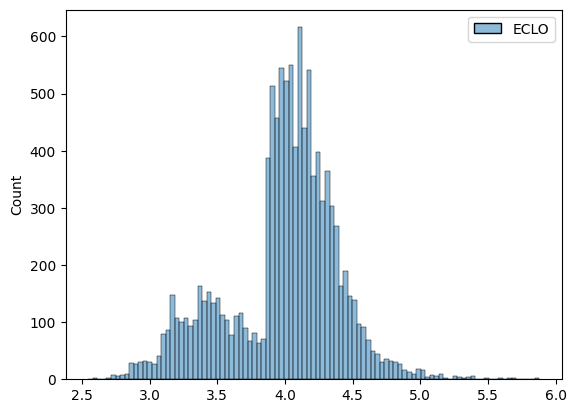

In [ ]:
sns.histplot(submission_df)

# Model_22 []

In [ ]:
train = train_df.copy()
test = test_df.copy()

In [ ]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [ ]:
for i in  ['동']:
  _ant =  (train.groupby([i])['ECLO'].mean() < 4).astype(int)
  train = pd.merge(train, _ant, how='left', on=[i])
  test = pd.merge(test, _ant, how='left', on=[i])

  train.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)
  test.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)

  train = train.drop(columns=[i])
  test = test.drop(columns=[i])

In [ ]:
test.rename(columns={'ECLO':'new동'}, inplace=True)

In [ ]:
for i in ['노면상태','사고유형','도로형태2','요일']:

  _ant = train.groupby(['시간',i])['ECLO'].mean()
  train = pd.merge(train, _ant, how='left', on=['시간',i])
  train.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)
  train = train.drop([i], axis=1)

  test = pd.merge(test, _ant, how='left', on=['시간',i])
  test = test.drop([i], axis=1)

In [ ]:
train.columns

Index(['ID', '기상상태', '도로형태', 'ECLO', '연', '월', '일', '시간', '도시', '구', '도로형태1',
       '설치형태_건축물', '설치형태_전용주', '설치형태_한전주', '설치개수', '설치개수평균', '시설종류_어린이집',
       '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교', '시설종류_학원', '관할경찰서명_강북경찰서',
       '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서', '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서',
       '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서', '관할경찰서명_수성경찰서', 'CCTV설치여부_N',
       'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수', 'CCTV설치대수평균', '급지구분_1',
       '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료', '결제방법_신용카드',
       '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도',
       'new동', 'new노면상태', 'new사고유형', 'new도로형태2', 'new요일'],
      dtype='object')

In [ ]:
test.columns = ['ID', '기상상태', '도로형태', '연', '월', '일', '시간', '도시', '구', '도로형태1',
       '설치형태_건축물', '설치형태_전용주', '설치형태_한전주', '설치개수', '설치개수평균', '시설종류_어린이집',
       '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교', '시설종류_학원', '관할경찰서명_강북경찰서',
       '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서', '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서',
       '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서', '관할경찰서명_수성경찰서', 'CCTV설치여부_N',
       'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수', 'CCTV설치대수평균', '급지구분_1',
       '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료', '결제방법_신용카드',
       '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도',
       'new동', 'new노면상태', 'new사고유형', 'new도로형태2', 'new요일']

In [ ]:
test_x = test[['new노면상태', 'new사고유형', 'new도로형태2', 'new요일', '설치형태_건축물','설치형태_전용주'
                  ,'설치형태_한전주','시간','설치개수','설치개수평균','주차구획수','new동',
                  '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도', '제한속도']].copy()
train_x = train[['new노면상태', 'new사고유형', 'new도로형태2', 'new요일', '설치형태_건축물','설치형태_전용주'
                  ,'설치형태_한전주','시간','설치개수','설치개수평균','주차구획수','new동',
                  '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도', '제한속도']].copy()
train_y = train['ECLO'].copy()

In [ ]:
for k in ['new노면상태', 'new사고유형', 'new도로형태2', 'new요일']:
  train_x['임시1'] = (train_x[k] < 4).astype(int)
  train_x['임시2'] = (train_x[k] >= 5).astype(int) + 1
  train_x[k] = train_x['임시2'] - train_x['임시1']

  test_x['임시1'] = (test_x[k] < 4).astype(int)
  test_x['임시2'] = (test_x[k] >= 5).astype(int) + 1
  test_x[k] = test_x['임시2'] - test_x['임시1']

In [ ]:
train_x[['new노면상태', 'new사고유형', 'new도로형태2', 'new요일']]

,new노면상태,new사고유형,new도로형태2,new요일
0,2,1,1,2
1,2,1,1,2
2,2,0,1,2
3,2,2,1,1
4,2,2,1,2
...,...,...,...,...
39604,1,1,1,1
39605,1,1,1,1
39606,1,2,1,1
39607,1,2,1,1


In [ ]:
def one_hot(df):

    # one-hot encoding 실시
    df = pd.get_dummies(df)

    return df

In [ ]:
X_train_eng = one_hot(train_x)
X_test_eng = one_hot(test_x)

y_train = np.log(train_y)

In [ ]:
X_train_eng.fillna(0, inplace=True)
X_test_eng.fillna(0, inplace=True)

In [ ]:
print(f'X_train 데이터 shape : {X_train_eng.shape}')
print(f'y_train 데이터 shape : {y_train.shape}')
print()
print(f'X_test 데이터 shape : {X_test_eng.shape}')

X_train 데이터 shape : (39609, 19)
y_train 데이터 shape : (39609,)

X_test 데이터 shape : (10963, 19)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_eng, y_train , test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
import numpy as np

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

from sklearn.metrics import make_scorer

# RMSLE를 평가 지표로 변환
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

## LGBMRegressor 모델

In [ ]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# LGBM Regressor 모델 생성
lgbm = LGBMRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [300, 400, 500, 800, 1200]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_lgbm.best_params_)
print("최적의 점수:", grid_search_lgbm.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
lgbm_best = LGBMRegressor(**grid_search_lgbm.best_params_,random_state=42)

# 모델 학습
lgbm_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = lgbm_best.predict(X_train)
y_val_pred = lgbm_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 655
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 19
[LightGBM] [Info] Start training from score 1.383856
최적의 하이퍼파라미터: {'learning_rate': 0.01, 'n_estimators': 400, 'num_leaves': 10}
최적의 점수: 0.0317285936643632
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 655
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 19
[LightGBM] [Info] Start training from score 1.383856
0.44369218961452783
0.44526353086946757


## RandomForestRegressor 모델

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

# Random Forest Regressor 모델 생성
rf = RandomForestRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [8, 10, 12]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_rf.best_params_)
print("최적의 점수:", grid_search_rf.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
rf_best = RandomForestRegressor(**grid_search_rf.best_params_,random_state=42)

# 모델 학습
rf_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = rf_best.predict(X_train)
y_val_pred = rf_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'max_depth': 10, 'min_samples_split': 12, 'n_estimators': 300}
최적의 점수: 0.021349075911887616
0.43270174060467964
0.4471639741351028


## XGBRegressor 모델

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# XGB Regressor 모델 생성
xgb = XGBRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_xgb.best_params_)
print("최적의 점수:", grid_search_xgb.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
xgb_best = XGBRegressor(**grid_search_xgb.best_params_,random_state=42)

# 모델 학습
xgb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = xgb_best.predict(X_train)
y_val_pred = xgb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
최적의 점수: 0.031750478629207844
0.44434516471039315
0.44558284779905255


## GradientBoosting

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
model = GradientBoostingRegressor()

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],  # 트리 개수
    'learning_rate': [0.01, 0.1, 0.2],  # 학습률
    'max_depth': [3, 4, 5]  # 트리 최대 깊이
}

# GridSearchCV를 사용하여 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

gb_best = grid_search.best_estimator_

gb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = gb_best.predict(X_train)
y_val_pred = gb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

0.4442375759218577
0.44565885686177276


## Stack

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

In [ ]:
# 개별 모델 생성
rf = rf_best
lgbm = lgbm_best
xgb = xgb_best
gb = gb_best


# 스태킹 앙상블 모델 생성
estimators = [
    ('rf', rf),
    ('lgbm', lgbm),
    ('xgb', xgb),
    ('gb', gb)
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# 모델 학습
stacking_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = stacking_model.predict(X_train)
y_val_pred = stacking_model.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 655
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 19
[LightGBM] [Info] Start training from score 1.383856
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 25349, number of used features: 19
[LightGBM] [Info] Start training from score 1.386939
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 648
[LightGBM] [Info] Number of data points in the train set: 2

In [ ]:
X_train.head()

,new노면상태,new사고유형,new도로형태2,new요일,설치형태_건축물,설치형태_전용주,설치형태_한전주,시간,설치개수,설치개수평균,주차구획수,new동,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도,임시1,임시2
19887,1,1,1,1,5.0,0.0,7.0,18,13.0,1.00,0.0,0,0.0,0.0,0.00,0.00,0.00,0,1
17901,1,1,1,1,0.0,0.0,0.0,13,0.0,0.00,153.0,0,0.0,0.0,333.33,2019.73,42.73,0,1
38196,1,1,1,1,1647.0,20.0,3583.0,14,5377.0,1.02,709.0,0,0.0,0.0,204.76,2016.98,20.48,0,1
30365,1,1,1,1,0.0,0.0,0.0,8,0.0,0.00,0.0,0,0.0,0.0,0.00,2018.69,48.46,0,1
4562,2,2,2,2,0.0,0.0,0.0,1,0.0,0.00,1035.0,0,0.0,0.0,33.33,2017.25,50.00,0,2


In [ ]:
X_test_eng.head()

,new노면상태,new사고유형,new도로형태2,new요일,설치형태_건축물,설치형태_전용주,설치형태_한전주,시간,설치개수,설치개수평균,주차구획수,new동,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도,임시1,임시2
0,2,0,2,2,104.0,16.0,579.0,1,700.0,1.0,0.0,0,0.0,0.0,0.00,2020.00,52.50,0,2
1,2,0,1,2,0.0,0.0,0.0,1,0.0,0.0,183.0,0,0.0,0.0,700.00,2019.14,47.14,0,2
2,2,2,2,1,0.0,0.0,0.0,4,0.0,0.0,0.0,0,0.0,0.0,0.00,2020.00,40.00,0,1
3,2,2,1,1,0.0,0.0,0.0,4,0.0,0.0,153.0,0,0.0,0.0,333.33,2019.73,42.73,0,1
4,1,1,2,1,0.0,0.0,0.0,6,932.0,1.0,114.0,0,0.0,0.0,150.00,2015.33,17.50,0,1


In [ ]:
if not all(X_train.columns == X_test_eng.columns):
  X_test_eng = X_test_eng[X_train.columns]

In [ ]:
y_pred1 = stacking_model.predict(X_test_eng)
y_pred1

array([1.16264782, 1.17071092, 1.52340025, ..., 1.43667902, 1.42150652,
       1.51225757])

In [ ]:
y_pred = np.exp(y_pred1)
y_pred

array([3.19839085, 3.22428404, 4.58779838, ..., 4.2067022 , 4.14335779,
       4.53696174])

In [ ]:
submission_df['ECLO'] = y_pred
submission_df.head()

,ID,ECLO
0,ACCIDENT_39609,3.198391
1,ACCIDENT_39610,3.224284
2,ACCIDENT_39611,4.587798
3,ACCIDENT_39612,4.138248
4,ACCIDENT_39613,4.232572


<Axes: ylabel='Count'>

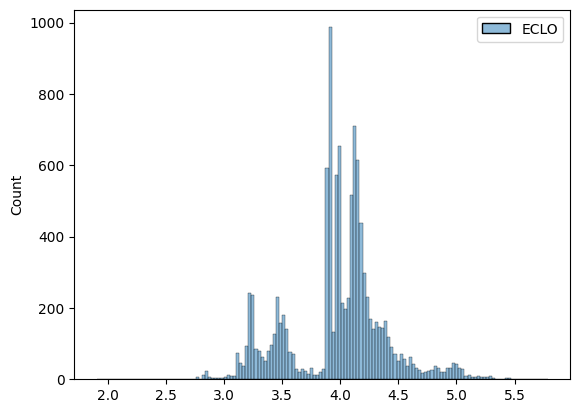

In [ ]:
sns.histplot(submission_df)

# Model_23 [0.42802]

In [ ]:
train = train_df.copy()
test = test_df.copy()

In [ ]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [ ]:
for i in  ['동']:
  _ant =  (train.groupby([i])['ECLO'].mean() < 4).astype(int)
  train = pd.merge(train, _ant, how='left', on=[i])
  test = pd.merge(test, _ant, how='left', on=[i])

  train.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)
  test.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)

In [ ]:
test.rename(columns={'ECLO':'new동'}, inplace=True)

In [ ]:
for i in ['노면상태','사고유형','도로형태2','요일']:

  _ant = train.groupby(['시간',i])['ECLO'].mean()
  train = pd.merge(train, _ant, how='left', on=['시간',i])
  train.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)

  test = pd.merge(test, _ant, how='left', on=['시간',i])


In [ ]:
test.columns

Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시',
       '구', '동', '도로형태1', '도로형태2', '설치형태_건축물', '설치형태_전용주', '설치형태_한전주', '설치개수',
       '설치개수평균', '시설종류_어린이집', '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교', '시설종류_학원',
       '관할경찰서명_강북경찰서', '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서', '관할경찰서명_대구광역시 중부경찰서',
       '관할경찰서명_대구동부경찰서', '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서', '관할경찰서명_수성경찰서',
       'CCTV설치여부_N', 'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수', 'CCTV설치대수평균',
       '급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료', '결제방법_신용카드',
       '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도',
       'new동', 'ECLO_x', 'ECLO_y', 'ECLO_x', 'ECLO_y'],
      dtype='object')

In [ ]:
test.columns = ['ID', '요일','기상상태', '도로형태', '노면상태', '사고유형','연', '월', '일', '시간', '도시', '구','동', '도로형태1',
       '도로형태2', '설치형태_건축물', '설치형태_전용주', '설치형태_한전주', '설치개수', '설치개수평균', '시설종류_어린이집',
       '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교', '시설종류_학원', '관할경찰서명_강북경찰서',
       '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서', '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서',
       '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서', '관할경찰서명_수성경찰서', 'CCTV설치여부_N',
       'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수', 'CCTV설치대수평균', '급지구분_1',
       '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료', '결제방법_신용카드',
       '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도',
       'new동', 'new노면상태', 'new사고유형', 'new도로형태2', 'new요일']

In [ ]:
test_x = test[['노면상태', '사고유형', '도로형태2', '요일', '설치형태_건축물','설치형태_전용주', 'new노면상태', 'new사고유형', 'new도로형태2', 'new요일'
                  ,'설치형태_한전주','시간','설치개수','설치개수평균','주차구획수','new동',
                  '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도', '제한속도']].copy()
train_x = train[['노면상태', '사고유형', '도로형태2', '요일', '설치형태_건축물','설치형태_전용주', 'new노면상태', 'new사고유형', 'new도로형태2', 'new요일'
                  ,'설치형태_한전주','시간','설치개수','설치개수평균','주차구획수','new동',
                  '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도', '제한속도']].copy()
train_y = train['ECLO'].copy()

In [ ]:
for k in ['new노면상태', 'new사고유형', 'new도로형태2', 'new요일']:
  train_x['임시1'] = (train_x[k] < 4).astype(int)
  train_x['임시2'] = (train_x[k] >= 5).astype(int) + 1
  train_x[k] = train_x['임시2'] - train_x['임시1']

  test_x['임시1'] = (test_x[k] < 4).astype(int)
  test_x['임시2'] = (test_x[k] >= 5).astype(int) + 1
  test_x[k] = test_x['임시2'] - test_x['임시1']

In [ ]:
train_x.drop(columns = ['임시1','임시2'])
test_x.drop(columns = ['임시1','임시2'])

In [ ]:
def one_hot(df):

    # one-hot encoding 실시
    df = pd.get_dummies(df)

    return df

In [ ]:
X_train_eng = one_hot(train_x)
X_test_eng = one_hot(test_x)

y_train = np.log(train_y)

In [ ]:
X_train_eng.fillna(0, inplace=True)
X_test_eng.fillna(0, inplace=True)

In [ ]:
print(f'X_train 데이터 shape : {X_train_eng.shape}')
print(f'y_train 데이터 shape : {y_train.shape}')
print()
print(f'X_test 데이터 shape : {X_test_eng.shape}')

X_train 데이터 shape : (39609, 45)
y_train 데이터 shape : (39609,)

X_test 데이터 shape : (10963, 45)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_eng, y_train , test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
import numpy as np

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

from sklearn.metrics import make_scorer

# RMSLE를 평가 지표로 변환
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

## LGBMRegressor 모델

In [ ]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# LGBM Regressor 모델 생성
lgbm = LGBMRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [300, 400, 500, 800, 1200]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_lgbm.best_params_)
print("최적의 점수:", grid_search_lgbm.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
lgbm_best = LGBMRegressor(**grid_search_lgbm.best_params_,random_state=42)

# 모델 학습
lgbm_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = lgbm_best.predict(X_train)
y_val_pred = lgbm_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 699
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 41
[LightGBM] [Info] Start training from score 1.383856
최적의 하이퍼파라미터: {'learning_rate': 0.01, 'n_estimators': 500, 'num_leaves': 10}
최적의 점수: 0.035227992593855194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 699
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 41
[LightGBM] [Info] Start training from score 1.383856
0.4420023483833622
0.44457223089036946


## RandomForestRegressor 모델

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

# Random Forest Regressor 모델 생성
rf = RandomForestRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [8, 10, 12]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_rf.best_params_)
print("최적의 점수:", grid_search_rf.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
rf_best = RandomForestRegressor(**grid_search_rf.best_params_,random_state=42)

# 모델 학습
rf_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = rf_best.predict(X_train)
y_val_pred = rf_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'max_depth': 10, 'min_samples_split': 12, 'n_estimators': 300}
최적의 점수: 0.028409585295856094
0.4271495338557326
0.4460936966795944


## XGBRegressor 모델

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# XGB Regressor 모델 생성
xgb = XGBRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_xgb.best_params_)
print("최적의 점수:", grid_search_xgb.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
xgb_best = XGBRegressor(**grid_search_xgb.best_params_,random_state=42)

# 모델 학습
xgb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = xgb_best.predict(X_train)
y_val_pred = xgb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
최적의 점수: 0.03586612960293101
0.4432665066206832
0.4445887625851283


## GradientBoosting

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
model = GradientBoostingRegressor()

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],  # 트리 개수
    'learning_rate': [0.01, 0.1, 0.2],  # 학습률
    'max_depth': [3, 4, 5]  # 트리 최대 깊이
}

# GridSearchCV를 사용하여 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

gb_best = grid_search.best_estimator_

gb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = gb_best.predict(X_train)
y_val_pred = gb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

0.44315610294635294
0.4445982181690811


## Stack

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

In [ ]:
# 개별 모델 생성
rf = rf_best
lgbm = lgbm_best
xgb = xgb_best
gb = gb_best


# 스태킹 앙상블 모델 생성
estimators = [
    ('rf', rf),
    ('lgbm', lgbm),
    ('xgb', xgb),
    ('gb', gb)
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# 모델 학습
stacking_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = stacking_model.predict(X_train)
y_val_pred = stacking_model.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 699
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 41
[LightGBM] [Info] Start training from score 1.383856
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 25349, number of used features: 41
[LightGBM] [Info] Start training from score 1.386939
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

In [ ]:
X_train.head()

,설치형태_건축물,설치형태_전용주,new노면상태,new사고유형,new도로형태2,new요일,설치형태_한전주,시간,설치개수,설치개수평균,주차구획수,new동,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도,임시1,임시2,노면상태_건조,노면상태_기타,노면상태_서리/결빙,노면상태_적설,노면상태_젖음/습기,노면상태_침수,사고유형_차대사람,사고유형_차대차,사고유형_차량단독,도로형태2_고가도로위,도로형태2_교량,도로형태2_교차로부근,도로형태2_교차로안,도로형태2_교차로횡단보도내,도로형태2_기타,도로형태2_미분류,도로형태2_주차장,도로형태2_지하차도(도로)내,도로형태2_터널,요일_금요일,요일_목요일,요일_수요일,요일_월요일,요일_일요일,요일_토요일,요일_화요일
19887,5.0,0.0,1,1,1,1,7.0,18,13.0,1.00,0.0,0,0.0,0.0,0.00,0.00,0.00,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
17901,0.0,0.0,1,1,1,1,0.0,13,0.0,0.00,153.0,0,0.0,0.0,333.33,2019.73,42.73,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
38196,1647.0,20.0,1,1,1,1,3583.0,14,5377.0,1.02,709.0,0,0.0,0.0,204.76,2016.98,20.48,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
30365,0.0,0.0,1,1,1,1,0.0,8,0.0,0.00,0.0,0,0.0,0.0,0.00,2018.69,48.46,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
4562,0.0,0.0,2,2,2,2,0.0,1,0.0,0.00,1035.0,0,0.0,0.0,33.33,2017.25,50.00,0,2,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
X_test_eng.head()

,설치형태_건축물,설치형태_전용주,new노면상태,new사고유형,new도로형태2,new요일,설치형태_한전주,시간,설치개수,설치개수평균,주차구획수,new동,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도,임시1,임시2,노면상태_건조,노면상태_기타,노면상태_서리/결빙,노면상태_적설,노면상태_젖음/습기,노면상태_침수,사고유형_차대사람,사고유형_차대차,사고유형_차량단독,도로형태2_고가도로위,도로형태2_교량,도로형태2_교차로부근,도로형태2_교차로안,도로형태2_교차로횡단보도내,도로형태2_기타,도로형태2_미분류,도로형태2_주차장,도로형태2_지하차도(도로)내,도로형태2_터널,요일_금요일,요일_목요일,요일_수요일,요일_월요일,요일_일요일,요일_토요일,요일_화요일
0,104.0,16.0,2,0,2,2,579.0,1,700.0,1.0,0.0,0,0.0,0.0,0.00,2020.00,52.50,0,2,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0.0,0.0,2,0,1,2,0.0,1,0.0,0.0,183.0,0,0.0,0.0,700.00,2019.14,47.14,0,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,0.0,0.0,2,2,2,1,0.0,4,0.0,0.0,0.0,0,0.0,0.0,0.00,2020.00,40.00,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0.0,0.0,2,2,1,1,0.0,4,0.0,0.0,153.0,0,0.0,0.0,333.33,2019.73,42.73,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,0.0,0.0,1,1,2,1,0.0,6,932.0,1.0,114.0,0,0.0,0.0,150.00,2015.33,17.50,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
if not all(X_train.columns == X_test_eng.columns):
  X_test_eng = X_test_eng[X_train.columns]

In [ ]:
y_pred1 = stacking_model.predict(X_test_eng)
y_pred1

array([1.27657932, 1.22763983, 1.5075957 , ..., 1.4436574 , 1.43218277,
       1.52738572])

In [ ]:
y_pred = np.exp(y_pred1)
y_pred

array([3.58435778, 3.41316438, 4.51586027, ..., 4.23616084, 4.1878303 ,
       4.60611939])

In [ ]:
submission_df['ECLO'] = y_pred
submission_df.head()

,ID,ECLO
0,ACCIDENT_39609,3.584358
1,ACCIDENT_39610,3.413164
2,ACCIDENT_39611,4.515860
3,ACCIDENT_39612,4.121427
4,ACCIDENT_39613,4.294597


<Axes: ylabel='Count'>

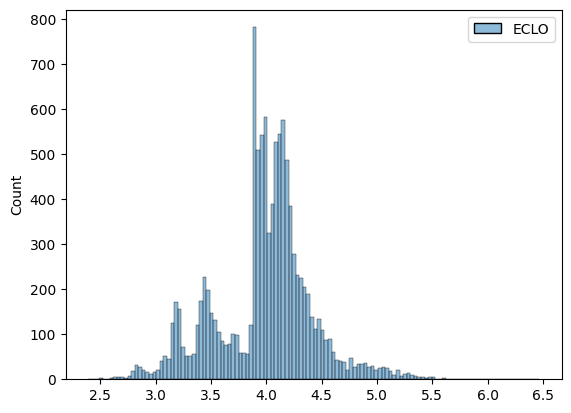

In [ ]:
sns.histplot(submission_df)

In [ ]:
submission_df.to_csv('/content/drive/MyDrive/[Stacking]rmsle값제일적.csv', index=False)

# Model_24 []

In [ ]:
train = train_df.copy()
test = test_df.copy()

In [ ]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [ ]:
for i in  ['동']:
  _ant =  (train.groupby([i])['ECLO'].mean() < 4).astype(int)
  train = pd.merge(train, _ant, how='left', on=[i])
  test = pd.merge(test, _ant, how='left', on=[i])

  train.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)
  test.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)

In [ ]:
test.rename(columns={'ECLO':'new동'}, inplace=True)

In [ ]:
for i in ['노면상태','사고유형','도로형태2','요일']:

  _ant = train.groupby(['시간',i])['ECLO'].mean()
  train = pd.merge(train, _ant, how='left', on=['시간',i])
  train.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)

  test = pd.merge(test, _ant, how='left', on=['시간',i])


In [ ]:
test.columns

Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시',
       '구', '동', '도로형태1', '도로형태2', '설치형태_건축물', '설치형태_전용주', '설치형태_한전주', '설치개수',
       '설치개수평균', '시설종류_어린이집', '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교', '시설종류_학원',
       '관할경찰서명_강북경찰서', '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서', '관할경찰서명_대구광역시 중부경찰서',
       '관할경찰서명_대구동부경찰서', '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서', '관할경찰서명_수성경찰서',
       'CCTV설치여부_N', 'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수', 'CCTV설치대수평균',
       '급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료', '결제방법_신용카드',
       '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도',
       'new동', 'ECLO_x', 'ECLO_y', 'ECLO_x', 'ECLO_y'],
      dtype='object')

In [ ]:
test.columns = ['ID', '요일','기상상태', '도로형태', '노면상태', '사고유형','연', '월', '일', '시간', '도시', '구','동', '도로형태1',
       '도로형태2', '설치형태_건축물', '설치형태_전용주', '설치형태_한전주', '설치개수', '설치개수평균', '시설종류_어린이집',
       '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교', '시설종류_학원', '관할경찰서명_강북경찰서',
       '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서', '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서',
       '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서', '관할경찰서명_수성경찰서', 'CCTV설치여부_N',
       'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수', 'CCTV설치대수평균', '급지구분_1',
       '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료', '결제방법_신용카드',
       '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도',
       'new동', 'new노면상태', 'new사고유형', 'new도로형태2', 'new요일']

In [ ]:
test_x = test[['노면상태', '사고유형', '도로형태2', '요일', '설치형태_건축물','설치형태_전용주', 'new노면상태', 'new사고유형', 'new도로형태2', 'new요일'
                  ,'설치형태_한전주','시간','설치개수','설치개수평균','주차구획수','new동',
                  '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도', '제한속도']].copy()
train_x = train[['노면상태', '사고유형', '도로형태2', '요일', '설치형태_건축물','설치형태_전용주', 'new노면상태', 'new사고유형', 'new도로형태2', 'new요일'
                  ,'설치형태_한전주','시간','설치개수','설치개수평균','주차구획수','new동',
                  '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도', '제한속도']].copy()
train_y = train['ECLO'].copy()

In [ ]:
for k in ['new노면상태', 'new사고유형', 'new도로형태2', 'new요일']:
  train_x['임시1'] = (train_x[k] < 4).astype(int)
  train_x['임시2'] = (train_x[k] >= 5).astype(int) + 1
  train_x[k] = train_x['임시2'] - train_x['임시1']

  test_x['임시1'] = (test_x[k] < 4).astype(int)
  test_x['임시2'] = (test_x[k] >= 5).astype(int) + 1
  test_x[k] = test_x['임시2'] - test_x['임시1']

In [ ]:
train_x.drop(columns = ['임시1','임시2'])
test_x.drop(columns = ['임시1','임시2'])

,노면상태,사고유형,도로형태2,요일,설치형태_건축물,설치형태_전용주,new노면상태,new사고유형,new도로형태2,new요일,설치형태_한전주,시간,설치개수,설치개수평균,주차구획수,new동,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도
0,건조,차대사람,교차로안,토요일,104.0,16.0,2,0,2,2,579.0,1,700.0,1.00,0.0,0,0.0,0.0,0.00,2020.00,52.50
1,건조,차대사람,기타,토요일,0.0,0.0,2,0,1,2,0.0,1,0.0,0.00,183.0,0,0.0,0.0,700.00,2019.14,47.14
2,건조,차대차,교차로안,토요일,0.0,0.0,2,2,2,1,0.0,4,0.0,0.00,0.0,0,0.0,0.0,0.00,2020.00,40.00
3,건조,차대차,기타,토요일,0.0,0.0,2,2,1,1,0.0,4,0.0,0.00,153.0,0,0.0,0.0,333.33,2019.73,42.73
4,건조,차대차,교차로안,토요일,0.0,0.0,1,1,2,1,0.0,6,932.0,1.00,114.0,0,0.0,0.0,150.00,2015.33,17.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,건조,차대차,터널,토요일,1647.0,20.0,1,1,0,1,3583.0,18,5377.0,1.02,709.0,0,0.0,0.0,204.76,2016.98,20.48
10959,건조,차대차,기타,토요일,0.0,0.0,1,1,1,1,0.0,18,0.0,0.00,0.0,0,0.0,0.0,0.00,2020.00,52.50
10960,건조,차대차,기타,토요일,0.0,0.0,1,1,1,1,0.0,20,0.0,0.00,0.0,0,0.0,0.0,0.00,0.00,0.00
10961,건조,차대차,교차로부근,토요일,0.0,0.0,1,1,1,1,0.0,20,0.0,0.00,0.0,0,0.0,0.0,0.00,2018.71,44.29


In [ ]:
def one_hot(df):

    # one-hot encoding 실시
    df = pd.get_dummies(df)

    return df

In [ ]:
X_train_eng = one_hot(train_x)
X_test_eng = one_hot(test_x)

y_train = np.log(train_y)

In [ ]:
X_train_eng.fillna(0, inplace=True)
X_test_eng.fillna(0, inplace=True)

In [ ]:
print(f'X_train 데이터 shape : {X_train_eng.shape}')
print(f'y_train 데이터 shape : {y_train.shape}')
print()
print(f'X_test 데이터 shape : {X_test_eng.shape}')

X_train 데이터 shape : (39609, 45)
y_train 데이터 shape : (39609,)

X_test 데이터 shape : (10963, 45)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_eng, y_train , test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
import numpy as np

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

from sklearn.metrics import make_scorer

# RMSLE를 평가 지표로 변환
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

## LGBMRegressor 모델

In [ ]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# LGBM Regressor 모델 생성
lgbm = LGBMRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [300, 400, 500, 800, 1200]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_lgbm.best_params_)
print("최적의 점수:", grid_search_lgbm.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
lgbm_best = LGBMRegressor(**grid_search_lgbm.best_params_,random_state=42)

# 모델 학습
lgbm_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = lgbm_best.predict(X_train)
y_val_pred = lgbm_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 699
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 41
[LightGBM] [Info] Start training from score 1.383856
최적의 하이퍼파라미터: {'learning_rate': 0.01, 'n_estimators': 500, 'num_leaves': 10}
최적의 점수: 0.035227992593855194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 699
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 41
[LightGBM] [Info] Start training from score 1.383856
0.4420023483833622
0.44457223089036946


## RandomForestRegressor 모델

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

# Random Forest Regressor 모델 생성
rf = RandomForestRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [8, 10, 12]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_rf.best_params_)
print("최적의 점수:", grid_search_rf.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
rf_best = RandomForestRegressor(**grid_search_rf.best_params_,random_state=42)

# 모델 학습
rf_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = rf_best.predict(X_train)
y_val_pred = rf_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'max_depth': 10, 'min_samples_split': 12, 'n_estimators': 300}
최적의 점수: 0.028409585295856094
0.4271495338557326
0.4460936966795944


## XGBRegressor 모델

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# XGB Regressor 모델 생성
xgb = XGBRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_xgb.best_params_)
print("최적의 점수:", grid_search_xgb.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
xgb_best = XGBRegressor(**grid_search_xgb.best_params_,random_state=42)

# 모델 학습
xgb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = xgb_best.predict(X_train)
y_val_pred = xgb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
최적의 점수: 0.03586612960293101
0.4432665066206832
0.4445887625851283


## GradientBoosting

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
model = GradientBoostingRegressor()

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],  # 트리 개수
    'learning_rate': [0.01, 0.1, 0.2],  # 학습률
    'max_depth': [3, 4, 5]  # 트리 최대 깊이
}

# GridSearchCV를 사용하여 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

gb_best = grid_search.best_estimator_

gb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = gb_best.predict(X_train)
y_val_pred = gb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

0.44315610294635294
0.4446098329263276


## Stack

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

In [ ]:
# 개별 모델 생성
rf = rf_best
lgbm = lgbm_best
xgb = xgb_best
gb = gb_best


# 스태킹 앙상블 모델 생성
estimators = [
    ('rf', rf),
    ('lgbm', lgbm),
    ('xgb', xgb),
    ('gb', gb)
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# 모델 학습
stacking_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = stacking_model.predict(X_train)
y_val_pred = stacking_model.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 699
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 41
[LightGBM] [Info] Start training from score 1.383856
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 25349, number of used features: 41
[LightGBM] [Info] Start training from score 1.386939
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

In [ ]:
X_train.head()

,설치형태_건축물,설치형태_전용주,new노면상태,new사고유형,new도로형태2,new요일,설치형태_한전주,시간,설치개수,설치개수평균,주차구획수,new동,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도,임시1,임시2,노면상태_건조,노면상태_기타,노면상태_서리/결빙,노면상태_적설,노면상태_젖음/습기,노면상태_침수,사고유형_차대사람,사고유형_차대차,사고유형_차량단독,도로형태2_고가도로위,도로형태2_교량,도로형태2_교차로부근,도로형태2_교차로안,도로형태2_교차로횡단보도내,도로형태2_기타,도로형태2_미분류,도로형태2_주차장,도로형태2_지하차도(도로)내,도로형태2_터널,요일_금요일,요일_목요일,요일_수요일,요일_월요일,요일_일요일,요일_토요일,요일_화요일
19887,5.0,0.0,1,1,1,1,7.0,18,13.0,1.00,0.0,0,0.0,0.0,0.00,0.00,0.00,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
17901,0.0,0.0,1,1,1,1,0.0,13,0.0,0.00,153.0,0,0.0,0.0,333.33,2019.73,42.73,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
38196,1647.0,20.0,1,1,1,1,3583.0,14,5377.0,1.02,709.0,0,0.0,0.0,204.76,2016.98,20.48,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
30365,0.0,0.0,1,1,1,1,0.0,8,0.0,0.00,0.0,0,0.0,0.0,0.00,2018.69,48.46,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
4562,0.0,0.0,2,2,2,2,0.0,1,0.0,0.00,1035.0,0,0.0,0.0,33.33,2017.25,50.00,0,2,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
X_test_eng.head()

,설치형태_건축물,설치형태_전용주,new노면상태,new사고유형,new도로형태2,new요일,설치형태_한전주,시간,설치개수,설치개수평균,주차구획수,new동,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도,임시1,임시2,노면상태_건조,노면상태_기타,노면상태_서리/결빙,노면상태_적설,노면상태_젖음/습기,노면상태_침수,사고유형_차대사람,사고유형_차대차,사고유형_차량단독,도로형태2_고가도로위,도로형태2_교량,도로형태2_교차로부근,도로형태2_교차로안,도로형태2_교차로횡단보도내,도로형태2_기타,도로형태2_미분류,도로형태2_주차장,도로형태2_지하차도(도로)내,도로형태2_터널,요일_금요일,요일_목요일,요일_수요일,요일_월요일,요일_일요일,요일_토요일,요일_화요일
0,104.0,16.0,2,0,2,2,579.0,1,700.0,1.0,0.0,0,0.0,0.0,0.00,2020.00,52.50,0,2,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0.0,0.0,2,0,1,2,0.0,1,0.0,0.0,183.0,0,0.0,0.0,700.00,2019.14,47.14,0,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,0.0,0.0,2,2,2,1,0.0,4,0.0,0.0,0.0,0,0.0,0.0,0.00,2020.00,40.00,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0.0,0.0,2,2,1,1,0.0,4,0.0,0.0,153.0,0,0.0,0.0,333.33,2019.73,42.73,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,0.0,0.0,1,1,2,1,0.0,6,932.0,1.0,114.0,0,0.0,0.0,150.00,2015.33,17.50,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
if not all(X_train.columns == X_test_eng.columns):
  X_test_eng = X_test_eng[X_train.columns]

In [ ]:
y_pred1 = stacking_model.predict(X_test_eng)
y_pred1

array([1.27660715, 1.22768422, 1.50755784, ..., 1.44364422, 1.43218592,
       1.52745563])

In [ ]:
y_pred = np.exp(y_pred1)
y_pred

array([3.58445754, 3.41331588, 4.51568929, ..., 4.23610503, 4.18784347,
       4.60644139])

In [ ]:
submission_df['ECLO'] = y_pred
submission_df.head()

,ID,ECLO
0,ACCIDENT_39609,3.584458
1,ACCIDENT_39610,3.413316
2,ACCIDENT_39611,4.515689
3,ACCIDENT_39612,4.121306
4,ACCIDENT_39613,4.294441


<Axes: ylabel='Count'>

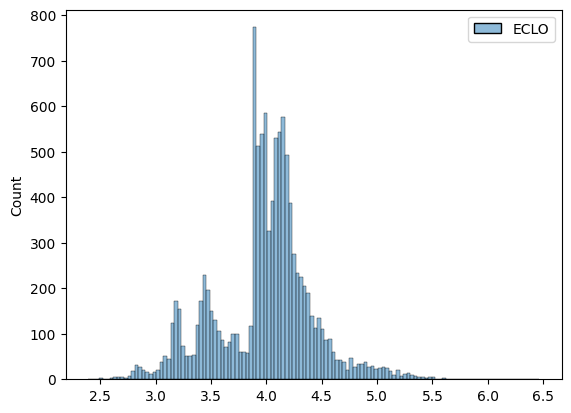

In [ ]:
sns.histplot(submission_df)

# Model_25 [0.44190]

In [ ]:
train = train_df.copy()
test = test_df.copy()

In [ ]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [ ]:
for i in ['노면상태','사고유형','도로형태2','요일','동']:

  _ant = train.groupby(['시간',i])['ECLO'].mean()
  train = pd.merge(train, _ant, how='left', on=['시간',i])
  train.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)

  test = pd.merge(test, _ant, how='left', on=['시간',i])


In [ ]:
test.columns

Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시',
       '구', '동', '도로형태1', '도로형태2', '설치형태_건축물', '설치형태_전용주', '설치형태_한전주', '설치개수',
       '설치개수평균', '시설종류_어린이집', '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교', '시설종류_학원',
       '관할경찰서명_강북경찰서', '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서', '관할경찰서명_대구광역시 중부경찰서',
       '관할경찰서명_대구동부경찰서', '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서', '관할경찰서명_수성경찰서',
       'CCTV설치여부_N', 'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수', 'CCTV설치대수평균',
       '급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료', '결제방법_신용카드',
       '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도',
       'ECLO_x', 'ECLO_y', 'ECLO_x', 'ECLO_y', 'ECLO'],
      dtype='object')

In [ ]:
train.columns

Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간',
       '도시', '구', '동', '도로형태1', '도로형태2', '설치형태_건축물', '설치형태_전용주', '설치형태_한전주',
       '설치개수', '설치개수평균', '시설종류_어린이집', '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교',
       '시설종류_학원', '관할경찰서명_강북경찰서', '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서',
       '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서', '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서',
       '관할경찰서명_수성경찰서', 'CCTV설치여부_N', 'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수',
       'CCTV설치대수평균', '급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료',
       '결제방법_신용카드', '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도',
       'time_range', 'new노면상태', 'new사고유형', 'new도로형태2', 'new요일', 'new동'],
      dtype='object')

In [ ]:
test.columns = ['ID', '요일','기상상태', '도로형태', '노면상태', '사고유형','연', '월', '일', '시간', '도시', '구','동', '도로형태1',
       '도로형태2', '설치형태_건축물', '설치형태_전용주', '설치형태_한전주', '설치개수', '설치개수평균', '시설종류_어린이집',
       '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교', '시설종류_학원', '관할경찰서명_강북경찰서',
       '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서', '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서',
       '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서', '관할경찰서명_수성경찰서', 'CCTV설치여부_N',
       'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수', 'CCTV설치대수평균', '급지구분_1',
       '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료', '결제방법_신용카드',
       '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도',
        'new노면상태', 'new사고유형', 'new도로형태2', 'new요일','new동']

In [ ]:
test_x = test[['노면상태', '사고유형', '도로형태2', '요일', '설치형태_건축물','설치형태_전용주', 'new노면상태', 'new사고유형', 'new도로형태2'
                  ,'설치형태_한전주','시간','설치개수','설치개수평균','주차구획수','new동',
                  '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도', '제한속도']].copy()
train_x = train[['노면상태', '사고유형', '도로형태2', '요일', '설치형태_건축물','설치형태_전용주', 'new노면상태', 'new사고유형', 'new도로형태2'
                  ,'설치형태_한전주','시간','설치개수','설치개수평균','주차구획수','new동',
                  '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도', '제한속도']].copy()
train_y = train['ECLO'].copy()

In [ ]:
# 노면 4.4 / 사고유형 4.3 / 도로형태 4 / 동 4.1

In [ ]:
train_x['임시1'] = (train_x['new노면상태'] < 4.4).astype(int)
train_x['임시2'] = (train_x['new노면상태'] >= 5).astype(int) + 1
train_x['new노면상태'] = train_x['임시2'] - train_x['임시1']

test_x['임시1'] = (test_x['new노면상태'] < 4.4).astype(int)
test_x['임시2'] = (test_x['new노면상태'] >= 5).astype(int) + 1
test_x['new노면상태'] = test_x['임시2'] - test_x['임시1']

In [ ]:
train_x['임시1'] = (train_x['new사고유형'] < 4.3).astype(int)
train_x['임시2'] = (train_x['new사고유형'] >= 5).astype(int) + 1
train_x['new사고유형'] = train_x['임시2'] - train_x['임시1']

test_x['임시1'] = (test_x['new사고유형'] < 4.3).astype(int)
test_x['임시2'] = (test_x['new사고유형'] >= 5).astype(int) + 1
test_x['new사고유형'] = test_x['임시2'] - test_x['임시1']

In [ ]:
train_x['임시1'] = (train_x['new도로형태2'] < 4).astype(int)
train_x['임시2'] = (train_x['new도로형태2'] >= 5).astype(int) + 1
train_x['new도로형태2'] = train_x['임시2'] - train_x['임시1']

test_x['임시1'] = (test_x['new도로형태2'] < 4).astype(int)
test_x['임시2'] = (test_x['new도로형태2'] >= 5).astype(int) + 1
test_x['new도로형태2'] = test_x['임시2'] - test_x['임시1']

In [ ]:
train_x['임시1'] = (train_x['new동'] < 4.1).astype(int)
train_x['임시2'] = (train_x['new동'] >= 5).astype(int) + 1
train_x['new동'] = train_x['임시2'] - train_x['임시1']

test_x['임시1'] = (test_x['new동'] < 4.1).astype(int)
test_x['임시2'] = (test_x['new동'] >= 5).astype(int) + 1
test_x['new동'] = test_x['임시2'] - test_x['임시1']

train_x.drop(columns = ['임시1','임시2'], inplace=True)
test_x.drop(columns = ['임시1','임시2'], inplace=True)

## 시간 별 칼럼별 ECLO 평균

In [ ]:
def time_range(time):
  if time >= 0 and time <= 7 :
    return 1
  elif time <= 12 :
    return 2
  elif time <= 18 :
    return 3
  else :
    return 4

train_x['time_range'] = train_x['시간'].apply(time_range)
test_x['time_range'] = test_x['시간'].apply(time_range)

In [ ]:
def time_carBycar(data):
  if data['사고유형'] == '차대차':
    if data['time_range'] == 1:
      return 1
    elif data['time_range'] == 4:
      return 1
    else:
      return 2
  elif data['사고유형'] == '차대사람' and data['time_range'] == 3:
    return 0
  else:
    return 2


train_x['time_carBycar_data'] = train_x.apply(time_carBycar, axis = 1)
test_x['time_carBycar_data'] = test_x.apply(time_carBycar, axis = 1)
train_x.head()

## ECLOO 평균이 5 이상인 차대차 이면서 새벽과 늦은저녁인 행은 1
## ECLO가 가장 낮은 오후이면서 차대 사람이면 행은 2
## 나머지는 3으로

,노면상태,사고유형,도로형태2,요일,설치형태_건축물,설치형태_전용주,new노면상태,new사고유형,new도로형태2,설치형태_한전주,시간,설치개수,설치개수평균,주차구획수,new동,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도,time_range,time_carBycar_data
0,건조,차대사람,기타,화요일,177.0,30.0,2,0,1,135.0,0,391.0,1.00,500.0,0,0.0,0.0,1136.36,2013.00,8.0,1,2
1,건조,차대사람,기타,화요일,0.0,0.0,2,0,1,0.0,0,932.0,1.00,114.0,2,0.0,0.0,150.00,2015.33,17.5,1,2
2,건조,차대사람,기타,화요일,14.0,31.0,2,0,1,425.0,1,473.0,1.00,0.0,1,0.0,0.0,0.00,2018.25,55.0,1,2
3,건조,차대차,기타,화요일,0.0,0.0,2,2,1,0.0,2,534.0,1.00,374.0,0,0.0,2.0,71.43,2018.30,38.0,1,1
4,건조,차대차,기타,화요일,540.0,57.0,2,2,1,1396.0,4,2057.0,1.03,63.0,1,0.0,0.0,600.00,2018.25,40.0,1,1


In [ ]:
def time_road(data):
  if data['도로형태2'] == '터널':
    return 1
  elif data['도로형태2'] == '고가도로위':
    if data['time_range'] == 1 or data['time_range'] == 4:
      return 1
    else:
      return 0
  elif data['도로형태2'] == '주차장':
    return 2
  elif data['도로형태2'] == '미분류':
    return 2
  else :
    return 0

train_x['time_road_data'] = train_x.apply(time_road, axis = 1)
test_x['time_road_data'] = test_x.apply(time_road, axis = 1)
train_x.head()

,노면상태,사고유형,도로형태2,요일,설치형태_건축물,설치형태_전용주,new노면상태,new사고유형,new도로형태2,설치형태_한전주,시간,설치개수,설치개수평균,주차구획수,new동,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도,time_range,time_carBycar_data,time_road_data
0,건조,차대사람,기타,화요일,177.0,30.0,2,0,1,135.0,0,391.0,1.00,500.0,0,0.0,0.0,1136.36,2013.00,8.0,1,2,0
1,건조,차대사람,기타,화요일,0.0,0.0,2,0,1,0.0,0,932.0,1.00,114.0,2,0.0,0.0,150.00,2015.33,17.5,1,2,0
2,건조,차대사람,기타,화요일,14.0,31.0,2,0,1,425.0,1,473.0,1.00,0.0,1,0.0,0.0,0.00,2018.25,55.0,1,2,0
3,건조,차대차,기타,화요일,0.0,0.0,2,2,1,0.0,2,534.0,1.00,374.0,0,0.0,2.0,71.43,2018.30,38.0,1,1,0
4,건조,차대차,기타,화요일,540.0,57.0,2,2,1,1396.0,4,2057.0,1.03,63.0,1,0.0,0.0,600.00,2018.25,40.0,1,1,0


## 요일별 칼럼별 ECLO 평균

- 요일별 시간

In [ ]:
def sun_time_acci(data):
  if data['요일'] == '일요일':
    if data['time_range'] == 2 or data['time_range'] == 3:
      return 1
    else:
      return 0
  else:
    return 0

train_x['sun_timed_data'] = train_x.apply(sun_time_acci, axis = 1)
test_x['sun_timed_data'] = test_x.apply(sun_time_acci, axis = 1)
train_x.head()

,노면상태,사고유형,도로형태2,요일,설치형태_건축물,설치형태_전용주,new노면상태,new사고유형,new도로형태2,설치형태_한전주,시간,설치개수,설치개수평균,주차구획수,new동,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도,time_range,time_carBycar_data,time_road_data,sun_timed_data
0,건조,차대사람,기타,화요일,177.0,30.0,2,0,1,135.0,0,391.0,1.00,500.0,0,0.0,0.0,1136.36,2013.00,8.0,1,2,0,0
1,건조,차대사람,기타,화요일,0.0,0.0,2,0,1,0.0,0,932.0,1.00,114.0,2,0.0,0.0,150.00,2015.33,17.5,1,2,0,0
2,건조,차대사람,기타,화요일,14.0,31.0,2,0,1,425.0,1,473.0,1.00,0.0,1,0.0,0.0,0.00,2018.25,55.0,1,2,0,0
3,건조,차대차,기타,화요일,0.0,0.0,2,2,1,0.0,2,534.0,1.00,374.0,0,0.0,2.0,71.43,2018.30,38.0,1,1,0,0
4,건조,차대차,기타,화요일,540.0,57.0,2,2,1,1396.0,4,2057.0,1.03,63.0,1,0.0,0.0,600.00,2018.25,40.0,1,1,0,0


- 요일별 사고유형

In [ ]:
def day_carBy(data):
  if data['사고유형'] == '차대차':
    if data['요일'] == '일요일':
      return 1
    elif data['요일'] == '토요일':
      return 1
    else :
      return 0
  elif data['사고유형'] == '차량단독':
    if data['요일'] == '수요일':
      return 2
    else:
      return 0
  elif data['사고유형'] == '차대사람' and data['요일'] == '목요일':
    return 2
  else:
    return 0

train_x['day_carBy_data'] = train_x.apply(day_carBy, axis = 1)
test_x['day_carBy_data'] = test_x.apply(day_carBy, axis = 1)
train_x.head()

,노면상태,사고유형,도로형태2,요일,설치형태_건축물,설치형태_전용주,new노면상태,new사고유형,new도로형태2,설치형태_한전주,시간,설치개수,설치개수평균,주차구획수,new동,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도,time_range,time_carBycar_data,time_road_data,sun_timed_data,day_carBy_data
0,건조,차대사람,기타,화요일,177.0,30.0,2,0,1,135.0,0,391.0,1.00,500.0,0,0.0,0.0,1136.36,2013.00,8.0,1,2,0,0,0
1,건조,차대사람,기타,화요일,0.0,0.0,2,0,1,0.0,0,932.0,1.00,114.0,2,0.0,0.0,150.00,2015.33,17.5,1,2,0,0,0
2,건조,차대사람,기타,화요일,14.0,31.0,2,0,1,425.0,1,473.0,1.00,0.0,1,0.0,0.0,0.00,2018.25,55.0,1,2,0,0,0
3,건조,차대차,기타,화요일,0.0,0.0,2,2,1,0.0,2,534.0,1.00,374.0,0,0.0,2.0,71.43,2018.30,38.0,1,1,0,0,0
4,건조,차대차,기타,화요일,540.0,57.0,2,2,1,1396.0,4,2057.0,1.03,63.0,1,0.0,0.0,600.00,2018.25,40.0,1,1,0,0,0


In [ ]:
def one_hot(df):

    # one-hot encoding 실시
    df = pd.get_dummies(df)

    return df

In [ ]:
X_train_eng = one_hot(train_x)
X_test_eng = one_hot(test_x)

y_train = np.log(train_y)

In [ ]:
X_train_eng.fillna(0, inplace=True)
X_test_eng.fillna(0, inplace=True)

In [ ]:
print(f'X_train 데이터 shape : {X_train_eng.shape}')
print(f'y_train 데이터 shape : {y_train.shape}')
print()
print(f'X_test 데이터 shape : {X_test_eng.shape}')

X_train 데이터 shape : (39609, 47)
y_train 데이터 shape : (39609,)

X_test 데이터 shape : (10963, 47)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_eng, y_train , test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
import numpy as np

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

from sklearn.metrics import make_scorer

# RMSLE를 평가 지표로 변환
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

## LGBMRegressor 모델

In [ ]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# LGBM Regressor 모델 생성
lgbm = LGBMRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [300, 400, 500, 800, 1200]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_lgbm.best_params_)
print("최적의 점수:", grid_search_lgbm.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
lgbm_best = LGBMRegressor(**grid_search_lgbm.best_params_,random_state=42)

# 모델 학습
lgbm_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = lgbm_best.predict(X_train)
y_val_pred = lgbm_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 708
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 43
[LightGBM] [Info] Start training from score 1.383856
최적의 하이퍼파라미터: {'learning_rate': 0.01, 'n_estimators': 400, 'num_leaves': 10}
최적의 점수: 0.08751683866031079
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 708
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 43
[LightGBM] [Info] Start training from score 1.383856
0.4297181583282263
0.43234155496179855


## RandomForestRegressor 모델

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

# Random Forest Regressor 모델 생성
rf = RandomForestRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [8, 10, 12]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_rf.best_params_)
print("최적의 점수:", grid_search_rf.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
rf_best = RandomForestRegressor(**grid_search_rf.best_params_,random_state=42)

# 모델 학습
rf_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = rf_best.predict(X_train)
y_val_pred = rf_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'max_depth': 10, 'min_samples_split': 12, 'n_estimators': 300}
최적의 점수: 0.07694554061146457
0.41380849445320017
0.43399399218451723


## XGBRegressor 모델

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# XGB Regressor 모델 생성
xgb = XGBRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_xgb.best_params_)
print("최적의 점수:", grid_search_xgb.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
xgb_best = XGBRegressor(**grid_search_xgb.best_params_,random_state=42)

# 모델 학습
xgb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = xgb_best.predict(X_train)
y_val_pred = xgb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}
최적의 점수: 0.08762780528545495
0.42813043979869014
0.43231428977652325


## GradientBoosting

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
model = GradientBoostingRegressor()

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],  # 트리 개수
    'learning_rate': [0.01, 0.1, 0.2],  # 학습률
    'max_depth': [3, 4, 5]  # 트리 최대 깊이
}

# GridSearchCV를 사용하여 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

gb_best = grid_search.best_estimator_

gb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = gb_best.predict(X_train)
y_val_pred = gb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

0.43015292740749883
0.4326950364075469


## Stack

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

In [ ]:
# 개별 모델 생성
rf = rf_best
lgbm = lgbm_best
xgb = xgb_best
gb = gb_best


# 스태킹 앙상블 모델 생성
estimators = [
    ('rf', rf),
    ('lgbm', lgbm),
    ('xgb', xgb),
    ('gb', gb)
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# 모델 학습
stacking_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = stacking_model.predict(X_train)
y_val_pred = stacking_model.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 708
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 43
[LightGBM] [Info] Start training from score 1.383856
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 706
[LightGBM] [Info] Number of data points in the train set: 25349, number of used features: 43
[LightGBM] [Info] Start training from score 1.386939
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

In [ ]:
y_pred1 = stacking_model.predict(X_test_eng)
y_pred1

array([1.39621878, 1.19155346, 1.76583508, ..., 1.16153689, 1.63246595,
       1.74359822])

In [ ]:
y_pred = np.exp(y_pred1)
y_pred

array([4.0398953 , 3.29219152, 5.84645259, ..., 3.19483961, 5.11647617,
       5.71788062])

In [ ]:
submission_df['ECLO'] = y_pred
submission_df.head()

,ID,ECLO
0,ACCIDENT_39609,4.039895
1,ACCIDENT_39610,3.292192
2,ACCIDENT_39611,5.846453
3,ACCIDENT_39612,3.305078
4,ACCIDENT_39613,4.209611


<Axes: ylabel='Count'>

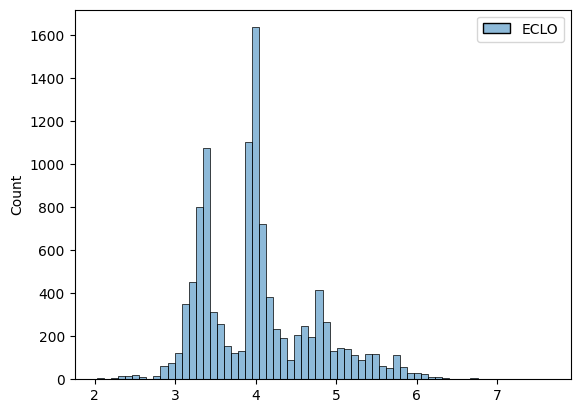

In [ ]:
sns.histplot(submission_df)

In [ ]:
submission_df.to_csv('/content/drive/MyDrive/[Stacking]rmsle역대급.csv', index=False)

# Model_26 []

In [32]:
train = train_df.copy()
test = test_df.copy()

In [33]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [34]:
for i in ['노면상태','사고유형','도로형태2','요일','동']:

  _ant = train.groupby(['시간',i])['ECLO'].mean()
  train = pd.merge(train, _ant, how='left', on=['시간',i])
  train.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)

  test = pd.merge(test, _ant, how='left', on=['시간',i])


In [35]:
test.columns

Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시',
       '구', '동', '도로형태1', '도로형태2', '설치형태_건축물', '설치형태_전용주', '설치형태_한전주', '설치개수',
       '설치개수평균', '시설종류_어린이집', '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교', '시설종류_학원',
       '관할경찰서명_강북경찰서', '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서', '관할경찰서명_대구광역시 중부경찰서',
       '관할경찰서명_대구동부경찰서', '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서', '관할경찰서명_수성경찰서',
       'CCTV설치여부_N', 'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수', 'CCTV설치대수평균',
       '급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료', '결제방법_신용카드',
       '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도',
       'ECLO_x', 'ECLO_y', 'ECLO_x', 'ECLO_y', 'ECLO'],
      dtype='object')

In [36]:
train.columns

Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간',
       '도시', '구', '동', '도로형태1', '도로형태2', '설치형태_건축물', '설치형태_전용주', '설치형태_한전주',
       '설치개수', '설치개수평균', '시설종류_어린이집', '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교',
       '시설종류_학원', '관할경찰서명_강북경찰서', '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서',
       '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서', '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서',
       '관할경찰서명_수성경찰서', 'CCTV설치여부_N', 'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수',
       'CCTV설치대수평균', '급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료',
       '결제방법_신용카드', '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도',
       'new노면상태', 'new사고유형', 'new도로형태2', 'new요일', 'new동'],
      dtype='object')

In [37]:
test.columns = ['ID', '요일','기상상태', '도로형태', '노면상태', '사고유형','연', '월', '일', '시간', '도시', '구','동', '도로형태1',
       '도로형태2', '설치형태_건축물', '설치형태_전용주', '설치형태_한전주', '설치개수', '설치개수평균', '시설종류_어린이집',
       '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교', '시설종류_학원', '관할경찰서명_강북경찰서',
       '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서', '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서',
       '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서', '관할경찰서명_수성경찰서', 'CCTV설치여부_N',
       'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수', 'CCTV설치대수평균', '급지구분_1',
       '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료', '결제방법_신용카드',
       '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도',
        'new노면상태', 'new사고유형', 'new도로형태2', 'new요일','new동']

In [38]:
test_x = test[['노면상태', '사고유형', '도로형태2', '요일', '설치형태_건축물','설치형태_전용주', 'new노면상태', 'new사고유형', 'new도로형태2'
                  ,'설치형태_한전주','시간','설치개수','설치개수평균','주차구획수','new동',
                  '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도', '제한속도']].copy()
train_x = train[['노면상태', '사고유형', '도로형태2', '요일', '설치형태_건축물','설치형태_전용주', 'new노면상태', 'new사고유형', 'new도로형태2'
                  ,'설치형태_한전주','시간','설치개수','설치개수평균','주차구획수','new동',
                  '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도', '제한속도']].copy()
train_y = train['ECLO'].copy()

In [39]:
# 노면 4.4 / 사고유형 4.3 / 도로형태 4 / 동 4.1

In [40]:
train_x['임시1'] = (train_x['new노면상태'] < 4.4).astype(int)
train_x['임시2'] = (train_x['new노면상태'] >= 5).astype(int) + 1
train_x['new노면상태'] = train_x['임시2'] - train_x['임시1']

test_x['임시1'] = (test_x['new노면상태'] < 4.4).astype(int)
test_x['임시2'] = (test_x['new노면상태'] >= 5).astype(int) + 1
test_x['new노면상태'] = test_x['임시2'] - test_x['임시1']

In [41]:
train_x['임시1'] = (train_x['new사고유형'] < 4.3).astype(int)
train_x['임시2'] = (train_x['new사고유형'] >= 5).astype(int) + 1
train_x['new사고유형'] = train_x['임시2'] - train_x['임시1']

test_x['임시1'] = (test_x['new사고유형'] < 4.3).astype(int)
test_x['임시2'] = (test_x['new사고유형'] >= 5).astype(int) + 1
test_x['new사고유형'] = test_x['임시2'] - test_x['임시1']

In [42]:
train_x['임시1'] = (train_x['new도로형태2'] < 4).astype(int)
train_x['임시2'] = (train_x['new도로형태2'] >= 5).astype(int) + 1
train_x['new도로형태2'] = train_x['임시2'] - train_x['임시1']

test_x['임시1'] = (test_x['new도로형태2'] < 4).astype(int)
test_x['임시2'] = (test_x['new도로형태2'] >= 5).astype(int) + 1
test_x['new도로형태2'] = test_x['임시2'] - test_x['임시1']

In [43]:
train_x['임시1'] = (train_x['new동'] < 4.1).astype(int)
train_x['임시2'] = (train_x['new동'] >= 5).astype(int) + 1
train_x['new동'] = train_x['임시2'] - train_x['임시1']

test_x['임시1'] = (test_x['new동'] < 4.1).astype(int)
test_x['임시2'] = (test_x['new동'] >= 5).astype(int) + 1
test_x['new동'] = test_x['임시2'] - test_x['임시1']

train_x.drop(columns = ['임시1','임시2'], inplace=True)
test_x.drop(columns = ['임시1','임시2'], inplace=True)

## 시간 별 칼럼별 ECLO 평균

In [44]:
def time_range(time):
  if time >= 0 and time <= 7 :
    return 1
  elif time <= 12 :
    return 2
  elif time <= 18 :
    return 3
  else :
    return 4

train_x['time_range'] = train_x['시간'].apply(time_range)
test_x['time_range'] = test_x['시간'].apply(time_range)

In [45]:
def time_carBycar(data):
  if data['사고유형'] == '차대차':
    if data['time_range'] == 1:
      return 1
    elif data['time_range'] == 4:
      return 1
    else:
      return 2
  elif data['사고유형'] == '차대사람' and data['time_range'] == 3:
    return 0
  else:
    return 2


train_x['time_carBycar_data'] = train_x.apply(time_carBycar, axis = 1)
test_x['time_carBycar_data'] = test_x.apply(time_carBycar, axis = 1)
train_x.head()

## ECLOO 평균이 5 이상인 차대차 이면서 새벽과 늦은저녁인 행은 1
## ECLO가 가장 낮은 오후이면서 차대 사람이면 행은 2
## 나머지는 3으로

,노면상태,사고유형,도로형태2,요일,설치형태_건축물,설치형태_전용주,new노면상태,new사고유형,new도로형태2,설치형태_한전주,시간,설치개수,설치개수평균,주차구획수,new동,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도,time_range,time_carBycar_data
0,건조,차대사람,기타,화요일,177.0,30.0,2,0,1,135.0,0,391.0,1.00,500.0,0,0.0,0.0,1136.36,2013.00,8.0,1,2
1,건조,차대사람,기타,화요일,0.0,0.0,2,0,1,0.0,0,932.0,1.00,114.0,2,0.0,0.0,150.00,2015.33,17.5,1,2
2,건조,차대사람,기타,화요일,14.0,31.0,2,0,1,425.0,1,473.0,1.00,0.0,1,0.0,0.0,0.00,2018.25,55.0,1,2
3,건조,차대차,기타,화요일,0.0,0.0,2,2,1,0.0,2,534.0,1.00,374.0,0,0.0,2.0,71.43,2018.30,38.0,1,1
4,건조,차대차,기타,화요일,540.0,57.0,2,2,1,1396.0,4,2057.0,1.03,63.0,1,0.0,0.0,600.00,2018.25,40.0,1,1


In [46]:
def time_road(data):
  if data['도로형태2'] == '터널':
    return 1
  elif data['도로형태2'] == '고가도로위':
    if data['time_range'] == 1 or data['time_range'] == 4:
      return 1
    else:
      return 0
  elif data['도로형태2'] == '주차장':
    return 2
  elif data['도로형태2'] == '미분류':
    return 2
  else :
    return 0

train_x['time_road_data'] = train_x.apply(time_road, axis = 1)
test_x['time_road_data'] = test_x.apply(time_road, axis = 1)
train_x.head()

,노면상태,사고유형,도로형태2,요일,설치형태_건축물,설치형태_전용주,new노면상태,new사고유형,new도로형태2,설치형태_한전주,시간,설치개수,설치개수평균,주차구획수,new동,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도,time_range,time_carBycar_data,time_road_data
0,건조,차대사람,기타,화요일,177.0,30.0,2,0,1,135.0,0,391.0,1.00,500.0,0,0.0,0.0,1136.36,2013.00,8.0,1,2,0
1,건조,차대사람,기타,화요일,0.0,0.0,2,0,1,0.0,0,932.0,1.00,114.0,2,0.0,0.0,150.00,2015.33,17.5,1,2,0
2,건조,차대사람,기타,화요일,14.0,31.0,2,0,1,425.0,1,473.0,1.00,0.0,1,0.0,0.0,0.00,2018.25,55.0,1,2,0
3,건조,차대차,기타,화요일,0.0,0.0,2,2,1,0.0,2,534.0,1.00,374.0,0,0.0,2.0,71.43,2018.30,38.0,1,1,0
4,건조,차대차,기타,화요일,540.0,57.0,2,2,1,1396.0,4,2057.0,1.03,63.0,1,0.0,0.0,600.00,2018.25,40.0,1,1,0


## 요일별 칼럼별 ECLO 평균

- 요일별 시간

In [47]:
def sun_time_acci(data):
  if data['요일'] == '일요일':
    if data['time_range'] == 2 or data['time_range'] == 3:
      return 1
    else:
      return 0
  else:
    return 0

train_x['sun_timed_data'] = train_x.apply(sun_time_acci, axis = 1)
test_x['sun_timed_data'] = test_x.apply(sun_time_acci, axis = 1)
train_x.head()

,노면상태,사고유형,도로형태2,요일,설치형태_건축물,설치형태_전용주,new노면상태,new사고유형,new도로형태2,설치형태_한전주,시간,설치개수,설치개수평균,주차구획수,new동,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도,time_range,time_carBycar_data,time_road_data,sun_timed_data
0,건조,차대사람,기타,화요일,177.0,30.0,2,0,1,135.0,0,391.0,1.00,500.0,0,0.0,0.0,1136.36,2013.00,8.0,1,2,0,0
1,건조,차대사람,기타,화요일,0.0,0.0,2,0,1,0.0,0,932.0,1.00,114.0,2,0.0,0.0,150.00,2015.33,17.5,1,2,0,0
2,건조,차대사람,기타,화요일,14.0,31.0,2,0,1,425.0,1,473.0,1.00,0.0,1,0.0,0.0,0.00,2018.25,55.0,1,2,0,0
3,건조,차대차,기타,화요일,0.0,0.0,2,2,1,0.0,2,534.0,1.00,374.0,0,0.0,2.0,71.43,2018.30,38.0,1,1,0,0
4,건조,차대차,기타,화요일,540.0,57.0,2,2,1,1396.0,4,2057.0,1.03,63.0,1,0.0,0.0,600.00,2018.25,40.0,1,1,0,0


- 요일별 사고유형

In [48]:
def day_carBy(data):
  if data['사고유형'] == '차대차':
    if data['요일'] == '일요일':
      return 1
    elif data['요일'] == '토요일':
      return 1
    else :
      return 0
  elif data['사고유형'] == '차량단독':
    if data['요일'] == '수요일':
      return 2
    else:
      return 0
  elif data['사고유형'] == '차대사람' and data['요일'] == '목요일':
    return 2
  else:
    return 0

train_x['day_carBy_data'] = train_x.apply(day_carBy, axis = 1)
test_x['day_carBy_data'] = test_x.apply(day_carBy, axis = 1)
train_x.head()

,노면상태,사고유형,도로형태2,요일,설치형태_건축물,설치형태_전용주,new노면상태,new사고유형,new도로형태2,설치형태_한전주,시간,설치개수,설치개수평균,주차구획수,new동,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도,time_range,time_carBycar_data,time_road_data,sun_timed_data,day_carBy_data
0,건조,차대사람,기타,화요일,177.0,30.0,2,0,1,135.0,0,391.0,1.00,500.0,0,0.0,0.0,1136.36,2013.00,8.0,1,2,0,0,0
1,건조,차대사람,기타,화요일,0.0,0.0,2,0,1,0.0,0,932.0,1.00,114.0,2,0.0,0.0,150.00,2015.33,17.5,1,2,0,0,0
2,건조,차대사람,기타,화요일,14.0,31.0,2,0,1,425.0,1,473.0,1.00,0.0,1,0.0,0.0,0.00,2018.25,55.0,1,2,0,0,0
3,건조,차대차,기타,화요일,0.0,0.0,2,2,1,0.0,2,534.0,1.00,374.0,0,0.0,2.0,71.43,2018.30,38.0,1,1,0,0,0
4,건조,차대차,기타,화요일,540.0,57.0,2,2,1,1396.0,4,2057.0,1.03,63.0,1,0.0,0.0,600.00,2018.25,40.0,1,1,0,0,0


In [49]:
train_x.drop(columns = ['시간'], inplace=True)
test_x.drop(columns = ['시간'], inplace=True)

In [50]:
def one_hot(df):

    # one-hot encoding 실시
    df = pd.get_dummies(df)

    return df

In [51]:
X_train_eng = one_hot(train_x)
X_test_eng = one_hot(test_x)

y_train = np.log(train_y)

In [52]:
X_train_eng.fillna(0, inplace=True)
X_test_eng.fillna(0, inplace=True)

In [53]:
print(f'X_train 데이터 shape : {X_train_eng.shape}')
print(f'y_train 데이터 shape : {y_train.shape}')
print()
print(f'X_test 데이터 shape : {X_test_eng.shape}')

X_train 데이터 shape : (39609, 46)
y_train 데이터 shape : (39609,)

X_test 데이터 shape : (10963, 46)


In [54]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_eng, y_train , test_size=0.2, random_state=42)

In [55]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [56]:
import numpy as np

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

from sklearn.metrics import make_scorer

# RMSLE를 평가 지표로 변환
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

## LGBMRegressor 모델

In [57]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [58]:
# LGBM Regressor 모델 생성
lgbm = LGBMRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [300, 400, 500, 800, 1200]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_lgbm.best_params_)
print("최적의 점수:", grid_search_lgbm.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
lgbm_best = LGBMRegressor(**grid_search_lgbm.best_params_,random_state=42)

# 모델 학습
lgbm_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = lgbm_best.predict(X_train)
y_val_pred = lgbm_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 684
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 42
[LightGBM] [Info] Start training from score 1.383856
최적의 하이퍼파라미터: {'learning_rate': 0.01, 'n_estimators': 500, 'num_leaves': 10}
최적의 점수: 0.08763949912035078
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 684
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 42
[LightGBM] [Info] Start training from score 1.383856
0.4290958243909554
0.4322417142272637


## RandomForestRegressor 모델

In [59]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [60]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

# Random Forest Regressor 모델 생성
rf = RandomForestRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [8, 10, 12]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_rf.best_params_)
print("최적의 점수:", grid_search_rf.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
rf_best = RandomForestRegressor(**grid_search_rf.best_params_,random_state=42)

# 모델 학습
rf_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = rf_best.predict(X_train)
y_val_pred = rf_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'max_depth': 10, 'min_samples_split': 12, 'n_estimators': 300}
최적의 점수: 0.07712938019260225
0.4145252010031032
0.43366712981375566


## XGBRegressor 모델

In [61]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [62]:
# XGB Regressor 모델 생성
xgb = XGBRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_xgb.best_params_)
print("최적의 점수:", grid_search_xgb.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
xgb_best = XGBRegressor(**grid_search_xgb.best_params_,random_state=42)

# 모델 학습
xgb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = xgb_best.predict(X_train)
y_val_pred = xgb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}
최적의 점수: 0.08810394737060885
0.42824626695569445
0.43227635255097857


## GradientBoosting

In [63]:
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [64]:
model = GradientBoostingRegressor()

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],  # 트리 개수
    'learning_rate': [0.01, 0.1, 0.2],  # 학습률
    'max_depth': [3, 4, 5]  # 트리 최대 깊이
}

# GridSearchCV를 사용하여 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

gb_best = grid_search.best_estimator_

gb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = gb_best.predict(X_train)
y_val_pred = gb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

0.4301312688596321
0.432587825818001


## Stack

In [65]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

In [66]:
# 개별 모델 생성
rf = rf_best
lgbm = lgbm_best
xgb = xgb_best
gb = gb_best


# 스태킹 앙상블 모델 생성
estimators = [
    ('rf', rf),
    ('lgbm', lgbm),
    ('xgb', xgb),
    ('gb', gb)
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# 모델 학습
stacking_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = stacking_model.predict(X_train)
y_val_pred = stacking_model.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 684
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 42
[LightGBM] [Info] Start training from score 1.383856
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 682
[LightGBM] [Info] Number of data points in the train set: 25349, number of used features: 42
[LightGBM] [Info] Start training from score 1.386939
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

In [67]:
y_pred1 = stacking_model.predict(X_test_eng)
y_pred1

array([1.39765251, 1.20524276, 1.76012014, ..., 1.16287063, 1.63239143,
       1.74696046])

In [68]:
y_pred = np.exp(y_pred1)
y_pred

array([4.0456916 , 3.33756922, 5.81313575, ..., 3.19910355, 5.11609488,
       5.7371379 ])

In [69]:
submission_df['ECLO'] = y_pred
submission_df.head()

,ID,ECLO
0,ACCIDENT_39609,4.045692
1,ACCIDENT_39610,3.337569
2,ACCIDENT_39611,5.813136
3,ACCIDENT_39612,3.332915
4,ACCIDENT_39613,4.232415


<Axes: ylabel='Count'>

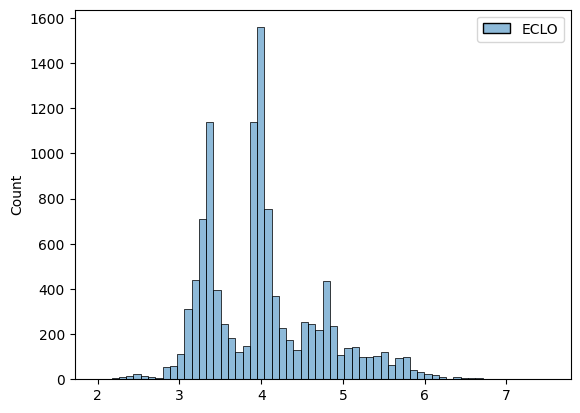

In [70]:
sns.histplot(submission_df)

# Model_27 []

In [32]:
train = train_df.copy()
test = test_df.copy()

In [33]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [34]:
for i in ['노면상태','사고유형','도로형태2','요일','동']:

  _ant = train.groupby(['시간',i])['ECLO'].mean()
  train = pd.merge(train, _ant, how='left', on=['시간',i])
  train.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)

  test = pd.merge(test, _ant, how='left', on=['시간',i])


In [35]:
test.columns

Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시',
       '구', '동', '도로형태1', '도로형태2', '설치형태_건축물', '설치형태_전용주', '설치형태_한전주', '설치개수',
       '설치개수평균', '시설종류_어린이집', '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교', '시설종류_학원',
       '관할경찰서명_강북경찰서', '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서', '관할경찰서명_대구광역시 중부경찰서',
       '관할경찰서명_대구동부경찰서', '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서', '관할경찰서명_수성경찰서',
       'CCTV설치여부_N', 'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수', 'CCTV설치대수평균',
       '급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료', '결제방법_신용카드',
       '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도',
       'ECLO_x', 'ECLO_y', 'ECLO_x', 'ECLO_y', 'ECLO'],
      dtype='object')

In [36]:
train.columns

Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간',
       '도시', '구', '동', '도로형태1', '도로형태2', '설치형태_건축물', '설치형태_전용주', '설치형태_한전주',
       '설치개수', '설치개수평균', '시설종류_어린이집', '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교',
       '시설종류_학원', '관할경찰서명_강북경찰서', '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서',
       '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서', '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서',
       '관할경찰서명_수성경찰서', 'CCTV설치여부_N', 'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수',
       'CCTV설치대수평균', '급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료',
       '결제방법_신용카드', '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도',
       'new노면상태', 'new사고유형', 'new도로형태2', 'new요일', 'new동'],
      dtype='object')

In [37]:
test.columns = ['ID', '요일','기상상태', '도로형태', '노면상태', '사고유형','연', '월', '일', '시간', '도시', '구','동', '도로형태1',
       '도로형태2', '설치형태_건축물', '설치형태_전용주', '설치형태_한전주', '설치개수', '설치개수평균', '시설종류_어린이집',
       '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교', '시설종류_학원', '관할경찰서명_강북경찰서',
       '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서', '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서',
       '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서', '관할경찰서명_수성경찰서', 'CCTV설치여부_N',
       'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수', 'CCTV설치대수평균', '급지구분_1',
       '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료', '결제방법_신용카드',
       '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도',
        'new노면상태', 'new사고유형', 'new도로형태2', 'new요일','new동']

In [38]:
test_x = test[['노면상태', '사고유형', '도로형태2', '요일', '설치형태_건축물','설치형태_전용주', 'new노면상태', 'new사고유형', 'new도로형태2'
                  ,'설치형태_한전주','시간','설치개수','설치개수평균','주차구획수',
                  '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도', '제한속도']].copy()
train_x = train[['노면상태', '사고유형', '도로형태2', '요일', '설치형태_건축물','설치형태_전용주', 'new노면상태', 'new사고유형', 'new도로형태2'
                  ,'설치형태_한전주','시간','설치개수','설치개수평균','주차구획수',
                  '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도', '제한속도']].copy()
train_y = train['ECLO'].copy()

In [39]:
# 노면 4.4 / 사고유형 4.3 / 도로형태 4 / 동 4.1

In [40]:
train_x['임시1'] = (train_x['new노면상태'] < 4.4).astype(int)
train_x['임시2'] = (train_x['new노면상태'] >= 5).astype(int) + 1
train_x['new노면상태'] = train_x['임시2'] - train_x['임시1']

test_x['임시1'] = (test_x['new노면상태'] < 4.4).astype(int)
test_x['임시2'] = (test_x['new노면상태'] >= 5).astype(int) + 1
test_x['new노면상태'] = test_x['임시2'] - test_x['임시1']

In [41]:
train_x['임시1'] = (train_x['new사고유형'] < 4.3).astype(int)
train_x['임시2'] = (train_x['new사고유형'] >= 5).astype(int) + 1
train_x['new사고유형'] = train_x['임시2'] - train_x['임시1']

test_x['임시1'] = (test_x['new사고유형'] < 4.3).astype(int)
test_x['임시2'] = (test_x['new사고유형'] >= 5).astype(int) + 1
test_x['new사고유형'] = test_x['임시2'] - test_x['임시1']

In [42]:
train_x['임시1'] = (train_x['new도로형태2'] < 4).astype(int)
train_x['임시2'] = (train_x['new도로형태2'] >= 5).astype(int) + 1
train_x['new도로형태2'] = train_x['임시2'] - train_x['임시1']

test_x['임시1'] = (test_x['new도로형태2'] < 4).astype(int)
test_x['임시2'] = (test_x['new도로형태2'] >= 5).astype(int) + 1
test_x['new도로형태2'] = test_x['임시2'] - test_x['임시1']

## 시간 별 칼럼별 ECLO 평균

In [43]:
def time_range(time):
  if time >= 0 and time <= 7 :
    return 1
  elif time <= 12 :
    return 2
  elif time <= 18 :
    return 3
  else :
    return 4

train_x['time_range'] = train_x['시간'].apply(time_range)
test_x['time_range'] = test_x['시간'].apply(time_range)

In [44]:
def time_carBycar(data):
  if data['사고유형'] == '차대차':
    if data['time_range'] == 1:
      return 1
    elif data['time_range'] == 4:
      return 1
    else:
      return 2
  elif data['사고유형'] == '차대사람' and data['time_range'] == 3:
    return 0
  else:
    return 2


train_x['time_carBycar_data'] = train_x.apply(time_carBycar, axis = 1)
test_x['time_carBycar_data'] = test_x.apply(time_carBycar, axis = 1)
train_x.head()

## ECLOO 평균이 5 이상인 차대차 이면서 새벽과 늦은저녁인 행은 1
## ECLO가 가장 낮은 오후이면서 차대 사람이면 행은 2
## 나머지는 3으로

,노면상태,사고유형,도로형태2,요일,설치형태_건축물,설치형태_전용주,new노면상태,new사고유형,new도로형태2,설치형태_한전주,시간,설치개수,설치개수평균,주차구획수,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도,임시1,임시2,time_range,time_carBycar_data
0,건조,차대사람,기타,화요일,177.0,30.0,2,0,1,135.0,0,391.0,1.00,500.0,0.0,0.0,1136.36,2013.00,8.0,0,1,1,2
1,건조,차대사람,기타,화요일,0.0,0.0,2,0,1,0.0,0,932.0,1.00,114.0,0.0,0.0,150.00,2015.33,17.5,0,1,1,2
2,건조,차대사람,기타,화요일,14.0,31.0,2,0,1,425.0,1,473.0,1.00,0.0,0.0,0.0,0.00,2018.25,55.0,0,1,1,2
3,건조,차대차,기타,화요일,0.0,0.0,2,2,1,0.0,2,534.0,1.00,374.0,0.0,2.0,71.43,2018.30,38.0,0,1,1,1
4,건조,차대차,기타,화요일,540.0,57.0,2,2,1,1396.0,4,2057.0,1.03,63.0,0.0,0.0,600.00,2018.25,40.0,0,1,1,1


In [45]:
def time_road(data):
  if data['도로형태2'] == '터널':
    return 1
  elif data['도로형태2'] == '고가도로위':
    if data['time_range'] == 1 or data['time_range'] == 4:
      return 1
    else:
      return 0
  elif data['도로형태2'] == '주차장':
    return 2
  elif data['도로형태2'] == '미분류':
    return 2
  else :
    return 0

train_x['time_road_data'] = train_x.apply(time_road, axis = 1)
test_x['time_road_data'] = test_x.apply(time_road, axis = 1)
train_x.head()

,노면상태,사고유형,도로형태2,요일,설치형태_건축물,설치형태_전용주,new노면상태,new사고유형,new도로형태2,설치형태_한전주,시간,설치개수,설치개수평균,주차구획수,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도,임시1,임시2,time_range,time_carBycar_data,time_road_data
0,건조,차대사람,기타,화요일,177.0,30.0,2,0,1,135.0,0,391.0,1.00,500.0,0.0,0.0,1136.36,2013.00,8.0,0,1,1,2,0
1,건조,차대사람,기타,화요일,0.0,0.0,2,0,1,0.0,0,932.0,1.00,114.0,0.0,0.0,150.00,2015.33,17.5,0,1,1,2,0
2,건조,차대사람,기타,화요일,14.0,31.0,2,0,1,425.0,1,473.0,1.00,0.0,0.0,0.0,0.00,2018.25,55.0,0,1,1,2,0
3,건조,차대차,기타,화요일,0.0,0.0,2,2,1,0.0,2,534.0,1.00,374.0,0.0,2.0,71.43,2018.30,38.0,0,1,1,1,0
4,건조,차대차,기타,화요일,540.0,57.0,2,2,1,1396.0,4,2057.0,1.03,63.0,0.0,0.0,600.00,2018.25,40.0,0,1,1,1,0


## 요일별 칼럼별 ECLO 평균

- 요일별 시간

In [46]:
def sun_time_acci(data):
  if data['요일'] == '일요일':
    if data['time_range'] == 2 or data['time_range'] == 3:
      return 1
    else:
      return 0
  else:
    return 0

train_x['sun_timed_data'] = train_x.apply(sun_time_acci, axis = 1)
test_x['sun_timed_data'] = test_x.apply(sun_time_acci, axis = 1)
train_x.head()

,노면상태,사고유형,도로형태2,요일,설치형태_건축물,설치형태_전용주,new노면상태,new사고유형,new도로형태2,설치형태_한전주,시간,설치개수,설치개수평균,주차구획수,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도,임시1,임시2,time_range,time_carBycar_data,time_road_data,sun_timed_data
0,건조,차대사람,기타,화요일,177.0,30.0,2,0,1,135.0,0,391.0,1.00,500.0,0.0,0.0,1136.36,2013.00,8.0,0,1,1,2,0,0
1,건조,차대사람,기타,화요일,0.0,0.0,2,0,1,0.0,0,932.0,1.00,114.0,0.0,0.0,150.00,2015.33,17.5,0,1,1,2,0,0
2,건조,차대사람,기타,화요일,14.0,31.0,2,0,1,425.0,1,473.0,1.00,0.0,0.0,0.0,0.00,2018.25,55.0,0,1,1,2,0,0
3,건조,차대차,기타,화요일,0.0,0.0,2,2,1,0.0,2,534.0,1.00,374.0,0.0,2.0,71.43,2018.30,38.0,0,1,1,1,0,0
4,건조,차대차,기타,화요일,540.0,57.0,2,2,1,1396.0,4,2057.0,1.03,63.0,0.0,0.0,600.00,2018.25,40.0,0,1,1,1,0,0


- 요일별 사고유형

In [47]:
def day_carBy(data):
  if data['사고유형'] == '차대차':
    if data['요일'] == '일요일':
      return 1
    elif data['요일'] == '토요일':
      return 1
    else :
      return 0
  elif data['사고유형'] == '차량단독':
    if data['요일'] == '수요일':
      return 2
    else:
      return 0
  elif data['사고유형'] == '차대사람' and data['요일'] == '목요일':
    return 2
  else:
    return 0

train_x['day_carBy_data'] = train_x.apply(day_carBy, axis = 1)
test_x['day_carBy_data'] = test_x.apply(day_carBy, axis = 1)
train_x.head()

,노면상태,사고유형,도로형태2,요일,설치형태_건축물,설치형태_전용주,new노면상태,new사고유형,new도로형태2,설치형태_한전주,시간,설치개수,설치개수평균,주차구획수,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도,임시1,임시2,time_range,time_carBycar_data,time_road_data,sun_timed_data,day_carBy_data
0,건조,차대사람,기타,화요일,177.0,30.0,2,0,1,135.0,0,391.0,1.00,500.0,0.0,0.0,1136.36,2013.00,8.0,0,1,1,2,0,0,0
1,건조,차대사람,기타,화요일,0.0,0.0,2,0,1,0.0,0,932.0,1.00,114.0,0.0,0.0,150.00,2015.33,17.5,0,1,1,2,0,0,0
2,건조,차대사람,기타,화요일,14.0,31.0,2,0,1,425.0,1,473.0,1.00,0.0,0.0,0.0,0.00,2018.25,55.0,0,1,1,2,0,0,0
3,건조,차대차,기타,화요일,0.0,0.0,2,2,1,0.0,2,534.0,1.00,374.0,0.0,2.0,71.43,2018.30,38.0,0,1,1,1,0,0,0
4,건조,차대차,기타,화요일,540.0,57.0,2,2,1,1396.0,4,2057.0,1.03,63.0,0.0,0.0,600.00,2018.25,40.0,0,1,1,1,0,0,0


In [48]:
train_x.drop(columns = ['시간'], inplace=True)
test_x.drop(columns = ['시간'], inplace=True)

In [49]:
def one_hot(df):

    # one-hot encoding 실시
    df = pd.get_dummies(df)

    return df

In [50]:
X_train_eng = one_hot(train_x)
X_test_eng = one_hot(test_x)

y_train = np.log(train_y)

In [51]:
X_train_eng.fillna(0, inplace=True)
X_test_eng.fillna(0, inplace=True)

In [52]:
print(f'X_train 데이터 shape : {X_train_eng.shape}')
print(f'y_train 데이터 shape : {y_train.shape}')
print()
print(f'X_test 데이터 shape : {X_test_eng.shape}')

X_train 데이터 shape : (39609, 47)
y_train 데이터 shape : (39609,)

X_test 데이터 shape : (10963, 47)


In [53]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_eng, y_train , test_size=0.2, random_state=42)

In [54]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [55]:
import numpy as np

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

from sklearn.metrics import make_scorer

# RMSLE를 평가 지표로 변환
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

## LGBMRegressor 모델

In [56]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [57]:
# LGBM Regressor 모델 생성
lgbm = LGBMRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [300, 400, 500, 800, 1200]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_lgbm.best_params_)
print("최적의 점수:", grid_search_lgbm.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
lgbm_best = LGBMRegressor(**grid_search_lgbm.best_params_,random_state=42)

# 모델 학습
lgbm_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = lgbm_best.predict(X_train)
y_val_pred = lgbm_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-57-a7e11dc65a5a>", line 13, in <cell line: 13>
    grid_search_lgbm.fit(X_train, y_train)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py", line 874, in fit
    self._run_search(evaluate_candidates)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
    out = parallel(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)
  File "/usr/local/lib/python3.10/dist-packages/joblib/parallel.py", line 1952, in __call__
    

TypeError: ignored

## RandomForestRegressor 모델

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

# Random Forest Regressor 모델 생성
rf = RandomForestRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [8, 10, 12]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_rf.best_params_)
print("최적의 점수:", grid_search_rf.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
rf_best = RandomForestRegressor(**grid_search_rf.best_params_,random_state=42)

# 모델 학습
rf_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = rf_best.predict(X_train)
y_val_pred = rf_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

## XGBRegressor 모델

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# XGB Regressor 모델 생성
xgb = XGBRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_xgb.best_params_)
print("최적의 점수:", grid_search_xgb.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
xgb_best = XGBRegressor(**grid_search_xgb.best_params_,random_state=42)

# 모델 학습
xgb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = xgb_best.predict(X_train)
y_val_pred = xgb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

## GradientBoosting

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
model = GradientBoostingRegressor()

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],  # 트리 개수
    'learning_rate': [0.01, 0.1, 0.2],  # 학습률
    'max_depth': [3, 4, 5]  # 트리 최대 깊이
}

# GridSearchCV를 사용하여 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

gb_best = grid_search.best_estimator_

gb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = gb_best.predict(X_train)
y_val_pred = gb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

## Stack

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

In [ ]:
# 개별 모델 생성
rf = rf_best
lgbm = lgbm_best
xgb = xgb_best
gb = gb_best


# 스태킹 앙상블 모델 생성
estimators = [
    ('rf', rf),
    ('lgbm', lgbm),
    ('xgb', xgb),
    ('gb', gb)
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# 모델 학습
stacking_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = stacking_model.predict(X_train)
y_val_pred = stacking_model.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

In [ ]:
y_pred1 = stacking_model.predict(X_test_eng)
y_pred1

In [ ]:
y_pred = np.exp(y_pred1)
y_pred

In [ ]:
submission_df['ECLO'] = y_pred
submission_df.head()

In [ ]:
sns.histplot(submission_df)